# Anomality detection results


In [65]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy.spatial.distance import mahalanobis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, RocCurveDisplay, auc, roc_auc_score

# Article


In [66]:
sns.set_context("poster", font_scale=0.9)
plt.rcParams["svg.fonttype"] = "none"

## Trained w/ ASD, Torque1


In [67]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

query_data = []
num_repetitions = 10
ensemble_size = 5

for i in range(num_repetitions * ensemble_size):
    query_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                "AD_arotor_replication_torque1_article",
                f"query_{i}.feather",
            )
        )
    )

print("Number of models: ", len(query_data))
print("Queries:", query_data[0].shape)

fault_GP_map = {
    "mild_micropitting": 4,
    "severe_micropitting": 3,
    "mild_pitting": 1,
    "severe_pitting": 6,
    "mild_wear": 7,
    "severe_wear": 2,
    "mild_tff": 9,
    "severe_tff": 5,
}


def distance_mahalanobis(prototype, queries, inv_cm):
    return np.array([mahalanobis(x, prototype, inv_cm) for x in queries])


def distance(prototype, queries):
    return np.sum((queries - prototype) ** 2, axis=1)

Number of models:  50
Queries: (34017, 21)


In [68]:
rpms = [500, 750, 1250, 1500]
# rpm = 1500
torques = [1, 6, 11]
severities = ["mild", "severe"]
faults = ["micropitting", "pitting", "wear", "tff"]
# installation = [1]
installation = [1, 2]
# GPs = [2, 3, 5, 6]

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

assert (
    len(query_data) == num_repetitions * ensemble_size
), f"len(query_data) != num_repetitions * ensemble_size, {len(query_data)} != {num_repetitions * ensemble_size}"

for i in range(len(query_data)):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    full_fault = f"{severity} {fault} {rpm} {torque}"
                    # SUPPORT #
                    support_group = (
                        query_data[i][
                            (query_data[i]["rpm"] == rpm)
                            & (
                                query_data[i]["severity"]
                                == str(fault_GP_map[f"{severity}_{fault}"])
                            )
                            & (query_data[i]["torque"] == torque)
                        ]
                        .drop(
                            ["rpm", "severity", "fault", "installation", "torque"],
                            axis=1,
                        )
                        .to_numpy()
                    )
                    # Check if NaNs
                    if np.sum(~np.isfinite(support_group)) != 0:
                        print("NaN detected in {full_fault}!")
                        print(support_group)
                        raise

                    # * 50/50 split on baseline measurements to support and query
                    ensemble_support_groups[i][f"{severity}_{fault}_{rpm}_{torque}"] = (
                        support_group[: support_group.shape[0] // 2]
                    )

                    # QUERY BASELINE #
                    ensemble_query_healthy_groups[i][
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = support_group[support_group.shape[0] // 2 :]

                    # QUERY FAULTS #
                    query_group = (
                        query_data[i][
                            (query_data[i]["rpm"] == rpm)
                            & (query_data[i]["severity"] == severity)
                            & (query_data[i]["torque"] == torque)
                            & (query_data[i]["installation"].isin(installation))
                            & (query_data[i]["fault"] == fault)
                        ]
                        .drop(
                            ["rpm", "severity", "fault", "installation", "torque"],
                            axis=1,
                        )
                        .to_numpy()
                    )

                    # Check if NaNs
                    if np.sum(~np.isfinite(query_group)) != 0:
                        print("NaN detected in {full_fault}!")
                        print(query_group)
                        raise

                    ensemble_query_groups[i][
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = query_group

STATS
33880 / 33880 = 100.0%
32203 / 34270 = 93.96848555587978%
9330 / 263500 = 3.5407969639468693%

Accuracy: (32203 + 254170) / (34270 + 263500) = 96.2%
Precision: 254170 / (254170 + 2067) = 99.2%
Recall: 254170 / (254170 + 9330) = 96.5%
F1: 0.9780716015985008


[Text(0.5, -2.2833333333333368, 'Predicted label'),
 Text(24.916666666666657, 0.5, 'True label')]

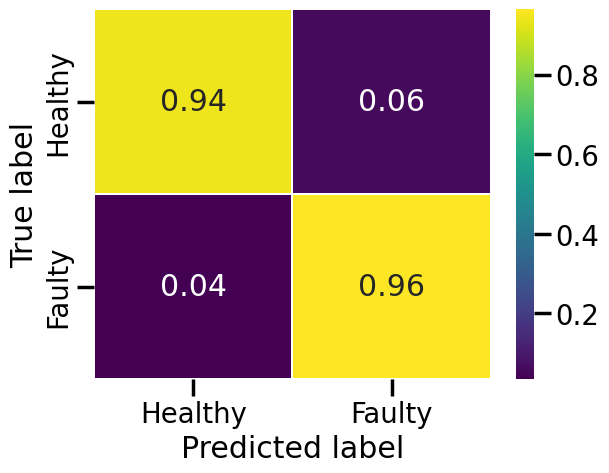

In [69]:
def distance_calculation(
    ensemble_support_groups,
    ensemble_query_healthy_groups,
    ensemble_query_groups,
    distance_metric,
    repetition_offset,
):
    all_support_distances = {}
    all_query_healthy_distances = {}
    all_query_distances = {}

    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    # print(f"> {severity} {fault} {rpm} {torque}")
                    # print("SUPPORT")

                    ensemble_support_distances = []
                    prototypes = []
                    support_inv_cms = []

                    # Ensemble loop
                    for i in range(ensemble_size):
                        prototype = ensemble_support_groups[repetition_offset + i][
                            f"{severity}_{fault}_{rpm}_{torque}"
                        ].mean(axis=0)
                        prototypes.append(prototype)

                        # Calculate distance
                        if distance_metric == "L2":
                            support_distances = distance(
                                prototype,
                                ensemble_support_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                        elif distance_metric == "mahalanobis":
                            support_inv_cm = np.linalg.pinv(
                                np.cov(
                                    ensemble_support_groups[repetition_offset + i][
                                        f"{severity}_{fault}_{rpm}_{torque}"
                                    ],
                                    rowvar=False,
                                )
                            )
                            support_inv_cms.append(support_inv_cm)
                            support_distances = distance_mahalanobis(
                                prototype,
                                ensemble_support_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cm,
                            )
                        else:
                            raise Exception("WAT")
                        ensemble_support_distances.append(support_distances)

                    # Ensemble average
                    mean_support_distances = np.stack(
                        ensemble_support_distances, axis=-1
                    ).mean(axis=-1)
                    all_support_distances[f"{severity}_{fault}_{rpm}_{torque}"] = (
                        mean_support_distances
                    )

                    # print("QUERY")

                    ensemble_query_healthy_distances = []
                    ensemble_query_distances = []

                    for i in range(ensemble_size):
                        if distance_metric == "L2":
                            # Query healthy
                            query_healthy_distances = distance(
                                prototypes[i],
                                ensemble_query_healthy_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                            # Faults
                            query_distances = distance(
                                prototypes[i],
                                ensemble_query_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                        elif distance_metric == "mahalanobis":
                            # Query healthy
                            query_healthy_distances = distance_mahalanobis(
                                prototypes[i],
                                ensemble_query_healthy_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cms[i],
                            )
                            # Faults
                            query_distances = distance_mahalanobis(
                                prototypes[i],
                                ensemble_query_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cms[i],
                            )
                        ensemble_query_healthy_distances.append(query_healthy_distances)
                        ensemble_query_distances.append(query_distances)

                    # Ensemble averages
                    mean_query_healthy_distances = np.stack(
                        ensemble_query_healthy_distances, axis=-1
                    ).mean(axis=-1)
                    all_query_healthy_distances[
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = mean_query_healthy_distances

                    mean_query_distances = np.stack(
                        ensemble_query_distances, axis=-1
                    ).mean(axis=-1)
                    all_query_distances[f"{severity}_{fault}_{rpm}_{torque}"] = (
                        mean_query_distances
                    )

    return all_support_distances, all_query_healthy_distances, all_query_distances


repetition_distances = []  # list<(support, query, query_healthy)>

for repetition_offset in range(
    0, num_repetitions * ensemble_size, ensemble_size
):  # range(0, 25, 5)
    repetition_distances.append(
        distance_calculation(
            ensemble_support_groups,
            ensemble_query_healthy_groups,
            ensemble_query_groups,
            # "mahalanobis",
            "L2",
            repetition_offset,
        )
    )

# Thresholding

support_under = 0
query_healthy_under = 0
query_under = 0

support_total = 0
query_healthy_total = 0
query_total = 0

for (
    repetition_support_distances,
    repetition_query_healthy_distances,
    repetition_query_distances,
) in repetition_distances:
    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    full_class = f"{severity}_{fault}_{rpm}_{torque}"

                    limit = 3.5 * np.max(repetition_support_distances[full_class])
                    # limit = 5 * np.std(repetition_support_distances[full_class])

                    support_under += np.sum(
                        repetition_support_distances[full_class] < limit
                    )
                    support_total += len(repetition_support_distances[full_class])

                    query_healthy_under += np.sum(
                        repetition_query_healthy_distances[full_class] < limit
                    )
                    query_healthy_total += len(
                        repetition_query_healthy_distances[full_class]
                    )

                    query_under += np.sum(
                        repetition_query_distances[full_class] < limit
                    )
                    query_total += len(repetition_query_distances[full_class])

print("STATS")
print(f"{support_under} / {support_total} = {support_under / support_total * 100}%")
print(
    f"{query_healthy_under} / {query_healthy_total} = {query_healthy_under / query_healthy_total * 100}%"
)
print(f"{query_under} / {query_total} = {query_under / query_total * 100}%")
print()
print(
    f"Accuracy: ({query_healthy_under} + {query_total - query_under}) / ({query_healthy_total} + {query_total}) = {(query_healthy_under + (query_total - query_under)) / (query_healthy_total + query_total) * 100:.1f}%"
)
precision = (query_total - query_under) / (
    (query_total - query_under) + (query_healthy_total - query_healthy_under)
)
print(
    f"Precision: {query_total - query_under} / ({query_total - query_under} + {query_healthy_total - query_healthy_under}) = {precision * 100:.1f}%"
)
recall = (query_total - query_under) / ((query_total - query_under) + query_under)
print(
    f"Recall: {query_total - query_under} / ({query_total - query_under} + {query_under}) = {recall * 100:.1f}%"
)
f1 = 2 / ((1 / precision) + (1 / recall))
print(f"F1: {f1}")

# Plotting

cf_agg = np.array(
    [
        [
            query_healthy_under / query_healthy_total,
            (query_healthy_total - query_healthy_under) / query_healthy_total,
        ],
        [query_under / query_total, (query_total - query_under) / query_total],
    ]
)
categories = ["Healthy", "Faulty"]

ax = sns.heatmap(
    cf_agg,
    annot=True,
    fmt=".2f",
    linewidth=0.3,
    xticklabels=categories,
    yticklabels=categories,
    cmap="viridis",
)
ax.set(xlabel="Predicted label", ylabel="True label")

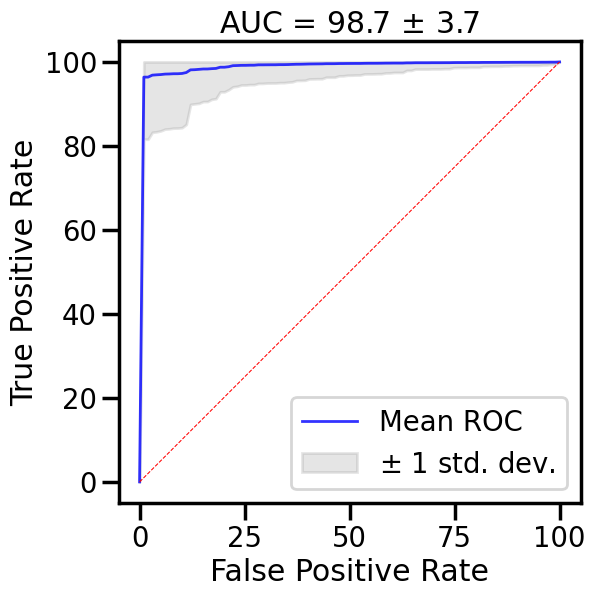

In [70]:
healthy = [
    np.array([x, np.zeros_like(x)]) for x in repetition_query_healthy_distances.values()
]
query = [np.array([x, np.ones_like(x)]) for x in repetition_query_distances.values()]

case_names = list(repetition_query_healthy_distances.keys())

cases = []
for i in range(len(healthy)):
    cases.append(
        {
            "labels": np.concatenate([healthy[i][1], query[i][1]]),
            "scores": np.concatenate([healthy[i][0], query[i][0]]),
        }
    )

fig, ax = plt.subplots(figsize=(6, 6))
# fig, ax = plt.subplots(2, 1, figsize=(6, 6))

fprs = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, case in enumerate(cases[:]):
    # print(case["labels"].shape)
    # print(case["scores"].shape)

    # viz = RocCurveDisplay.from_predictions(
    #     case["labels"],
    #     case["scores"],
    #     name=f"_{case_names[i]}",
    #     alpha=0.3,
    #     lw=1,
    #     # ax=ax,
    #     # plot_chance_level=False,
    #     plot_chance_level=(i == len(cases) - 1),
    # )

    fpr, tpr, _ = roc_curve(case["labels"], case["scores"], drop_intermediate=True)
    roc_auc = roc_auc_score(case["labels"], case["scores"])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    # interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    # aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr * 100,
    mean_tpr * 100,
    color="b",
    label=r"Mean ROC",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr * 100,
    tprs_lower * 100,
    tprs_upper * 100,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}",
    # title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}\n(Positive label 'Faulty')",
    # title=f"Mean ROC curve with variability\n(Positive label 'Faulty')",
)
ax.axis("square")
ax.legend(
    loc="lower right",
)
sns.lineplot(
    x=[0, 100], y=[0, 100], color="red", linestyle="dashed", linewidth=0.75, ax=ax
)
plt.savefig("images/AD_AGFD_T1_ROC.svg")
plt.show()

### More detailed distances


In [71]:
rpm = 750
faults = ["micropitting", "pitting", "wear", "tff"]
installation = [1, 2]
torque = 6

repetition_offset = 0  # * Change this to change between repetitions

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

for i in range(ensemble_size):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for fault in faults:
        for severity in severities:
            # SUPPORT #
            support_group = (
                query_data[repetition_offset + i][
                    (query_data[repetition_offset + i]["rpm"] == rpm)
                    & (
                        query_data[repetition_offset + i]["severity"]
                        == str(fault_GP_map[f"{severity}_{fault}"])
                    )
                    & (query_data[repetition_offset + i]["torque"] == torque)
                ]
                .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
                .to_numpy()
            )

            ensemble_support_groups[i][f"{severity}_{fault}"] = support_group[
                : support_group.shape[0] // 2
            ]

            # QUERY BASELINE #
            ensemble_query_healthy_groups[i][f"{severity}_{fault}"] = support_group[
                support_group.shape[0] // 2 :
            ]

            # QUERY FAULTS #
            query_group = (
                query_data[repetition_offset + i][
                    (query_data[repetition_offset + i]["rpm"] == rpm)
                    & (query_data[repetition_offset + i]["severity"] == severity)
                    & (query_data[repetition_offset + i]["torque"] == torque)
                    & (
                        query_data[repetition_offset + i]["installation"].isin(
                            installation
                        )
                    )
                    & (query_data[repetition_offset + i]["fault"] == fault)
                ]
                .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
                .to_numpy()
            )

            ensemble_query_groups[i][f"{severity}_{fault}"] = query_group

> mild micropitting
SUPPORT
Mean:     0.54
Max:      2.17
Min:      0.04

QUERY
Mean:   849.55 |     1.47
Max:   1025.47 |     5.48
Min:    698.56 |     0.15

> severe micropitting
SUPPORT
Mean:     1.45
Max:      6.98
Min:      0.13

QUERY
Mean:  1071.90 |     5.00
Max:   1227.23 |    10.80
Min:    825.23 |     0.60

> mild pitting
SUPPORT
Mean:     3.16
Max:     41.07
Min:      0.06

QUERY
Mean:   306.06 |    18.88
Max:    635.87 |    67.08
Min:     12.73 |     5.15

> severe pitting
SUPPORT
Mean:     0.54
Max:      1.75
Min:      0.06

QUERY
Mean:   875.84 |     3.23
Max:   1724.52 |     8.32
Min:    195.73 |     0.18

> mild wear
SUPPORT
Mean:     1.34
Max:      4.25
Min:      0.08

QUERY
Mean:   974.93 |     1.15
Max:   1855.91 |     3.13
Min:    173.74 |     0.37

> severe wear
SUPPORT
Mean:     0.21
Max:      0.84
Min:      0.03

QUERY
Mean:  2473.82 |     1.35
Max:   3559.35 |     3.42
Min:   1284.43 |     0.14

> mild tff
SUPPORT
Mean:     0.79
Max:      2.45
Min:      0.08

Q

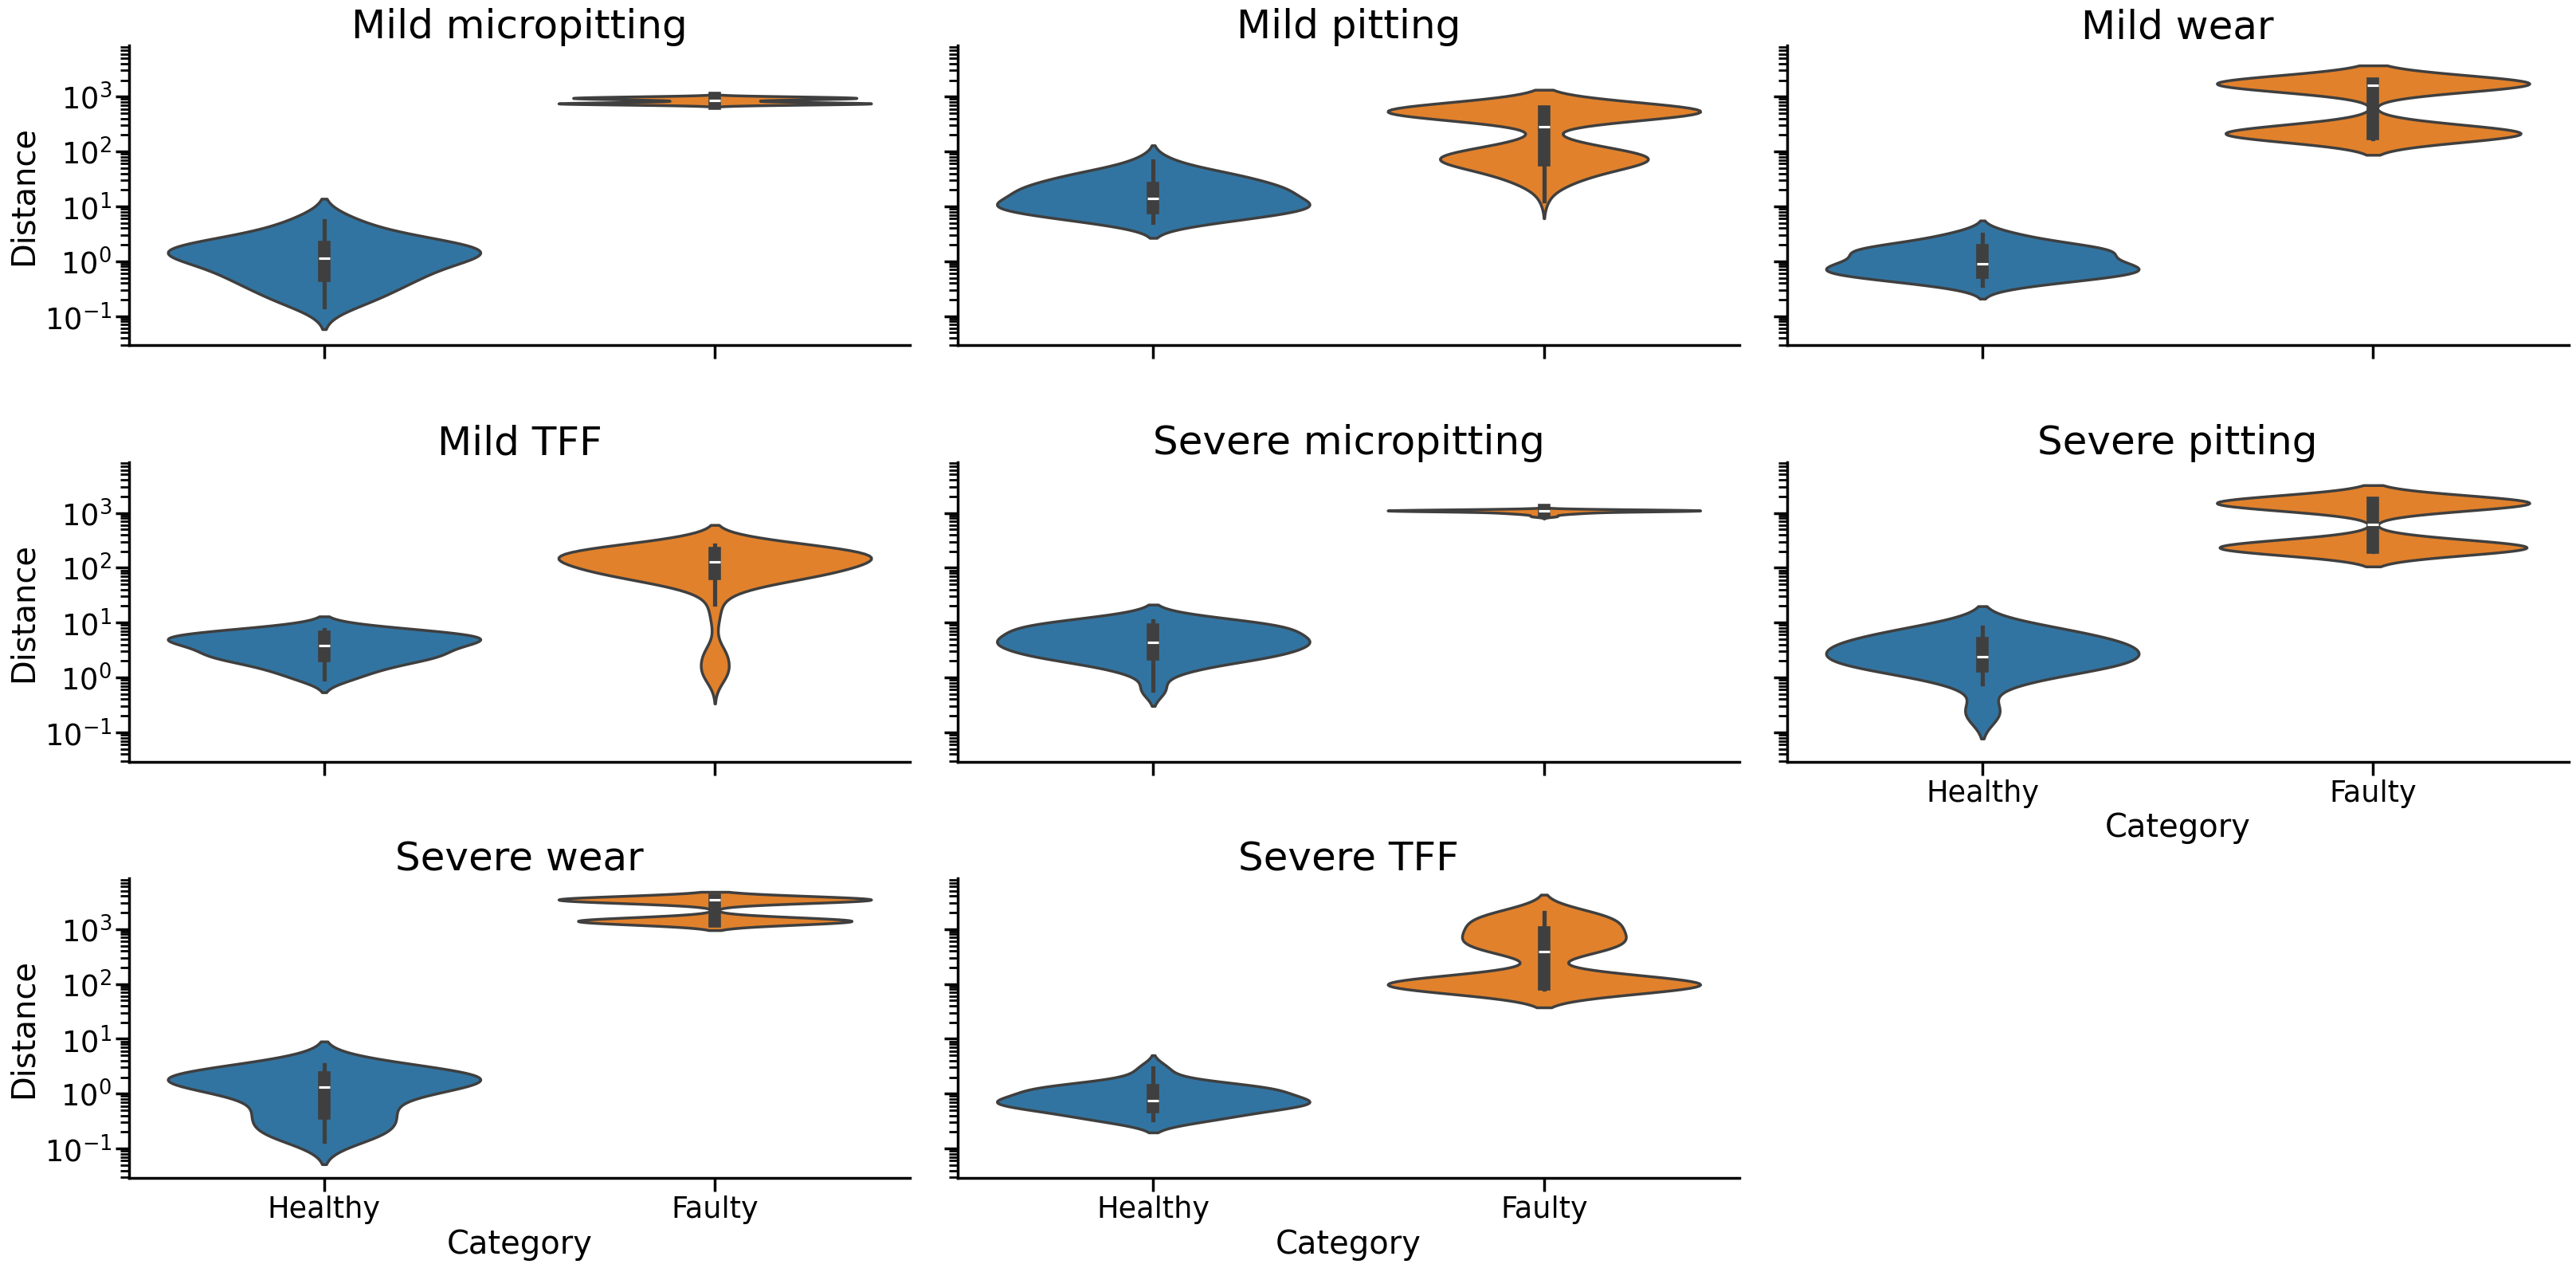

In [72]:
distance_metric = "L2"
# distance_metric = "mahalanobis"

all_support_distances = {}
all_query_healthy_distances = {}
all_query_distances = {}

for fault in faults:
    for severity in severities:
        print(f"> {severity} {fault}")
        print("SUPPORT")

        ensemble_support_distances = []
        prototypes = []
        support_inv_cms = []

        # Ensemble loop
        for i in range(ensemble_size):
            prototype = ensemble_support_groups[i][f"{severity}_{fault}"].mean(axis=0)
            prototypes.append(prototype)

            # Calculate distance
            if distance_metric == "L2":
                support_distances = distance(
                    prototype, ensemble_support_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                support_inv_cm = np.linalg.pinv(
                    np.cov(
                        ensemble_support_groups[i][f"{severity}_{fault}"], rowvar=False
                    )
                )
                support_inv_cms.append(support_inv_cm)
                support_distances = distance_mahalanobis(
                    prototype,
                    ensemble_support_groups[i][f"{severity}_{fault}"],
                    support_inv_cm,
                )
            else:
                raise Exception("WAT")
            ensemble_support_distances.append(support_distances)

        # Ensemble average
        mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(
            axis=-1
        )
        all_support_distances[f"{severity}_{fault}"] = mean_support_distances

        print("Mean: {:>8.2f}".format(mean_support_distances.mean()))
        print("Max:  {:>8.2f}".format(mean_support_distances.max()))
        print("Min:  {:>8.2f}".format(mean_support_distances.min()))
        print()

        print("QUERY")

        ensemble_query_healthy_distances = []
        ensemble_query_distances = []

        for i in range(ensemble_size):
            if distance_metric == "L2":
                # Query healthy
                query_healthy_distances = distance(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                )
                # Faults
                query_distances = distance(
                    prototypes[i], ensemble_query_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                # Query healthy
                query_healthy_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
                # Faults
                query_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
            ensemble_query_healthy_distances.append(query_healthy_distances)
            ensemble_query_distances.append(query_distances)

        # Ensemble averages
        mean_query_healthy_distances = np.stack(
            ensemble_query_healthy_distances, axis=-1
        ).mean(axis=-1)
        all_query_healthy_distances[f"{severity}_{fault}"] = (
            mean_query_healthy_distances
        )

        mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(axis=-1)
        all_query_distances[f"{severity}_{fault}"] = mean_query_distances

        print(
            "Mean: {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.mean(), mean_query_healthy_distances.mean()
            )
        )
        print(
            "Max:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.max(), mean_query_healthy_distances.max()
            )
        )
        print(
            "Min:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.min(), mean_query_healthy_distances.min()
            )
        )
        print()

# Plotting

df = []
for severity in severities:
    for fault in faults:
        full_fault = f"{severity}_{fault}"

        # tmp_1 = pd.DataFrame(all_support_distances[full_fault], columns=["distance"])
        # tmp_1["category"] = "Support"
        # tmp_1["fault"] = full_fault
        tmp_2 = pd.DataFrame(
            all_query_healthy_distances[full_fault], columns=["Distance"]
        )
        tmp_2["Category"] = "Healthy"
        tmp_2["Fault"] = full_fault.replace("_", " ").capitalize().replace("tff", "TFF")
        tmp_3 = pd.DataFrame(all_query_distances[full_fault], columns=["Distance"])
        tmp_3["Category"] = "Faulty"
        # tmp_3["Category"] = "Faulty"
        tmp_3["Fault"] = full_fault.replace("_", " ").capitalize().replace("tff", "TFF")

        # df.append(tmp_1)
        df.append(tmp_2)
        df.append(tmp_3)

df = pd.concat(df)
# print(df)
# raise

# fig, ax = plt.subplots(figsize=(6.5, 6))
with sns.plotting_context("poster", font_scale=1.2):
    g = sns.catplot(
        df,
        x="Category",
        y="Distance",
        hue="Category",
        col="Fault",
        col_wrap=3,
        log_scale=True,
        height=5.5,
        aspect=2,
        kind="violin",
        # palette=sns.color_palette("Paired"),
        legend=False,
        # width=2.1,
    )
    # plt.tight_layout()
    g.set_titles(col_template="{col_name}", size=36)

    plt.savefig("images/AD_AGFD_T1_distances.pdf", format="pdf", bbox_inches="tight")

## Trained w/ ASD, acc3


In [73]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

query_data = []
num_repetitions = 10
ensemble_size = 5

for i in range(num_repetitions * ensemble_size):
    query_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                "AD_ARotor_replication_acc3_article",
                f"query_{i}.feather",
            )
        )
    )

print("Number of models: ", len(query_data))
print("Queries:", query_data[0].shape)

fault_GP_map = {
    "mild_micropitting": 4,
    "severe_micropitting": 3,
    "mild_pitting": 1,
    "severe_pitting": 6,
    "mild_wear": 7,
    "severe_wear": 2,
    "mild_tff": 9,
    "severe_tff": 5,
}


def distance_mahalanobis(prototype, queries, inv_cm):
    return np.array([mahalanobis(x, prototype, inv_cm) for x in queries])


def distance(prototype, queries):
    return np.sum((queries - prototype) ** 2, axis=1)

Number of models:  50
Queries: (34017, 21)


In [74]:
rpms = [500, 750, 1250, 1500]
# rpm = 1500
torques = [1, 6, 11]
severities = ["mild", "severe"]
faults = ["micropitting", "pitting", "wear", "tff"]
# installation = [1]
installation = [1, 2]
# GPs = [2, 3, 5, 6]

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

assert (
    len(query_data) == num_repetitions * ensemble_size
), f"len(query_data) != num_repetitions * ensemble_size, {len(query_data)} != {num_repetitions * ensemble_size}"

for i in range(len(query_data)):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    full_fault = f"{severity} {fault} {rpm} {torque}"
                    # SUPPORT #
                    support_group = (
                        query_data[i][
                            (query_data[i]["rpm"] == rpm)
                            & (
                                query_data[i]["severity"]
                                == str(fault_GP_map[f"{severity}_{fault}"])
                            )
                            & (query_data[i]["torque"] == torque)
                        ]
                        .drop(
                            ["rpm", "severity", "fault", "installation", "torque"],
                            axis=1,
                        )
                        .to_numpy()
                    )
                    # Check if NaNs
                    if np.sum(~np.isfinite(support_group)) != 0:
                        print("NaN detected in {full_fault}!")
                        print(support_group)
                        raise

                    # * 50/50 split on baseline measurements to support and query
                    ensemble_support_groups[i][f"{severity}_{fault}_{rpm}_{torque}"] = (
                        support_group[: support_group.shape[0] // 2]
                    )

                    # QUERY BASELINE #
                    ensemble_query_healthy_groups[i][
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = support_group[support_group.shape[0] // 2 :]

                    # QUERY FAULTS #
                    query_group = (
                        query_data[i][
                            (query_data[i]["rpm"] == rpm)
                            & (query_data[i]["severity"] == severity)
                            & (query_data[i]["torque"] == torque)
                            & (query_data[i]["installation"].isin(installation))
                            & (query_data[i]["fault"] == fault)
                        ]
                        .drop(
                            ["rpm", "severity", "fault", "installation", "torque"],
                            axis=1,
                        )
                        .to_numpy()
                    )

                    # Check if NaNs
                    if np.sum(~np.isfinite(query_group)) != 0:
                        print("NaN detected in {full_fault}!")
                        print(query_group)
                        raise

                    ensemble_query_groups[i][
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = query_group

STATS
33880 / 33880 = 100.0%
34162 / 34270 = 99.68485555879778%
15834 / 263500 = 6.009108159392789%

Accuracy: (34162 + 247666) / (34270 + 263500) = 94.6%
Precision: 247666 / (247666 + 108) = 100.0%
Recall: 247666 / (247666 + 15834) = 94.0%
F1: 0.9688190676623494


[Text(0.5, -2.2833333333333368, 'Predicted label'),
 Text(24.916666666666657, 0.5, 'True label')]

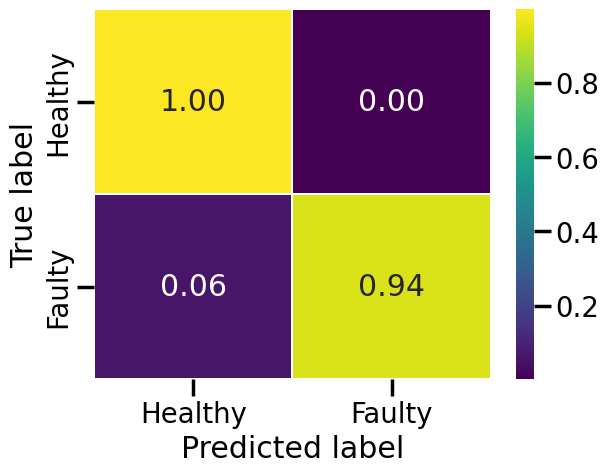

In [75]:
def distance_calculation(
    ensemble_support_groups,
    ensemble_query_healthy_groups,
    ensemble_query_groups,
    distance_metric,
    repetition_offset,
):
    all_support_distances = {}
    all_query_healthy_distances = {}
    all_query_distances = {}

    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    # print(f"> {severity} {fault} {rpm} {torque}")
                    # print("SUPPORT")

                    ensemble_support_distances = []
                    prototypes = []
                    support_inv_cms = []

                    # Ensemble loop
                    for i in range(ensemble_size):
                        prototype = ensemble_support_groups[repetition_offset + i][
                            f"{severity}_{fault}_{rpm}_{torque}"
                        ].mean(axis=0)
                        prototypes.append(prototype)

                        # Calculate distance
                        if distance_metric == "L2":
                            support_distances = distance(
                                prototype,
                                ensemble_support_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                        elif distance_metric == "mahalanobis":
                            support_inv_cm = np.linalg.pinv(
                                np.cov(
                                    ensemble_support_groups[repetition_offset + i][
                                        f"{severity}_{fault}_{rpm}_{torque}"
                                    ],
                                    rowvar=False,
                                )
                            )
                            support_inv_cms.append(support_inv_cm)
                            support_distances = distance_mahalanobis(
                                prototype,
                                ensemble_support_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cm,
                            )
                        else:
                            raise Exception("WAT")
                        ensemble_support_distances.append(support_distances)

                    # Ensemble average
                    mean_support_distances = np.stack(
                        ensemble_support_distances, axis=-1
                    ).mean(axis=-1)
                    all_support_distances[f"{severity}_{fault}_{rpm}_{torque}"] = (
                        mean_support_distances
                    )

                    # print("QUERY")

                    ensemble_query_healthy_distances = []
                    ensemble_query_distances = []

                    for i in range(ensemble_size):
                        if distance_metric == "L2":
                            # Query healthy
                            query_healthy_distances = distance(
                                prototypes[i],
                                ensemble_query_healthy_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                            # Faults
                            query_distances = distance(
                                prototypes[i],
                                ensemble_query_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                        elif distance_metric == "mahalanobis":
                            # Query healthy
                            query_healthy_distances = distance_mahalanobis(
                                prototypes[i],
                                ensemble_query_healthy_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cms[i],
                            )
                            # Faults
                            query_distances = distance_mahalanobis(
                                prototypes[i],
                                ensemble_query_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cms[i],
                            )
                        ensemble_query_healthy_distances.append(query_healthy_distances)
                        ensemble_query_distances.append(query_distances)

                    # Ensemble averages
                    mean_query_healthy_distances = np.stack(
                        ensemble_query_healthy_distances, axis=-1
                    ).mean(axis=-1)
                    all_query_healthy_distances[
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = mean_query_healthy_distances

                    mean_query_distances = np.stack(
                        ensemble_query_distances, axis=-1
                    ).mean(axis=-1)
                    all_query_distances[f"{severity}_{fault}_{rpm}_{torque}"] = (
                        mean_query_distances
                    )

    return all_support_distances, all_query_healthy_distances, all_query_distances


repetition_distances = []  # list<(support, query, query_healthy)>

for repetition_offset in range(
    0, num_repetitions * ensemble_size, ensemble_size
):  # range(0, 25, 5)
    repetition_distances.append(
        distance_calculation(
            ensemble_support_groups,
            ensemble_query_healthy_groups,
            ensemble_query_groups,
            # "mahalanobis",
            "L2",
            repetition_offset,
        )
    )

# Thresholding

support_under = 0
query_healthy_under = 0
query_under = 0

support_total = 0
query_healthy_total = 0
query_total = 0

for (
    repetition_support_distances,
    repetition_query_healthy_distances,
    repetition_query_distances,
) in repetition_distances:
    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    full_class = f"{severity}_{fault}_{rpm}_{torque}"

                    limit = 3.5 * np.max(repetition_support_distances[full_class])
                    # std = np.std(repetition_support_distances[full_class])
                    # limit = 20 * std

                    support_under += np.sum(
                        repetition_support_distances[full_class] < limit
                    )
                    support_total += len(repetition_support_distances[full_class])

                    query_healthy_under += np.sum(
                        repetition_query_healthy_distances[full_class] < limit
                    )
                    query_healthy_total += len(
                        repetition_query_healthy_distances[full_class]
                    )

                    query_under += np.sum(
                        repetition_query_distances[full_class] < limit
                    )
                    query_total += len(repetition_query_distances[full_class])

print("STATS")
print(f"{support_under} / {support_total} = {support_under / support_total * 100}%")
print(
    f"{query_healthy_under} / {query_healthy_total} = {query_healthy_under / query_healthy_total * 100}%"
)
print(f"{query_under} / {query_total} = {query_under / query_total * 100}%")
print()
print(
    f"Accuracy: ({query_healthy_under} + {query_total - query_under}) / ({query_healthy_total} + {query_total}) = {(query_healthy_under + (query_total - query_under)) / (query_healthy_total + query_total) * 100:.1f}%"
)
precision = (query_total - query_under) / (
    (query_total - query_under) + (query_healthy_total - query_healthy_under)
)
print(
    f"Precision: {query_total - query_under} / ({query_total - query_under} + {query_healthy_total - query_healthy_under}) = {precision * 100:.1f}%"
)
recall = (query_total - query_under) / ((query_total - query_under) + query_under)
print(
    f"Recall: {query_total - query_under} / ({query_total - query_under} + {query_under}) = {recall * 100:.1f}%"
)
f1 = 2 / ((1 / precision) + (1 / recall))
print(f"F1: {f1}")

# Plotting

cf_agg = np.array(
    [
        [
            query_healthy_under / query_healthy_total,
            (query_healthy_total - query_healthy_under) / query_healthy_total,
        ],
        [query_under / query_total, (query_total - query_under) / query_total],
    ]
)
categories = ["Healthy", "Faulty"]

ax = sns.heatmap(
    cf_agg,
    annot=True,
    fmt=".2f",
    linewidth=0.3,
    xticklabels=categories,
    yticklabels=categories,
    cmap="viridis",
)
ax.set(xlabel="Predicted label", ylabel="True label")

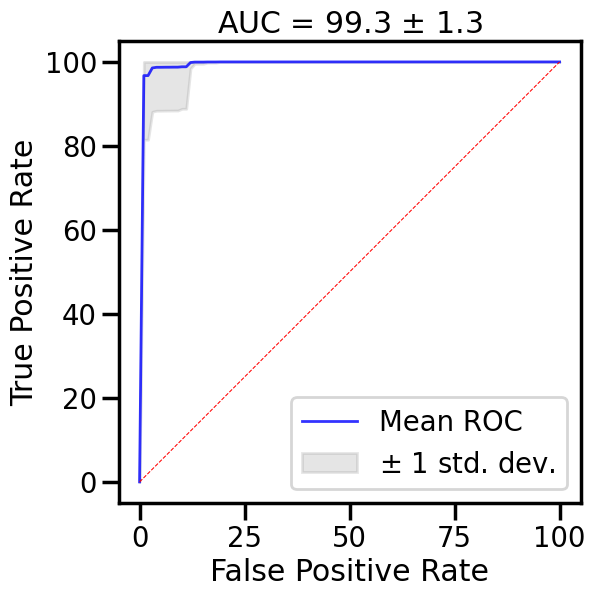

In [76]:
healthy = [
    np.array([x, np.zeros_like(x)]) for x in repetition_query_healthy_distances.values()
]
query = [np.array([x, np.ones_like(x)]) for x in repetition_query_distances.values()]

case_names = list(repetition_query_healthy_distances.keys())

cases = []
for i in range(len(healthy)):
    cases.append(
        {
            "labels": np.concatenate([healthy[i][1], query[i][1]]),
            "scores": np.concatenate([healthy[i][0], query[i][0]]),
        }
    )

fig, ax = plt.subplots(figsize=(6, 6))
# fig, ax = plt.subplots(2, 1, figsize=(6, 6))

fprs = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, case in enumerate(cases[:]):
    # print(case["labels"].shape)
    # print(case["scores"].shape)

    # viz = RocCurveDisplay.from_predictions(
    #     case["labels"],
    #     case["scores"],
    #     name=f"_{case_names[i]}",
    #     alpha=0.3,
    #     lw=1,
    #     # ax=ax,
    #     # plot_chance_level=False,
    #     plot_chance_level=(i == len(cases) - 1),
    # )

    fpr, tpr, _ = roc_curve(case["labels"], case["scores"], drop_intermediate=True)
    roc_auc = roc_auc_score(case["labels"], case["scores"])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    # interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    # aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr * 100,
    mean_tpr * 100,
    color="b",
    label=r"Mean ROC",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr * 100,
    tprs_lower * 100,
    tprs_upper * 100,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}",
    # title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}\n(Positive label 'Faulty')",
    # title=f"Mean ROC curve with variability\n(Positive label 'Faulty')",
)
ax.axis("square")
ax.legend(
    loc="lower right",
)
sns.lineplot(
    x=[0, 100], y=[0, 100], color="red", linestyle="dashed", linewidth=0.75, ax=ax
)
plt.savefig("images/AD_AGFD_A3_ROC.svg")
plt.show()

### More detailed look


In [77]:
rpm = 750
faults = ["micropitting", "pitting", "wear", "tff"]
installation = [1, 2]
torque = 6

repetition_offset = 0  # * Change this to change between repetitions

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

for i in range(ensemble_size):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for fault in faults:
        for severity in severities:
            # SUPPORT #
            support_group = (
                query_data[repetition_offset + i][
                    (query_data[repetition_offset + i]["rpm"] == rpm)
                    & (
                        query_data[repetition_offset + i]["severity"]
                        == str(fault_GP_map[f"{severity}_{fault}"])
                    )
                    & (query_data[repetition_offset + i]["torque"] == torque)
                ]
                .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
                .to_numpy()
            )

            ensemble_support_groups[i][f"{severity}_{fault}"] = support_group[
                : support_group.shape[0] // 2
            ]

            # QUERY BASELINE #
            ensemble_query_healthy_groups[i][f"{severity}_{fault}"] = support_group[
                support_group.shape[0] // 2 :
            ]

            # QUERY FAULTS #
            query_group = (
                query_data[repetition_offset + i][
                    (query_data[repetition_offset + i]["rpm"] == rpm)
                    & (query_data[repetition_offset + i]["severity"] == severity)
                    & (query_data[repetition_offset + i]["torque"] == torque)
                    & (
                        query_data[repetition_offset + i]["installation"].isin(
                            installation
                        )
                    )
                    & (query_data[repetition_offset + i]["fault"] == fault)
                ]
                .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
                .to_numpy()
            )

            ensemble_query_groups[i][f"{severity}_{fault}"] = query_group

> mild micropitting
SUPPORT
Mean:     3.60
Max:      9.47
Min:      1.66

QUERY
Mean:   390.23 |     5.08
Max:    616.71 |    11.63
Min:    212.93 |     1.21

> severe micropitting
SUPPORT
Mean:     7.29
Max:     22.80
Min:      2.20

QUERY
Mean:   514.11 |     9.76
Max:    702.26 |    22.70
Min:    417.52 |     2.88

> mild pitting
SUPPORT
Mean:     5.24
Max:     14.75
Min:      0.93

QUERY
Mean:   504.01 |     7.90
Max:   1112.46 |    20.04
Min:     21.89 |     2.87

> severe pitting
SUPPORT
Mean:     4.53
Max:     15.88
Min:      1.55

QUERY
Mean:   211.98 |     5.39
Max:    348.70 |    10.53
Min:    117.28 |     2.51

> mild wear
SUPPORT
Mean:     5.14
Max:     11.63
Min:      1.87

QUERY
Mean:   308.21 |     6.43
Max:    475.77 |    15.74
Min:    205.53 |     2.89

> severe wear
SUPPORT
Mean:     4.67
Max:     14.77
Min:      1.87

QUERY
Mean:   151.19 |     5.08
Max:    306.54 |     9.79
Min:     52.46 |     1.26

> mild tff
SUPPORT
Mean:     7.95
Max:     29.30
Min:      2.31

Q

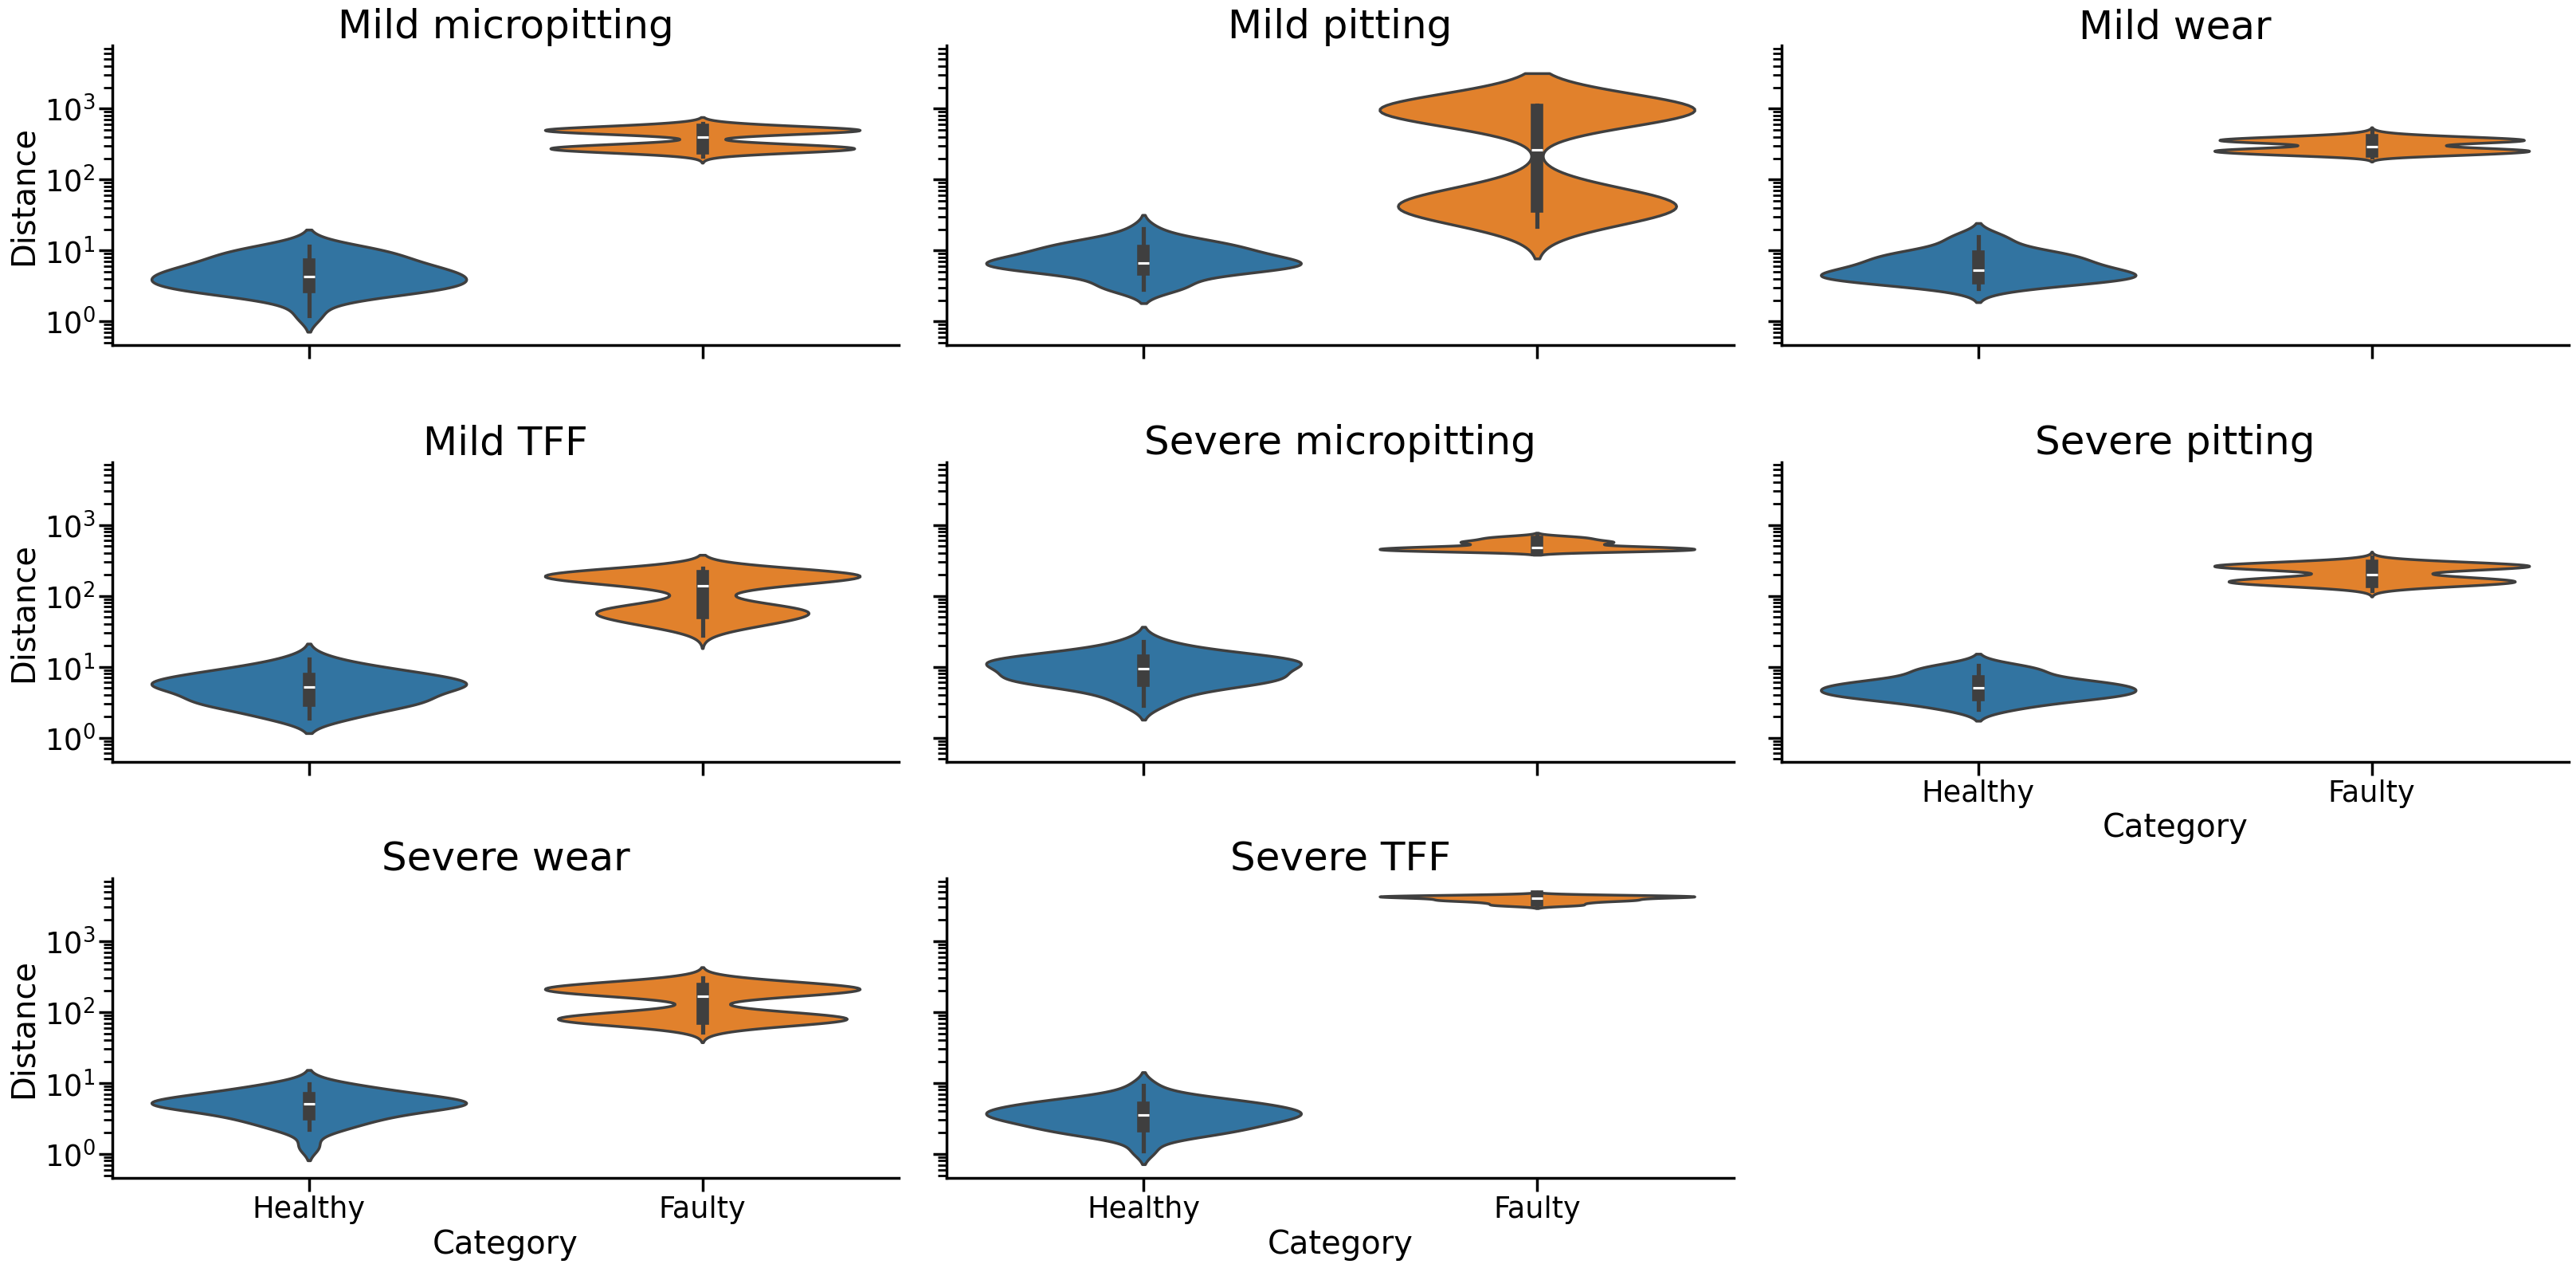

In [78]:
distance_metric = "L2"
# distance_metric = "mahalanobis"

all_support_distances = {}
all_query_healthy_distances = {}
all_query_distances = {}

for fault in faults:
    for severity in severities:
        print(f"> {severity} {fault}")
        print("SUPPORT")

        ensemble_support_distances = []
        prototypes = []
        support_inv_cms = []

        # Ensemble loop
        for i in range(ensemble_size):
            prototype = ensemble_support_groups[i][f"{severity}_{fault}"].mean(axis=0)
            prototypes.append(prototype)

            # Calculate distance
            if distance_metric == "L2":
                support_distances = distance(
                    prototype, ensemble_support_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                support_inv_cm = np.linalg.pinv(
                    np.cov(
                        ensemble_support_groups[i][f"{severity}_{fault}"], rowvar=False
                    )
                )
                support_inv_cms.append(support_inv_cm)
                support_distances = distance_mahalanobis(
                    prototype,
                    ensemble_support_groups[i][f"{severity}_{fault}"],
                    support_inv_cm,
                )
            else:
                raise Exception("WAT")
            ensemble_support_distances.append(support_distances)

        # Ensemble average
        mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(
            axis=-1
        )
        all_support_distances[f"{severity}_{fault}"] = mean_support_distances

        print("Mean: {:>8.2f}".format(mean_support_distances.mean()))
        print("Max:  {:>8.2f}".format(mean_support_distances.max()))
        print("Min:  {:>8.2f}".format(mean_support_distances.min()))
        print()

        print("QUERY")

        ensemble_query_healthy_distances = []
        ensemble_query_distances = []

        for i in range(ensemble_size):
            if distance_metric == "L2":
                # Query healthy
                query_healthy_distances = distance(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                )
                # Faults
                query_distances = distance(
                    prototypes[i], ensemble_query_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                # Query healthy
                query_healthy_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
                # Faults
                query_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
            ensemble_query_healthy_distances.append(query_healthy_distances)
            ensemble_query_distances.append(query_distances)

        # Ensemble averages
        mean_query_healthy_distances = np.stack(
            ensemble_query_healthy_distances, axis=-1
        ).mean(axis=-1)
        all_query_healthy_distances[f"{severity}_{fault}"] = (
            mean_query_healthy_distances
        )

        mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(axis=-1)
        all_query_distances[f"{severity}_{fault}"] = mean_query_distances

        print(
            "Mean: {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.mean(), mean_query_healthy_distances.mean()
            )
        )
        print(
            "Max:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.max(), mean_query_healthy_distances.max()
            )
        )
        print(
            "Min:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.min(), mean_query_healthy_distances.min()
            )
        )
        print()

# Plotting

df = []
for severity in severities:
    for fault in faults:
        full_fault = f"{severity}_{fault}"

        # tmp_1 = pd.DataFrame(all_support_distances[full_fault], columns=["distance"])
        # tmp_1["category"] = "Support"
        # tmp_1["fault"] = full_fault
        tmp_2 = pd.DataFrame(
            all_query_healthy_distances[full_fault], columns=["Distance"]
        )
        tmp_2["Category"] = "Healthy"
        tmp_2["Fault"] = full_fault.replace("_", " ").capitalize().replace("tff", "TFF")
        tmp_3 = pd.DataFrame(all_query_distances[full_fault], columns=["Distance"])
        tmp_3["Category"] = "Faulty"
        # tmp_3["Category"] = "Faulty"
        tmp_3["Fault"] = full_fault.replace("_", " ").capitalize().replace("tff", "TFF")

        # df.append(tmp_1)
        df.append(tmp_2)
        df.append(tmp_3)

df = pd.concat(df)
# print(df)
# raise

# fig, ax = plt.subplots(figsize=(6.5, 6))
with sns.plotting_context("poster", font_scale=1.2):
    g = sns.catplot(
        df,
        x="Category",
        y="Distance",
        hue="Category",
        col="Fault",
        col_wrap=3,
        log_scale=True,
        height=5.5,
        aspect=2,
        kind="violin",
        # palette=sns.color_palette("Paired"),
        legend=False,
        # width=2.1,
    )
    # plt.tight_layout()
    g.set_titles(col_template="{col_name}", size=36)

    plt.savefig("images/AD_AGFD_A3_distances.pdf", format="pdf", bbox_inches="tight")

# Trained w/ AGFD, torque1


In [79]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

query_data = []
num_repetitions = 10
ensemble_size = 5

for i in range(num_repetitions * ensemble_size):
    query_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                "AD_arotor_torque1_article",
                f"query_{i}.feather",
            )
        )
    )

print("Number of models: ", len(query_data))
print("Queries:", query_data[0].shape)


def distance_mahalanobis(prototype, queries, inv_cm):
    return np.array([mahalanobis(x, prototype, inv_cm) for x in queries])


def distance(prototype, queries):
    return np.sum((queries - prototype) ** 2, axis=1)

Number of models:  50
Queries: (6240, 18)


In [80]:
rpms = [250, 500, 750, 1000, 1250, 1500]
faults = [1, 2, 3, 4, 5, 6, 7, 8, 9]

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

assert (
    len(query_data) == num_repetitions * ensemble_size
), f"len(query_data) != num_repetitions * ensemble_size, {len(query_data)} != {num_repetitions * ensemble_size}"

for i in range(len(query_data)):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for rpm in rpms:
        # SUPPORT #
        support_group = (
            query_data[i][(query_data[i]["rpm"] == rpm) & (query_data[i]["class"] == 0)]
            .drop(
                ["rpm", "class"],
                axis=1,
            )
            .to_numpy()
        )
        # Check if NaNs
        if np.sum(~np.isfinite(support_group)) != 0:
            print("NaN detected in {full_fault}!")
            print(support_group)
            raise

        # * 50/50 split on baseline measurements to support and query
        ensemble_support_groups[i][f"0_{rpm}"] = support_group[
            : support_group.shape[0] // 2
        ]

        # QUERY BASELINE #
        ensemble_query_healthy_groups[i][f"0_{rpm}"] = support_group[
            support_group.shape[0] // 2 :
        ]

        for fault in faults:
            full_fault = f"{fault} {rpm}"

            # QUERY FAULTS #
            query_group = (
                query_data[i][
                    (query_data[i]["rpm"] == rpm) & (query_data[i]["class"] == fault)
                ]
                .drop(
                    ["rpm", "class"],
                    axis=1,
                )
                .to_numpy()
            )

            # Check if NaNs
            if np.sum(~np.isfinite(query_group)) != 0:
                print("NaN detected in {full_fault}!")
                print(query_group)
                raise

            ensemble_query_groups[i][f"{fault}_{rpm}"] = query_group

STATS
28080 / 28080 = 100.0%
27846 / 28080 = 99.16666666666667%
478 / 56160 = 0.8511396011396012%

Accuracy: (27846 + 55682) / (28080 + 56160) = 99.2%
Precision: 55682 / (55682 + 234) = 99.6%
Recall: 55682 / (55682 + 478) = 99.1%
F1: 0.9936471679931476


[Text(0.5, -2.2833333333333368, 'Predicted label'),
 Text(24.916666666666657, 0.5, 'True label')]

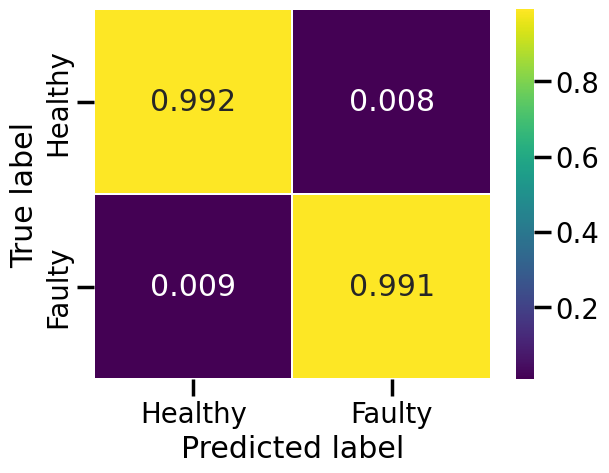

In [81]:
distance_metric = "L2"
# distance_metric = "mahalanobis"


def distance_calculation(
    ensemble_support_groups,
    ensemble_query_healthy_groups,
    ensemble_query_groups,
    distance_metric,
    repetition_offset,
):
    all_support_distances = {}
    all_query_healthy_distances = {}
    all_query_distances = {}

    for rpm in rpms:
        ensemble_support_distances = []
        ensemble_query_healthy_distances = []
        prototypes = []
        support_inv_cms = []

        # Ensemble loop
        for i in range(ensemble_size):
            prototype = ensemble_support_groups[repetition_offset + i][f"0_{rpm}"].mean(
                axis=0
            )
            prototypes.append(prototype)

            # Calculate distance
            if distance_metric == "L2":
                # Support
                support_distances = distance(
                    prototype,
                    ensemble_support_groups[repetition_offset + i][f"0_{rpm}"],
                )
                # Query healthy
                query_healthy_distances = distance(
                    prototypes[i],
                    ensemble_query_healthy_groups[repetition_offset + i][f"0_{rpm}"],
                )
            elif distance_metric == "mahalanobis":
                # Support
                support_inv_cm = np.linalg.pinv(
                    np.cov(
                        ensemble_support_groups[repetition_offset + i][f"0_{rpm}"],
                        rowvar=False,
                    )
                )
                support_inv_cms.append(support_inv_cm)
                support_distances = distance_mahalanobis(
                    prototype,
                    ensemble_support_groups[repetition_offset + i][f"0_{rpm}"],
                    support_inv_cm,
                )
                # Query healthy
                query_healthy_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_healthy_groups[repetition_offset + i][f"0_{rpm}"],
                    support_inv_cms[i],
                )
            else:
                raise Exception("WAT")
            ensemble_support_distances.append(support_distances)
            ensemble_query_healthy_distances.append(query_healthy_distances)

        # Ensemble average
        # Support
        mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(
            axis=-1
        )
        all_support_distances[f"0_{rpm}"] = mean_support_distances
        # Query healthy
        mean_query_healthy_distances = np.stack(
            ensemble_query_healthy_distances, axis=-1
        ).mean(axis=-1)
        all_query_healthy_distances[f"0_{rpm}"] = mean_query_healthy_distances

        for fault in faults:
            ensemble_query_distances = []

            for i in range(ensemble_size):
                if distance_metric == "L2":
                    # Faults
                    query_distances = distance(
                        prototypes[i],
                        ensemble_query_groups[repetition_offset + i][f"{fault}_{rpm}"],
                    )
                elif distance_metric == "mahalanobis":
                    # Faults
                    query_distances = distance_mahalanobis(
                        prototypes[i],
                        ensemble_query_groups[repetition_offset + i][f"{fault}_{rpm}"],
                        support_inv_cms[i],
                    )
                ensemble_query_distances.append(query_distances)

            # Ensemble averages
            mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(
                axis=-1
            )
            all_query_distances[f"{fault}_{rpm}"] = mean_query_distances

    return all_support_distances, all_query_healthy_distances, all_query_distances


repetition_distances = []  # list<(support, query, query_healthy)>

for repetition_offset in range(
    0, num_repetitions * ensemble_size, ensemble_size
):  # range(0, 50, 5)
    repetition_distances.append(
        distance_calculation(
            ensemble_support_groups,
            ensemble_query_healthy_groups,
            ensemble_query_groups,
            # "mahalanobis",
            # "L2",
            distance_metric,
            repetition_offset,
        )
    )

# Thresholding

support_under = 0
query_healthy_under = 0
query_under = 0

support_total = 0
query_healthy_total = 0
query_total = 0

for (
    repetition_support_distances,
    repetition_query_healthy_distances,
    repetition_query_distances,
) in repetition_distances:
    for rpm in rpms:
        for fault in faults:
            full_class = f"{fault}_{rpm}"
            support_class = f"0_{rpm}"

            limit = 4 * np.max(repetition_support_distances[support_class])
            # std = np.std(repetition_support_distances[full_class])
            # limit = 20 * std

            support_under += np.sum(repetition_support_distances[support_class] < limit)
            support_total += len(repetition_support_distances[support_class])

            query_healthy_under += np.sum(
                repetition_query_healthy_distances[support_class] < limit
            )
            query_healthy_total += len(
                repetition_query_healthy_distances[support_class]
            )

            # print(list(repetition_query_distances.keys()))
            # raise
            query_under += np.sum(repetition_query_distances[full_class] < limit)
            query_total += len(repetition_query_distances[full_class])

print("STATS")
print(f"{support_under} / {support_total} = {support_under / support_total * 100}%")
print(
    f"{query_healthy_under} / {query_healthy_total} = {query_healthy_under / query_healthy_total * 100}%"
)
print(f"{query_under} / {query_total} = {query_under / query_total * 100}%")
print()
print(
    f"Accuracy: ({query_healthy_under} + {query_total - query_under}) / ({query_healthy_total} + {query_total}) = {(query_healthy_under + (query_total - query_under)) / (query_healthy_total + query_total) * 100:.1f}%"
)
precision = (query_total - query_under) / (
    (query_total - query_under) + (query_healthy_total - query_healthy_under)
)
print(
    f"Precision: {query_total - query_under} / ({query_total - query_under} + {query_healthy_total - query_healthy_under}) = {precision * 100:.1f}%"
)
recall = (query_total - query_under) / ((query_total - query_under) + query_under)
print(
    f"Recall: {query_total - query_under} / ({query_total - query_under} + {query_under}) = {recall * 100:.1f}%"
)
f1 = 2 / ((1 / precision) + (1 / recall))
print(f"F1: {f1}")

# Plotting

cf_agg = np.array(
    [
        [
            query_healthy_under / query_healthy_total,
            (query_healthy_total - query_healthy_under) / query_healthy_total,
        ],
        [query_under / query_total, (query_total - query_under) / query_total],
    ]
)
categories = ["Healthy", "Faulty"]

ax = sns.heatmap(
    cf_agg,
    annot=True,
    fmt=".3f",
    linewidth=0.3,
    xticklabels=categories,
    yticklabels=categories,
    cmap="viridis",
)
ax.set(xlabel="Predicted label", ylabel="True label")

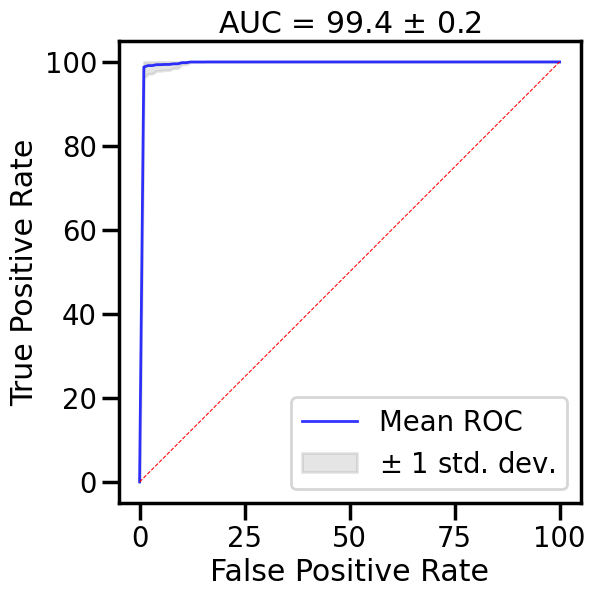

In [82]:
healthy_ds = {}
healthy_labels = {}
for rpm in rpms:
    ds = repetition_query_healthy_distances[f"0_{rpm}"]
    healthy_ds[f"{rpm}"] = ds
    healthy_labels[f"{rpm}"] = np.zeros_like(ds)

faulty_ds = {}
faulty_labels = {}
for rpm in rpms:
    faulty_ds[f"{rpm}"] = []
    faulty_labels[f"{rpm}"] = []

    for fault in faults:
        ds = repetition_query_distances[f"{fault}_{rpm}"]
        faulty_ds[f"{rpm}"].extend(ds)
        faulty_labels[f"{rpm}"].extend(np.ones_like(ds))

cases = []
for rpm in rpms:
    cases.append(
        {
            "labels": np.concatenate(
                [healthy_labels[f"{rpm}"], faulty_labels[f"{rpm}"]]
            ),
            "scores": np.concatenate([healthy_ds[f"{rpm}"], faulty_ds[f"{rpm}"]]),
        }
    )

fig, ax = plt.subplots(figsize=(6, 6))
# fig, ax = plt.subplots(2, 1, figsize=(6, 6))

fprs = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, case in enumerate(cases[:]):
    # print(case["labels"].shape)
    # print(case["scores"].shape)

    # viz = RocCurveDisplay.from_predictions(
    #     case["labels"],
    #     case["scores"],
    #     name=f"_{case_names[i]}",
    #     alpha=0.3,
    #     lw=1,
    #     # ax=ax,
    #     # plot_chance_level=False,
    #     plot_chance_level=(i == len(cases) - 1),
    # )

    fpr, tpr, _ = roc_curve(case["labels"], case["scores"], drop_intermediate=True)
    roc_auc = roc_auc_score(case["labels"], case["scores"])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    # interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    # aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr * 100,
    mean_tpr * 100,
    color="b",
    label=r"Mean ROC",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr * 100,
    tprs_lower * 100,
    tprs_upper * 100,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}",
    # title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}\n(Positive label 'Faulty')",
)
ax.axis("square")
ax.legend(
    loc="lower right",
)
sns.lineplot(
    x=[0, 100], y=[0, 100], color="red", linestyle="dashed", linewidth=0.75, ax=ax
)
plt.savefig("images/AD_ASD_T1_ROC.svg")
plt.show()

### More detailed distances


In [83]:
rpm = 750
faults = [1, 2, 3, 4, 5, 6, 7, 8, 9]

repetition_offset = 0  # * Change this to change between repetitions

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

for i in range(ensemble_size):
    # ensemble_support_groups.append({})
    # ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    # SUPPORT #
    support_group = (
        query_data[repetition_offset + i][
            (
                (query_data[repetition_offset + i]["rpm"] == rpm)
                & (query_data[repetition_offset + i]["class"] == 0)
            )
        ]
        .drop(["rpm", "class"], axis=1)
        .to_numpy()
    )

    ensemble_support_groups.append(support_group[: support_group.shape[0] // 2])
    # ensemble_support_groups[i][rpm] = support_group[: support_group.shape[0] // 2]

    # QUERY BASELINE #
    ensemble_query_healthy_groups.append(support_group[support_group.shape[0] // 2 :])
    # ensemble_query_healthy_groups[i][rpm] = support_group[support_group.shape[0] // 2 :]

    for fault in faults:
        # QUERY FAULTS #
        query_group = (
            query_data[repetition_offset + i][
                (query_data[repetition_offset + i]["rpm"] == rpm)
                & (query_data[repetition_offset + i]["class"] == fault)
            ]
            .drop(["rpm", "class"], axis=1)
            .to_numpy()
        )

        ensemble_query_groups[i][f"{fault}"] = query_group

> 1
SUPPORT
Mean:    17.07
Max:     53.74
Min:      0.86

QUERY
Mean:  2051.73 |    28.80
Max:   2253.86 |    76.05
Min:   1805.61 |     1.51

> 2
SUPPORT
Mean:    17.07
Max:     53.74
Min:      0.86

QUERY
Mean:  2778.61 |    28.80
Max:   2898.97 |    76.05
Min:   2706.93 |     1.51

> 3
SUPPORT
Mean:    17.07
Max:     53.74
Min:      0.86

QUERY
Mean:  5372.97 |    28.80
Max:   5643.04 |    76.05
Min:   5084.56 |     1.51

> 4
SUPPORT
Mean:    17.07
Max:     53.74
Min:      0.86

QUERY
Mean:  6112.53 |    28.80
Max:   6651.39 |    76.05
Min:   5644.84 |     1.51

> 5
SUPPORT
Mean:    17.07
Max:     53.74
Min:      0.86

QUERY
Mean:  5584.51 |    28.80
Max:   5774.53 |    76.05
Min:   5396.73 |     1.51

> 6
SUPPORT
Mean:    17.07
Max:     53.74
Min:      0.86

QUERY
Mean:  7172.44 |    28.80
Max:   7268.22 |    76.05
Min:   7054.08 |     1.51

> 7
SUPPORT
Mean:    17.07
Max:     53.74
Min:      0.86

QUERY
Mean:  3997.11 |    28.80
Max:   4090.35 |    76.05
Min:   3891.92 |     1.51


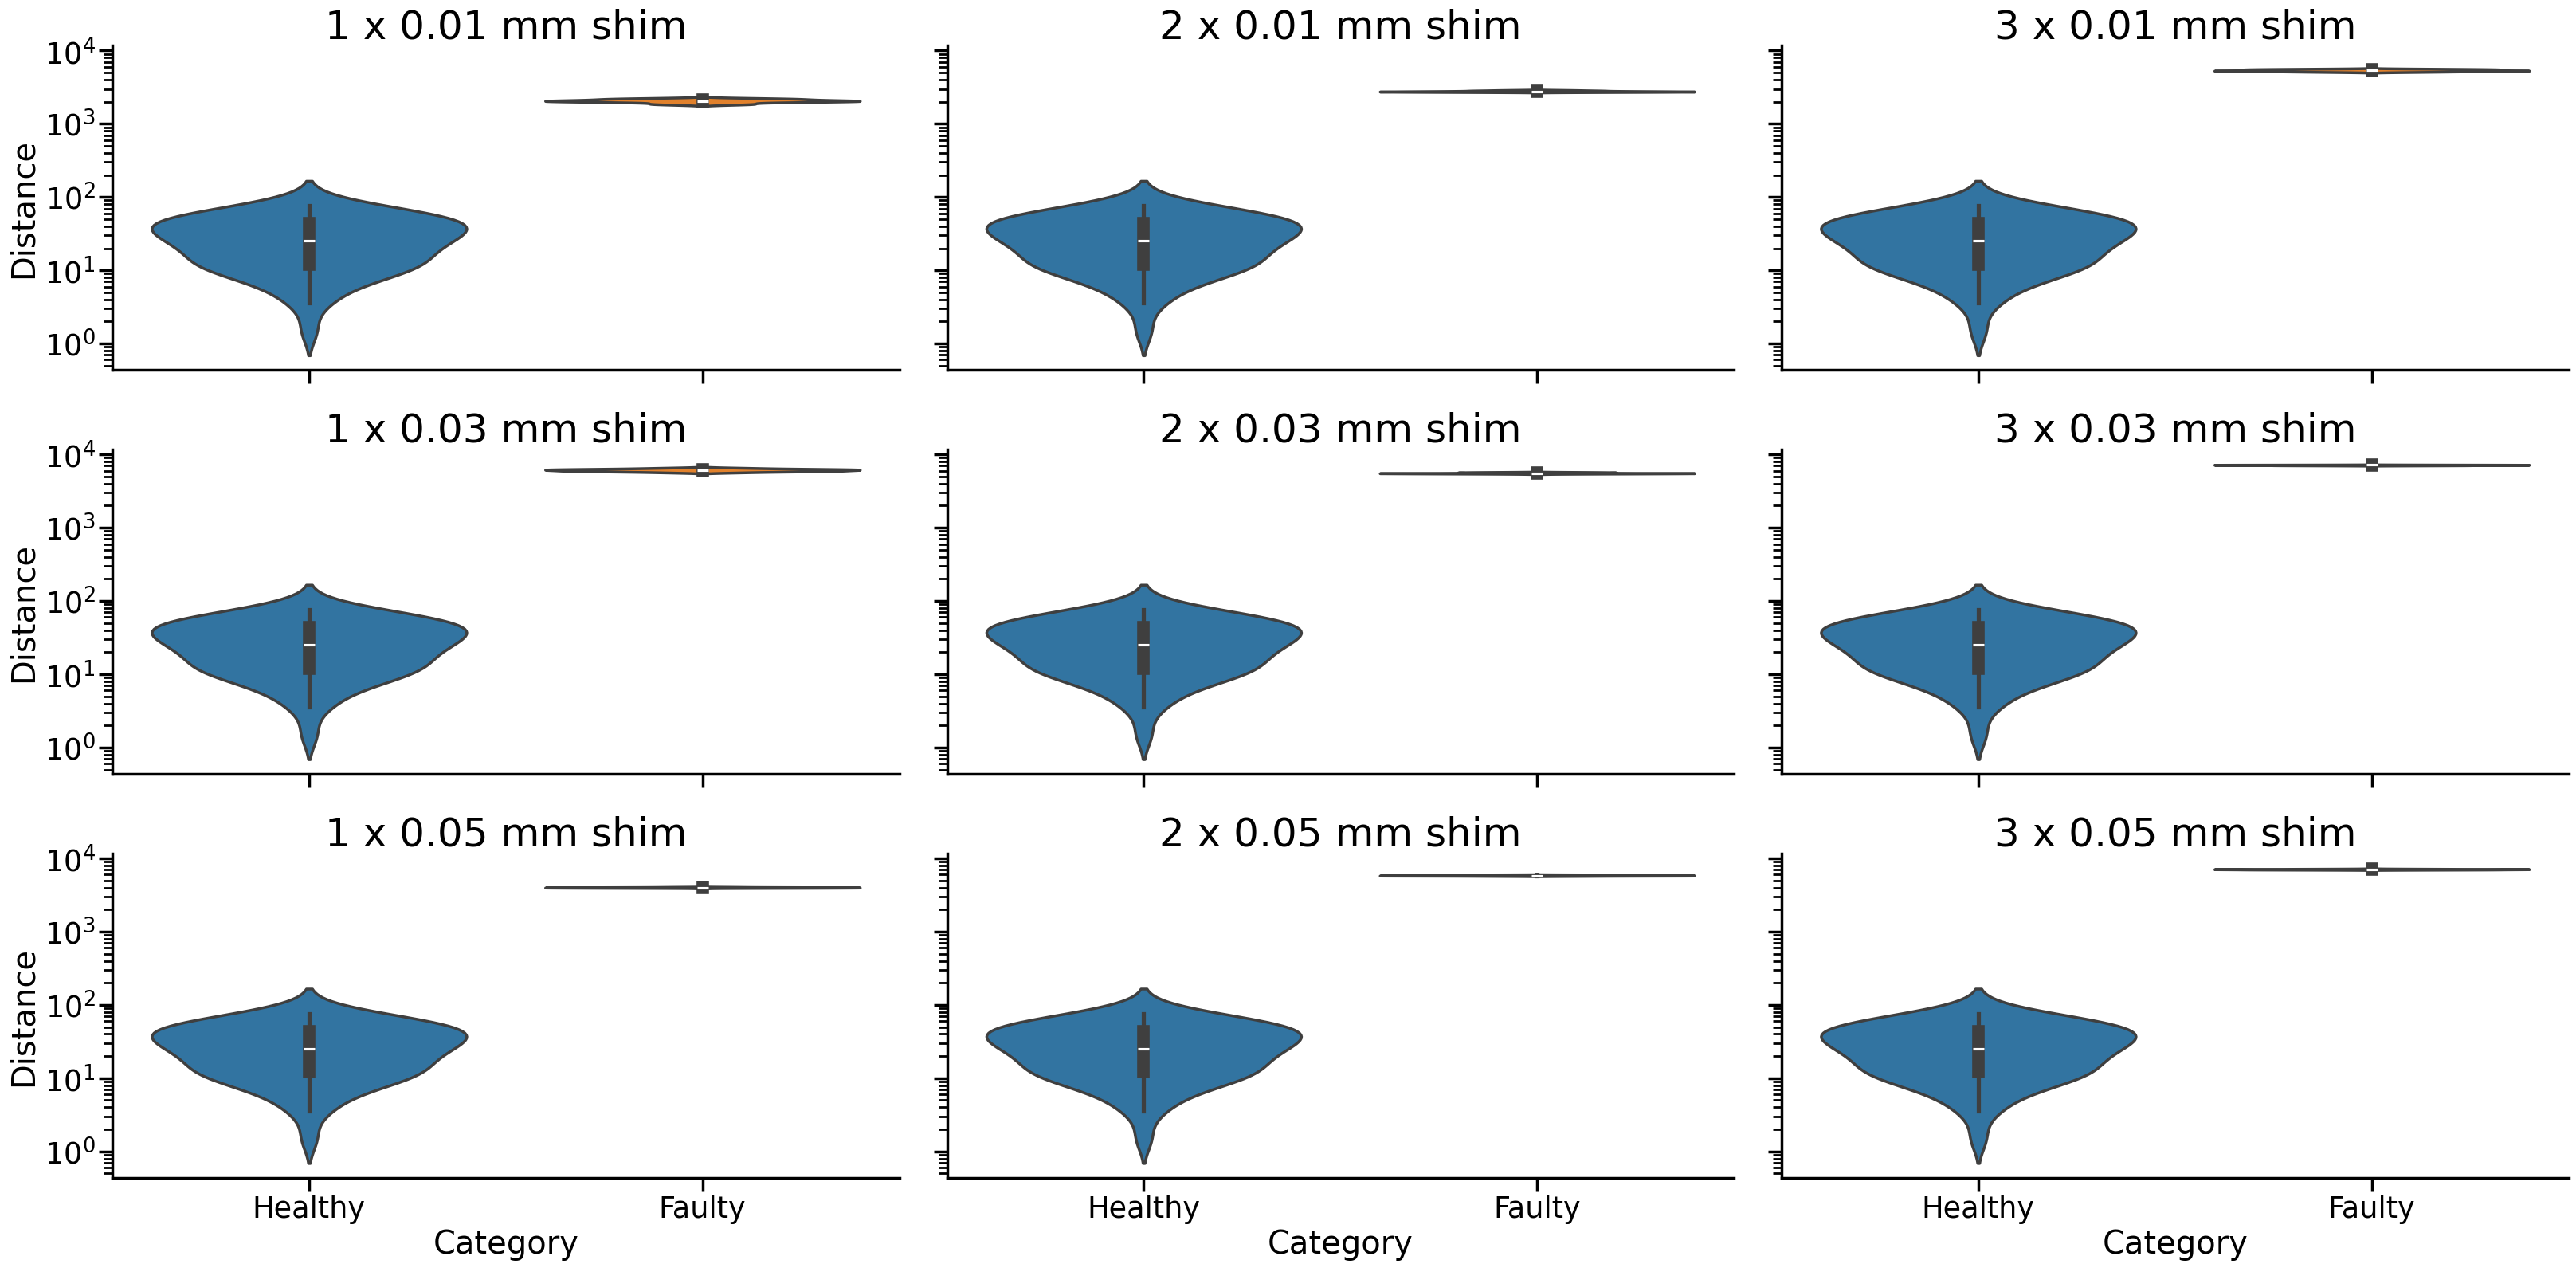

In [84]:
distance_metric = "L2"
# distance_metric = "mahalanobis"

all_support_distances = {}
all_query_healthy_distances = {}
all_query_distances = {}

for fault in faults:
    print(f"> {fault}")
    print("SUPPORT")

    ensemble_support_distances = []
    prototypes = []
    support_inv_cms = []

    # Ensemble loop
    for i in range(ensemble_size):
        prototype = ensemble_support_groups[i].mean(axis=0)
        prototypes.append(prototype)

        # Calculate distance
        if distance_metric == "L2":
            support_distances = distance(prototype, ensemble_support_groups[i])
        elif distance_metric == "mahalanobis":
            support_inv_cm = np.linalg.pinv(
                np.cov(ensemble_support_groups[i], rowvar=False)
            )
            support_inv_cms.append(support_inv_cm)
            support_distances = distance_mahalanobis(
                prototype,
                ensemble_support_groups[i],
                support_inv_cm,
            )
        else:
            raise Exception("WAT")
        ensemble_support_distances.append(support_distances)

    # Ensemble average
    # Support
    mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(axis=-1)
    all_support_distances[f"{fault}"] = mean_support_distances

    print("Mean: {:>8.2f}".format(mean_support_distances.mean()))
    print("Max:  {:>8.2f}".format(mean_support_distances.max()))
    print("Min:  {:>8.2f}".format(mean_support_distances.min()))
    print()

    print("QUERY")

    ensemble_query_healthy_distances = []
    ensemble_query_distances = []

    for i in range(ensemble_size):
        if distance_metric == "L2":
            # Query healthy
            query_healthy_distances = distance(
                prototypes[i],
                ensemble_query_healthy_groups[i],
            )
            # Faults
            query_distances = distance(
                prototypes[i], ensemble_query_groups[i][f"{fault}"]
            )
        elif distance_metric == "mahalanobis":
            # Query healthy
            query_healthy_distances = distance_mahalanobis(
                prototypes[i],
                ensemble_query_healthy_groups[i],
                support_inv_cms[i],
            )
            # Faults
            query_distances = distance_mahalanobis(
                prototypes[i],
                ensemble_query_groups[i][f"{fault}"],
                support_inv_cms[i],
            )
        ensemble_query_healthy_distances.append(query_healthy_distances)
        ensemble_query_distances.append(query_distances)

    # Ensemble averages
    # Query healthy
    mean_query_healthy_distances = np.stack(
        ensemble_query_healthy_distances, axis=-1
    ).mean(axis=-1)
    all_query_healthy_distances[f"{fault}"] = mean_query_healthy_distances

    # Faults
    mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(axis=-1)
    all_query_distances[f"{fault}"] = mean_query_distances

    print(
        "Mean: {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.mean(), mean_query_healthy_distances.mean()
        )
    )
    print(
        "Max:  {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.max(), mean_query_healthy_distances.max()
        )
    )
    print(
        "Min:  {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.min(), mean_query_healthy_distances.min()
        )
    )
    print()

# Plotting
fault_type_map = {
    "1": "1 x 0.01 mm shim",
    "2": "2 x 0.01 mm shim",
    "3": "3 x 0.01 mm shim",
    "4": "1 x 0.03 mm shim",
    "5": "2 x 0.03 mm shim",
    "6": "3 x 0.03 mm shim",
    "7": "1 x 0.05 mm shim",
    "8": "2 x 0.05 mm shim",
    "9": "3 x 0.05 mm shim",
}

df = []
for fault in faults:
    full_fault = f"{fault}"

    # tmp_1 = pd.DataFrame(all_support_distances[full_fault], columns=["distance"])
    # tmp_1["Category"] = "Support"
    # tmp_1["fault"] = full_fault
    tmp_2 = pd.DataFrame(all_query_healthy_distances[full_fault], columns=["Distance"])
    tmp_2["Category"] = "Healthy"
    tmp_2["Fault"] = fault_type_map[full_fault]
    tmp_3 = pd.DataFrame(all_query_distances[full_fault], columns=["Distance"])
    tmp_3["Category"] = "Faulty"
    # tmp_3["Fault"] = full_fault
    tmp_3["Fault"] = fault_type_map[full_fault]

    # df.append(tmp_1)
    df.append(tmp_2)
    df.append(tmp_3)

df = pd.concat(df)

with sns.plotting_context("poster", font_scale=1.2):
    g = sns.catplot(
        df,
        x="Category",
        y="Distance",
        hue="Category",
        col="Fault",
        col_wrap=3,
        log_scale=True,
        height=5.5,
        aspect=2,
        kind="violin",
        # palette=sns.color_palette("Paired"),
        legend=False,
        # width=2.1,
    )
    # plt.tight_layout()
    g.set_titles(col_template="{col_name}", size=36)

    plt.savefig("images/AD_ASD_T1_distances.pdf", format="pdf", bbox_inches="tight")

## Trained w/ AGFD, Acc3


In [85]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

query_data = []
num_repetitions = 10
ensemble_size = 5

for i in range(num_repetitions * ensemble_size):
    query_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                "AD_arotor_acc3_article",
                f"query_{i}.feather",
            )
        )
    )

print("Number of models: ", len(query_data))
print("Queries:", query_data[0].shape)


def distance_mahalanobis(prototype, queries, inv_cm):
    return np.array([mahalanobis(x, prototype, inv_cm) for x in queries])


def distance(prototype, queries):
    return np.sum((queries - prototype) ** 2, axis=1)

Number of models:  50
Queries: (6240, 18)


In [86]:
rpms = [250, 500, 750, 1000, 1250, 1500]
faults = [1, 2, 3, 4, 5, 6, 7, 8, 9]

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

assert (
    len(query_data) == num_repetitions * ensemble_size
), f"len(query_data) != num_repetitions * ensemble_size, {len(query_data)} != {num_repetitions * ensemble_size}"

for i in range(len(query_data)):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for rpm in rpms:
        # SUPPORT #
        support_group = (
            query_data[i][(query_data[i]["rpm"] == rpm) & (query_data[i]["class"] == 0)]
            .drop(
                ["rpm", "class"],
                axis=1,
            )
            .to_numpy()
        )
        # Check if NaNs
        if np.sum(~np.isfinite(support_group)) != 0:
            print("NaN detected in {full_fault}!")
            print(support_group)
            raise

        # * 50/50 split on baseline measurements to support and query
        ensemble_support_groups[i][f"0_{rpm}"] = support_group[
            : support_group.shape[0] // 2
        ]

        # QUERY BASELINE #
        ensemble_query_healthy_groups[i][f"0_{rpm}"] = support_group[
            support_group.shape[0] // 2 :
        ]

        for fault in faults:
            full_fault = f"{fault} {rpm}"

            # QUERY FAULTS #
            query_group = (
                query_data[i][
                    (query_data[i]["rpm"] == rpm) & (query_data[i]["class"] == fault)
                ]
                .drop(
                    ["rpm", "class"],
                    axis=1,
                )
                .to_numpy()
            )

            # Check if NaNs
            if np.sum(~np.isfinite(query_group)) != 0:
                print("NaN detected in {full_fault}!")
                print(query_group)
                raise

            ensemble_query_groups[i][f"{fault}_{rpm}"] = query_group

STATS
28080 / 28080 = 100.0%
28062 / 28080 = 99.93589743589743%
2630 / 56160 = 4.683048433048433%

Accuracy: (28062 + 53530) / (28080 + 56160) = 96.9%
Precision: 53530 / (53530 + 18) = 100.0%
Recall: 53530 / (53530 + 2630) = 95.3%
F1: 0.9758632004958618


[Text(0.5, -2.2833333333333368, 'Predicted label'),
 Text(24.916666666666657, 0.5, 'True label')]

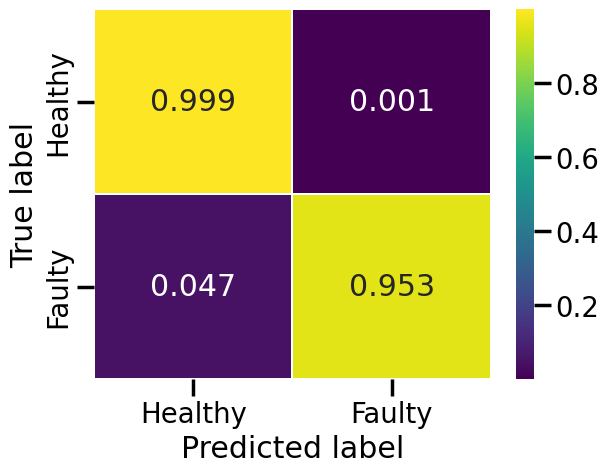

In [87]:
distance_metric = "L2"
# distance_metric = "mahalanobis"


def distance_calculation(
    ensemble_support_groups,
    ensemble_query_healthy_groups,
    ensemble_query_groups,
    distance_metric,
    repetition_offset,
):
    all_support_distances = {}
    all_query_healthy_distances = {}
    all_query_distances = {}

    for rpm in rpms:
        ensemble_support_distances = []
        ensemble_query_healthy_distances = []
        prototypes = []
        support_inv_cms = []

        # Ensemble loop
        for i in range(ensemble_size):
            prototype = ensemble_support_groups[repetition_offset + i][f"0_{rpm}"].mean(
                axis=0
            )
            prototypes.append(prototype)

            # Calculate distance
            if distance_metric == "L2":
                # Support
                support_distances = distance(
                    prototype,
                    ensemble_support_groups[repetition_offset + i][f"0_{rpm}"],
                )
                # Query healthy
                query_healthy_distances = distance(
                    prototypes[i],
                    ensemble_query_healthy_groups[repetition_offset + i][f"0_{rpm}"],
                )
            elif distance_metric == "mahalanobis":
                # Support
                support_inv_cm = np.linalg.pinv(
                    np.cov(
                        ensemble_support_groups[repetition_offset + i][f"0_{rpm}"],
                        rowvar=False,
                    )
                )
                support_inv_cms.append(support_inv_cm)
                support_distances = distance_mahalanobis(
                    prototype,
                    ensemble_support_groups[repetition_offset + i][f"0_{rpm}"],
                    support_inv_cm,
                )
                # Query healthy
                query_healthy_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_healthy_groups[repetition_offset + i][f"0_{rpm}"],
                    support_inv_cms[i],
                )
            else:
                raise Exception("WAT")
            ensemble_support_distances.append(support_distances)
            ensemble_query_healthy_distances.append(query_healthy_distances)

        # Ensemble average
        # Support
        mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(
            axis=-1
        )
        all_support_distances[f"0_{rpm}"] = mean_support_distances
        # Query healthy
        mean_query_healthy_distances = np.stack(
            ensemble_query_healthy_distances, axis=-1
        ).mean(axis=-1)
        all_query_healthy_distances[f"0_{rpm}"] = mean_query_healthy_distances

        for fault in faults:
            ensemble_query_distances = []

            for i in range(ensemble_size):
                if distance_metric == "L2":
                    # Faults
                    query_distances = distance(
                        prototypes[i],
                        ensemble_query_groups[repetition_offset + i][f"{fault}_{rpm}"],
                    )
                elif distance_metric == "mahalanobis":
                    # Faults
                    query_distances = distance_mahalanobis(
                        prototypes[i],
                        ensemble_query_groups[repetition_offset + i][f"{fault}_{rpm}"],
                        support_inv_cms[i],
                    )
                ensemble_query_distances.append(query_distances)

            # Ensemble averages
            mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(
                axis=-1
            )
            all_query_distances[f"{fault}_{rpm}"] = mean_query_distances

    return all_support_distances, all_query_healthy_distances, all_query_distances


repetition_distances = []  # list<(support, query, query_healthy)>

for repetition_offset in range(
    0, num_repetitions * ensemble_size, ensemble_size
):  # range(0, 50, 5)
    repetition_distances.append(
        distance_calculation(
            ensemble_support_groups,
            ensemble_query_healthy_groups,
            ensemble_query_groups,
            # "mahalanobis",
            # "L2",
            distance_metric,
            repetition_offset,
        )
    )

# Thresholding

support_under = 0
query_healthy_under = 0
query_under = 0

support_total = 0
query_healthy_total = 0
query_total = 0

for (
    repetition_support_distances,
    repetition_query_healthy_distances,
    repetition_query_distances,
) in repetition_distances:
    for rpm in rpms:
        for fault in faults:
            full_class = f"{fault}_{rpm}"
            support_class = f"0_{rpm}"

            limit = 4 * np.max(repetition_support_distances[support_class])
            # std = np.std(repetition_support_distances[full_class])
            # limit = 20 * std

            support_under += np.sum(repetition_support_distances[support_class] < limit)
            support_total += len(repetition_support_distances[support_class])

            query_healthy_under += np.sum(
                repetition_query_healthy_distances[support_class] < limit
            )
            query_healthy_total += len(
                repetition_query_healthy_distances[support_class]
            )

            # print(list(repetition_query_distances.keys()))
            # raise
            query_under += np.sum(repetition_query_distances[full_class] < limit)
            query_total += len(repetition_query_distances[full_class])

print("STATS")
print(f"{support_under} / {support_total} = {support_under / support_total * 100}%")
print(
    f"{query_healthy_under} / {query_healthy_total} = {query_healthy_under / query_healthy_total * 100}%"
)
print(f"{query_under} / {query_total} = {query_under / query_total * 100}%")
print()
print(
    f"Accuracy: ({query_healthy_under} + {query_total - query_under}) / ({query_healthy_total} + {query_total}) = {(query_healthy_under + (query_total - query_under)) / (query_healthy_total + query_total) * 100:.1f}%"
)
precision = (query_total - query_under) / (
    (query_total - query_under) + (query_healthy_total - query_healthy_under)
)
print(
    f"Precision: {query_total - query_under} / ({query_total - query_under} + {query_healthy_total - query_healthy_under}) = {precision * 100:.1f}%"
)
recall = (query_total - query_under) / ((query_total - query_under) + query_under)
print(
    f"Recall: {query_total - query_under} / ({query_total - query_under} + {query_under}) = {recall * 100:.1f}%"
)
f1 = 2 / ((1 / precision) + (1 / recall))
print(f"F1: {f1}")

# Plotting

cf_agg = np.array(
    [
        [
            query_healthy_under / query_healthy_total,
            (query_healthy_total - query_healthy_under) / query_healthy_total,
        ],
        [query_under / query_total, (query_total - query_under) / query_total],
    ]
)
categories = ["Healthy", "Faulty"]

ax = sns.heatmap(
    cf_agg,
    annot=True,
    fmt=".3f",
    linewidth=0.3,
    xticklabels=categories,
    yticklabels=categories,
    cmap="viridis",
)
ax.set(xlabel="Predicted label", ylabel="True label")

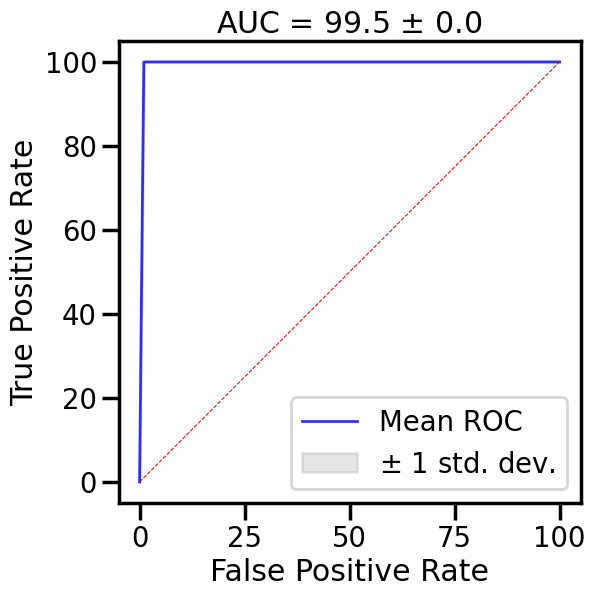

In [88]:
healthy_ds = {}
healthy_labels = {}
for rpm in rpms:
    ds = repetition_query_healthy_distances[f"0_{rpm}"]
    healthy_ds[f"{rpm}"] = ds
    healthy_labels[f"{rpm}"] = np.zeros_like(ds)

faulty_ds = {}
faulty_labels = {}
for rpm in rpms:
    faulty_ds[f"{rpm}"] = []
    faulty_labels[f"{rpm}"] = []

    for fault in faults:
        ds = repetition_query_distances[f"{fault}_{rpm}"]
        faulty_ds[f"{rpm}"].extend(ds)
        faulty_labels[f"{rpm}"].extend(np.ones_like(ds))

cases = []
for rpm in rpms:
    cases.append(
        {
            "labels": np.concatenate(
                [healthy_labels[f"{rpm}"], faulty_labels[f"{rpm}"]]
            ),
            "scores": np.concatenate([healthy_ds[f"{rpm}"], faulty_ds[f"{rpm}"]]),
        }
    )

fig, ax = plt.subplots(figsize=(6, 6))
# fig, ax = plt.subplots(2, 1, figsize=(6, 6))

fprs = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, case in enumerate(cases[:]):
    # print(case["labels"].shape)
    # print(case["scores"].shape)

    # viz = RocCurveDisplay.from_predictions(
    #     case["labels"],
    #     case["scores"],
    #     name=f"_{case_names[i]}",
    #     alpha=0.3,
    #     lw=1,
    #     # ax=ax,
    #     # plot_chance_level=False,
    #     plot_chance_level=(i == len(cases) - 1),
    # )

    fpr, tpr, _ = roc_curve(case["labels"], case["scores"], drop_intermediate=True)
    roc_auc = roc_auc_score(case["labels"], case["scores"])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    # interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    # aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr * 100,
    mean_tpr * 100,
    color="b",
    label=r"Mean ROC",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr * 100,
    tprs_lower * 100,
    tprs_upper * 100,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}",
    # title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}\n(Positive label 'Faulty')",
)
ax.axis("square")
ax.legend(
    loc="lower right",
)
sns.lineplot(
    x=[0, 100], y=[0, 100], color="red", linestyle="dashed", linewidth=0.75, ax=ax
)
plt.savefig("images/AD_ASD_A3_ROC.svg")
plt.show()

### More detailed distances


In [89]:
rpm = 750
faults = [1, 2, 3, 4, 5, 6, 7, 8, 9]

repetition_offset = 0  # * Change this to change between repetitions

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

for i in range(ensemble_size):
    # ensemble_support_groups.append({})
    # ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    # SUPPORT #
    support_group = (
        query_data[repetition_offset + i][
            (
                (query_data[repetition_offset + i]["rpm"] == rpm)
                & (query_data[repetition_offset + i]["class"] == 0)
            )
        ]
        .drop(["rpm", "class"], axis=1)
        .to_numpy()
    )

    ensemble_support_groups.append(support_group[: support_group.shape[0] // 2])
    # ensemble_support_groups[i][rpm] = support_group[: support_group.shape[0] // 2]

    # QUERY BASELINE #
    ensemble_query_healthy_groups.append(support_group[support_group.shape[0] // 2 :])
    # ensemble_query_healthy_groups[i][rpm] = support_group[support_group.shape[0] // 2 :]

    for fault in faults:
        # QUERY FAULTS #
        query_group = (
            query_data[repetition_offset + i][
                (query_data[repetition_offset + i]["rpm"] == rpm)
                & (query_data[repetition_offset + i]["class"] == fault)
            ]
            .drop(["rpm", "class"], axis=1)
            .to_numpy()
        )

        ensemble_query_groups[i][f"{fault}"] = query_group

> 1
SUPPORT
Mean:     3.63
Max:      7.28
Min:      1.17

QUERY
Mean:   298.72 |     7.79
Max:    360.49 |    19.07
Min:    235.76 |     2.89

> 2
SUPPORT
Mean:     3.63
Max:      7.28
Min:      1.17

QUERY
Mean:   295.91 |     7.79
Max:    336.54 |    19.07
Min:    242.27 |     2.89

> 3
SUPPORT
Mean:     3.63
Max:      7.28
Min:      1.17

QUERY
Mean:   331.66 |     7.79
Max:    385.71 |    19.07
Min:    293.76 |     2.89

> 4
SUPPORT
Mean:     3.63
Max:      7.28
Min:      1.17

QUERY
Mean:    87.93 |     7.79
Max:    139.32 |    19.07
Min:     53.77 |     2.89

> 5
SUPPORT
Mean:     3.63
Max:      7.28
Min:      1.17

QUERY
Mean:    76.72 |     7.79
Max:    111.52 |    19.07
Min:     49.16 |     2.89

> 6
SUPPORT
Mean:     3.63
Max:      7.28
Min:      1.17

QUERY
Mean:   170.08 |     7.79
Max:    203.89 |    19.07
Min:    137.96 |     2.89

> 7
SUPPORT
Mean:     3.63
Max:      7.28
Min:      1.17

QUERY
Mean:    75.21 |     7.79
Max:     88.11 |    19.07
Min:     63.06 |     2.89


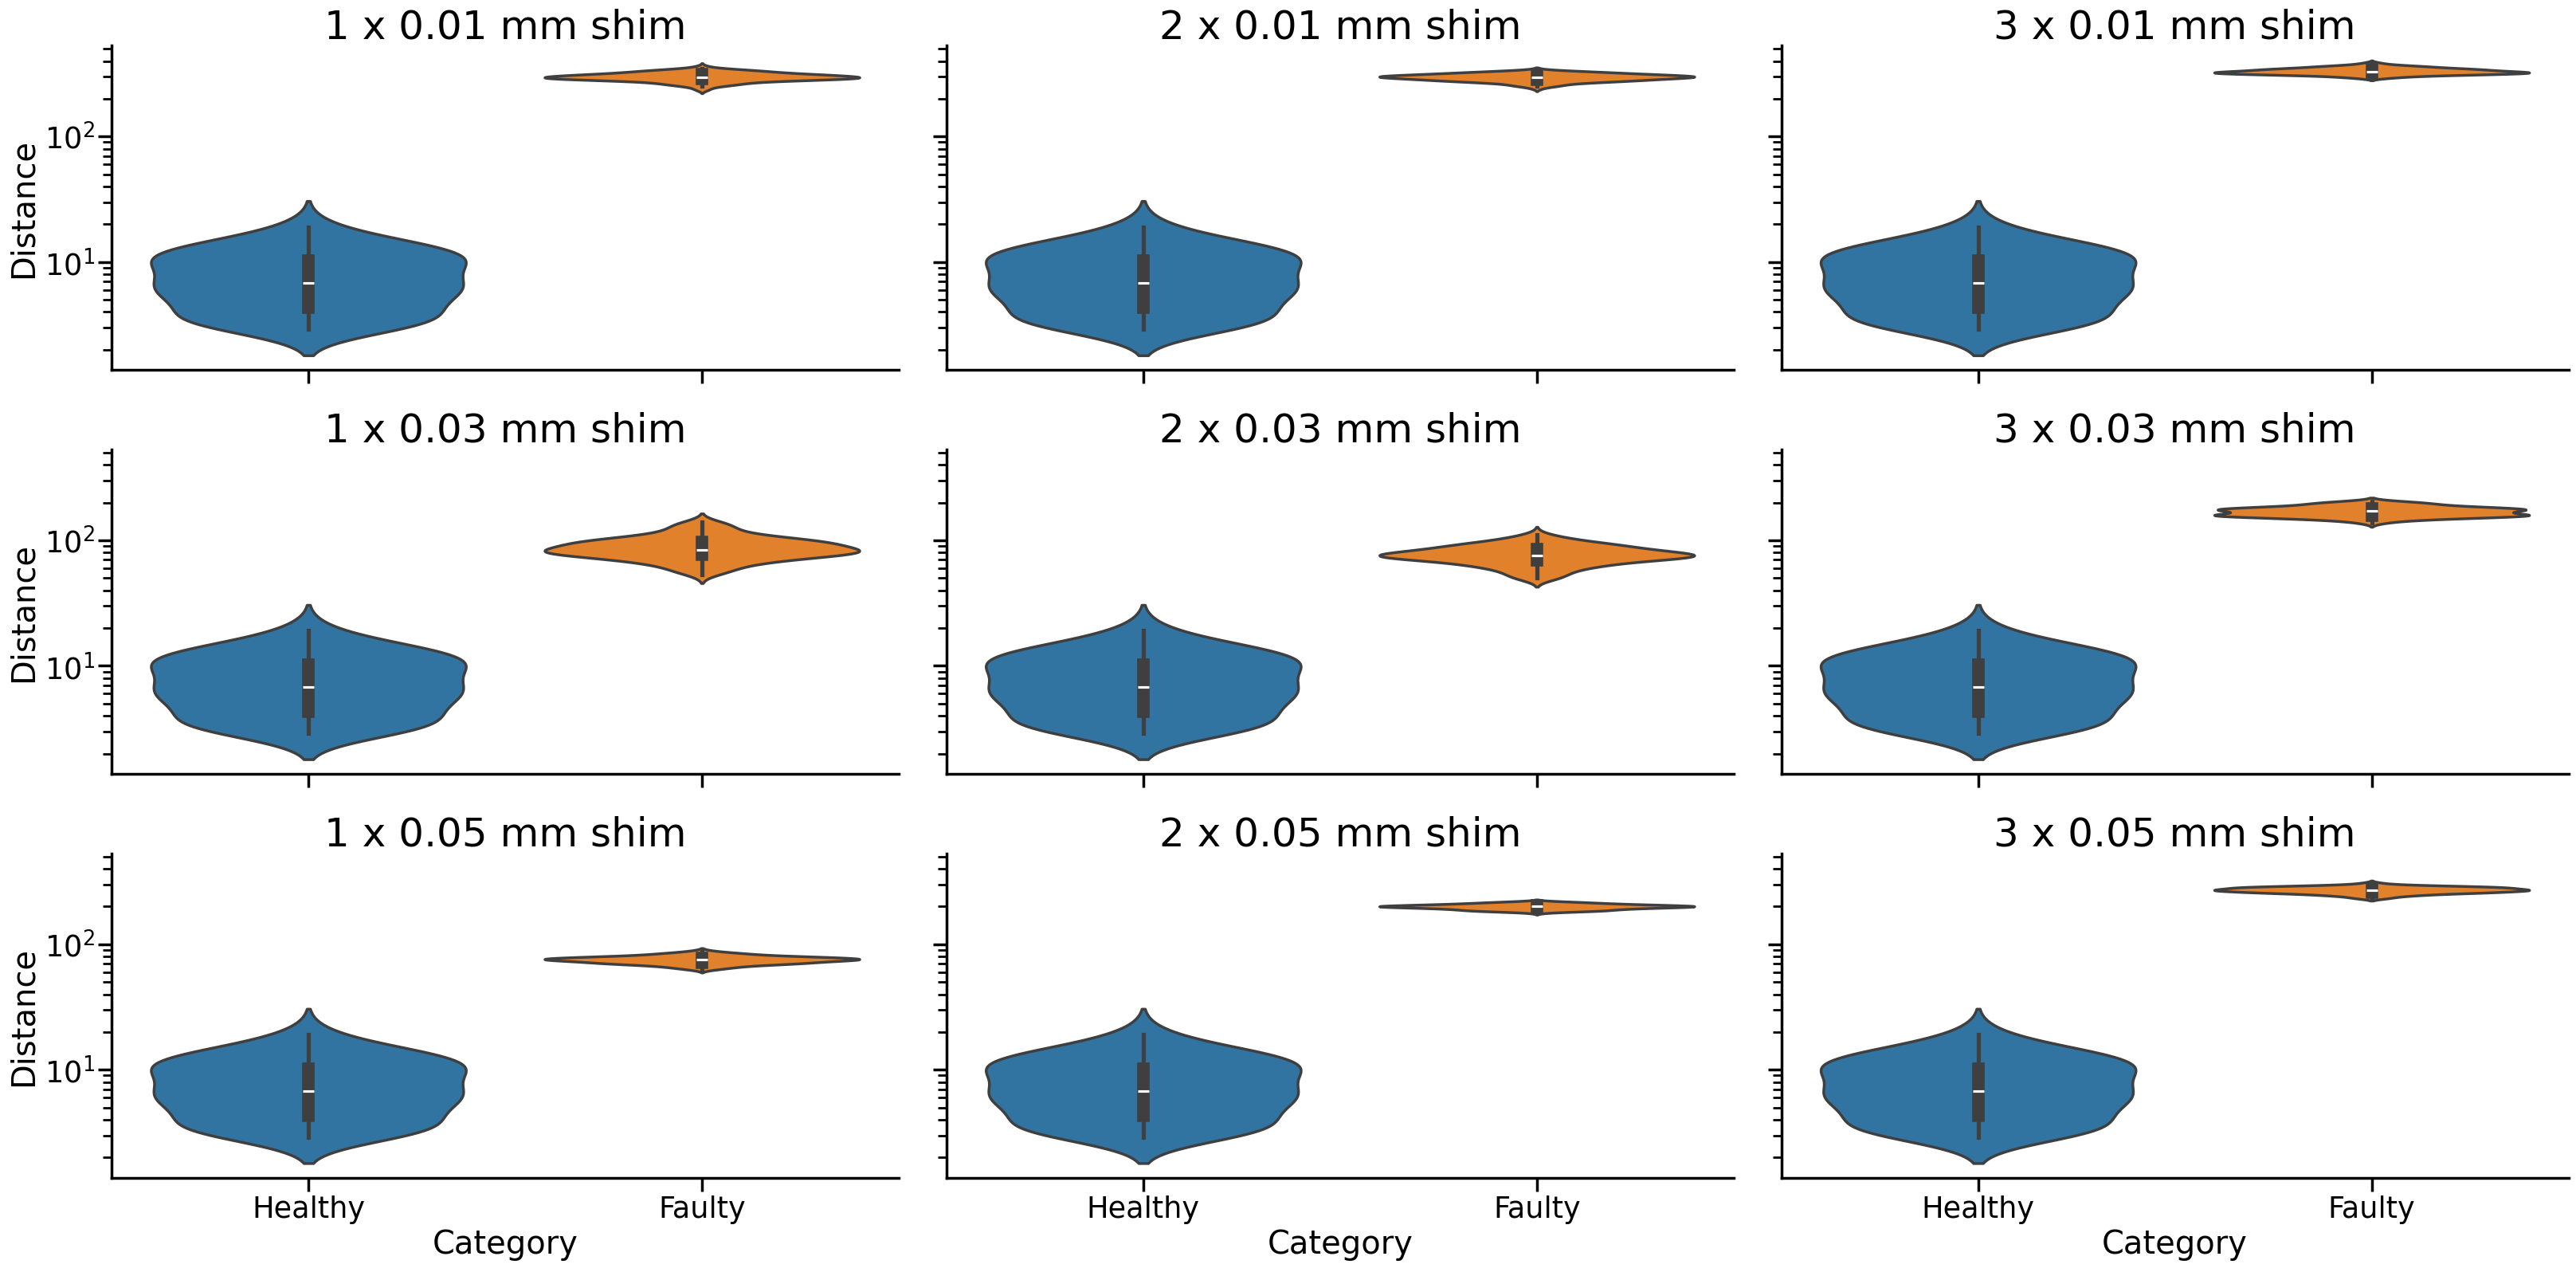

In [90]:
distance_metric = "L2"
# distance_metric = "mahalanobis"

all_support_distances = {}
all_query_healthy_distances = {}
all_query_distances = {}

for fault in faults:
    print(f"> {fault}")
    print("SUPPORT")

    ensemble_support_distances = []
    prototypes = []
    support_inv_cms = []

    # Ensemble loop
    for i in range(ensemble_size):
        prototype = ensemble_support_groups[i].mean(axis=0)
        prototypes.append(prototype)

        # Calculate distance
        if distance_metric == "L2":
            support_distances = distance(prototype, ensemble_support_groups[i])
        elif distance_metric == "mahalanobis":
            support_inv_cm = np.linalg.pinv(
                np.cov(ensemble_support_groups[i], rowvar=False)
            )
            support_inv_cms.append(support_inv_cm)
            support_distances = distance_mahalanobis(
                prototype,
                ensemble_support_groups[i],
                support_inv_cm,
            )
        else:
            raise Exception("WAT")
        ensemble_support_distances.append(support_distances)

    # Ensemble average
    # Support
    mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(axis=-1)
    all_support_distances[f"{fault}"] = mean_support_distances

    print("Mean: {:>8.2f}".format(mean_support_distances.mean()))
    print("Max:  {:>8.2f}".format(mean_support_distances.max()))
    print("Min:  {:>8.2f}".format(mean_support_distances.min()))
    print()

    print("QUERY")

    ensemble_query_healthy_distances = []
    ensemble_query_distances = []

    for i in range(ensemble_size):
        if distance_metric == "L2":
            # Query healthy
            query_healthy_distances = distance(
                prototypes[i],
                ensemble_query_healthy_groups[i],
            )
            # Faults
            query_distances = distance(
                prototypes[i], ensemble_query_groups[i][f"{fault}"]
            )
        elif distance_metric == "mahalanobis":
            # Query healthy
            query_healthy_distances = distance_mahalanobis(
                prototypes[i],
                ensemble_query_healthy_groups[i],
                support_inv_cms[i],
            )
            # Faults
            query_distances = distance_mahalanobis(
                prototypes[i],
                ensemble_query_groups[i][f"{fault}"],
                support_inv_cms[i],
            )
        ensemble_query_healthy_distances.append(query_healthy_distances)
        ensemble_query_distances.append(query_distances)

    # Ensemble averages
    # Query healthy
    mean_query_healthy_distances = np.stack(
        ensemble_query_healthy_distances, axis=-1
    ).mean(axis=-1)
    all_query_healthy_distances[f"{fault}"] = mean_query_healthy_distances

    # Faults
    mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(axis=-1)
    all_query_distances[f"{fault}"] = mean_query_distances

    print(
        "Mean: {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.mean(), mean_query_healthy_distances.mean()
        )
    )
    print(
        "Max:  {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.max(), mean_query_healthy_distances.max()
        )
    )
    print(
        "Min:  {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.min(), mean_query_healthy_distances.min()
        )
    )
    print()

# Plotting
fault_type_map = {
    "1": "1 x 0.01 mm shim",
    "2": "2 x 0.01 mm shim",
    "3": "3 x 0.01 mm shim",
    "4": "1 x 0.03 mm shim",
    "5": "2 x 0.03 mm shim",
    "6": "3 x 0.03 mm shim",
    "7": "1 x 0.05 mm shim",
    "8": "2 x 0.05 mm shim",
    "9": "3 x 0.05 mm shim",
}

df = []
for fault in faults:
    full_fault = f"{fault}"

    # tmp_1 = pd.DataFrame(all_support_distances[full_fault], columns=["distance"])
    # tmp_1["Category"] = "Support"
    # tmp_1["fault"] = full_fault
    tmp_2 = pd.DataFrame(all_query_healthy_distances[full_fault], columns=["Distance"])
    tmp_2["Category"] = "Healthy"
    tmp_2["Fault"] = fault_type_map[full_fault]
    tmp_3 = pd.DataFrame(all_query_distances[full_fault], columns=["Distance"])
    tmp_3["Category"] = "Faulty"
    # tmp_3["Fault"] = full_fault
    tmp_3["Fault"] = fault_type_map[full_fault]

    # df.append(tmp_1)
    df.append(tmp_2)
    df.append(tmp_3)

df = pd.concat(df)

with sns.plotting_context("poster", font_scale=1.2):
    g = sns.catplot(
        df,
        x="Category",
        y="Distance",
        hue="Category",
        col="Fault",
        col_wrap=3,
        log_scale=True,
        height=5.5,
        aspect=2,
        kind="violin",
        # palette=sns.color_palette("Paired"),
        legend=False,
        # width=2.1,
    )
    # plt.tight_layout()
    g.set_titles(col_template="{col_name}", size=36)

    plt.savefig("images/AD_ASD_A3_distances.pdf", format="pdf", bbox_inches="tight")

# Mixed

---


# Trained w/ ASD , Torque1 to Acc3


In [91]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

query_data = []
num_repetitions = 10
ensemble_size = 5

for i in range(num_repetitions * ensemble_size):
    query_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                "AD_arotor_replication_torque1_to_acc3_article",
                f"query_{i}.feather",
            )
        )
    )

print("Number of models: ", len(query_data))
print("Queries:", query_data[0].shape)

fault_GP_map = {
    "mild_micropitting": 4,
    "severe_micropitting": 3,
    "mild_pitting": 1,
    "severe_pitting": 6,
    "mild_wear": 7,
    "severe_wear": 2,
    "mild_tff": 9,
    "severe_tff": 5,
}


def distance_mahalanobis(prototype, queries, inv_cm):
    return np.array([mahalanobis(x, prototype, inv_cm) for x in queries])


def distance(prototype, queries):
    return np.sum((queries - prototype) ** 2, axis=1)

Number of models:  50
Queries: (34017, 21)


In [92]:
rpms = [500, 750, 1250, 1500]
# rpm = 1500
torques = [1, 6, 11]
severities = ["mild", "severe"]
faults = ["micropitting", "pitting", "wear", "tff"]
# installation = [1]
installation = [1, 2]
# GPs = [2, 3, 5, 6]

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

assert (
    len(query_data) == num_repetitions * ensemble_size
), f"len(query_data) != num_repetitions * ensemble_size, {len(query_data)} != {num_repetitions * ensemble_size}"

for i in range(len(query_data)):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    full_fault = f"{severity} {fault} {rpm} {torque}"
                    # SUPPORT #
                    support_group = (
                        query_data[i][
                            (query_data[i]["rpm"] == rpm)
                            & (
                                query_data[i]["severity"]
                                == str(fault_GP_map[f"{severity}_{fault}"])
                            )
                            & (query_data[i]["torque"] == torque)
                        ]
                        .drop(
                            ["rpm", "severity", "fault", "installation", "torque"],
                            axis=1,
                        )
                        .to_numpy()
                    )
                    # Check if NaNs
                    if np.sum(~np.isfinite(support_group)) != 0:
                        print("NaN detected in {full_fault}!")
                        print(support_group)
                        raise

                    # * 50/50 split on baseline measurements to support and query
                    ensemble_support_groups[i][f"{severity}_{fault}_{rpm}_{torque}"] = (
                        support_group[: support_group.shape[0] // 2]
                    )

                    # QUERY BASELINE #
                    ensemble_query_healthy_groups[i][
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = support_group[support_group.shape[0] // 2 :]

                    # QUERY FAULTS #
                    query_group = (
                        query_data[i][
                            (query_data[i]["rpm"] == rpm)
                            & (query_data[i]["severity"] == severity)
                            & (query_data[i]["torque"] == torque)
                            & (query_data[i]["installation"].isin(installation))
                            & (query_data[i]["fault"] == fault)
                        ]
                        .drop(
                            ["rpm", "severity", "fault", "installation", "torque"],
                            axis=1,
                        )
                        .to_numpy()
                    )

                    # Check if NaNs
                    if np.sum(~np.isfinite(query_group)) != 0:
                        print("NaN detected in {full_fault}!")
                        print(query_group)
                        raise

                    ensemble_query_groups[i][
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = query_group

STATS
33880 / 33880 = 100.0%
33455 / 34270 = 97.62182667055734%
8877 / 263500 = 3.3688804554079694%

Accuracy: (33455 + 254623) / (34270 + 263500) = 96.7%
Precision: 254623 / (254623 + 815) = 99.7%
Recall: 254623 / (254623 + 8877) = 96.6%
F1: 0.9813233950876598


[Text(0.5, -2.2833333333333368, 'Predicted label'),
 Text(24.916666666666657, 0.5, 'True label')]

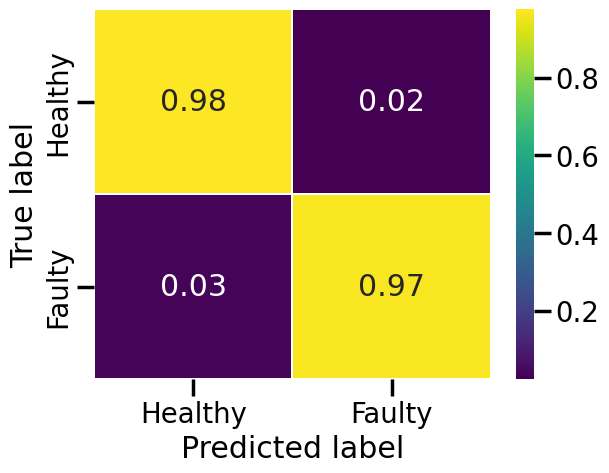

In [93]:
def distance_calculation(
    ensemble_support_groups,
    ensemble_query_healthy_groups,
    ensemble_query_groups,
    distance_metric,
    repetition_offset,
):
    all_support_distances = {}
    all_query_healthy_distances = {}
    all_query_distances = {}

    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    # print(f"> {severity} {fault} {rpm} {torque}")
                    # print("SUPPORT")

                    ensemble_support_distances = []
                    prototypes = []
                    support_inv_cms = []

                    # Ensemble loop
                    for i in range(ensemble_size):
                        prototype = ensemble_support_groups[repetition_offset + i][
                            f"{severity}_{fault}_{rpm}_{torque}"
                        ].mean(axis=0)
                        prototypes.append(prototype)

                        # Calculate distance
                        if distance_metric == "L2":
                            support_distances = distance(
                                prototype,
                                ensemble_support_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                        elif distance_metric == "mahalanobis":
                            support_inv_cm = np.linalg.pinv(
                                np.cov(
                                    ensemble_support_groups[repetition_offset + i][
                                        f"{severity}_{fault}_{rpm}_{torque}"
                                    ],
                                    rowvar=False,
                                )
                            )
                            support_inv_cms.append(support_inv_cm)
                            support_distances = distance_mahalanobis(
                                prototype,
                                ensemble_support_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cm,
                            )
                        else:
                            raise Exception("WAT")
                        ensemble_support_distances.append(support_distances)

                    # Ensemble average
                    mean_support_distances = np.stack(
                        ensemble_support_distances, axis=-1
                    ).mean(axis=-1)
                    all_support_distances[f"{severity}_{fault}_{rpm}_{torque}"] = (
                        mean_support_distances
                    )

                    # print("QUERY")

                    ensemble_query_healthy_distances = []
                    ensemble_query_distances = []

                    for i in range(ensemble_size):
                        if distance_metric == "L2":
                            # Query healthy
                            query_healthy_distances = distance(
                                prototypes[i],
                                ensemble_query_healthy_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                            # Faults
                            query_distances = distance(
                                prototypes[i],
                                ensemble_query_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                        elif distance_metric == "mahalanobis":
                            # Query healthy
                            query_healthy_distances = distance_mahalanobis(
                                prototypes[i],
                                ensemble_query_healthy_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cms[i],
                            )
                            # Faults
                            query_distances = distance_mahalanobis(
                                prototypes[i],
                                ensemble_query_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cms[i],
                            )
                        ensemble_query_healthy_distances.append(query_healthy_distances)
                        ensemble_query_distances.append(query_distances)

                    # Ensemble averages
                    mean_query_healthy_distances = np.stack(
                        ensemble_query_healthy_distances, axis=-1
                    ).mean(axis=-1)
                    all_query_healthy_distances[
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = mean_query_healthy_distances

                    mean_query_distances = np.stack(
                        ensemble_query_distances, axis=-1
                    ).mean(axis=-1)
                    all_query_distances[f"{severity}_{fault}_{rpm}_{torque}"] = (
                        mean_query_distances
                    )

    return all_support_distances, all_query_healthy_distances, all_query_distances


repetition_distances = []  # list<(support, query, query_healthy)>

for repetition_offset in range(
    0, num_repetitions * ensemble_size, ensemble_size
):  # range(0, 25, 5)
    repetition_distances.append(
        distance_calculation(
            ensemble_support_groups,
            ensemble_query_healthy_groups,
            ensemble_query_groups,
            # "mahalanobis",
            "L2",
            repetition_offset,
        )
    )

# Thresholding

support_under = 0
query_healthy_under = 0
query_under = 0

support_total = 0
query_healthy_total = 0
query_total = 0

for (
    repetition_support_distances,
    repetition_query_healthy_distances,
    repetition_query_distances,
) in repetition_distances:
    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    full_class = f"{severity}_{fault}_{rpm}_{torque}"

                    limit = 1.5 * np.max(repetition_support_distances[full_class])
                    # limit = 5 * np.std(repetition_support_distances[full_class])

                    support_under += np.sum(
                        repetition_support_distances[full_class] < limit
                    )
                    support_total += len(repetition_support_distances[full_class])

                    query_healthy_under += np.sum(
                        repetition_query_healthy_distances[full_class] < limit
                    )
                    query_healthy_total += len(
                        repetition_query_healthy_distances[full_class]
                    )

                    query_under += np.sum(
                        repetition_query_distances[full_class] < limit
                    )
                    query_total += len(repetition_query_distances[full_class])

print("STATS")
print(f"{support_under} / {support_total} = {support_under / support_total * 100}%")
print(
    f"{query_healthy_under} / {query_healthy_total} = {query_healthy_under / query_healthy_total * 100}%"
)
print(f"{query_under} / {query_total} = {query_under / query_total * 100}%")
print()
print(
    f"Accuracy: ({query_healthy_under} + {query_total - query_under}) / ({query_healthy_total} + {query_total}) = {(query_healthy_under + (query_total - query_under)) / (query_healthy_total + query_total) * 100:.1f}%"
)
precision = (query_total - query_under) / (
    (query_total - query_under) + (query_healthy_total - query_healthy_under)
)
print(
    f"Precision: {query_total - query_under} / ({query_total - query_under} + {query_healthy_total - query_healthy_under}) = {precision * 100:.1f}%"
)
recall = (query_total - query_under) / ((query_total - query_under) + query_under)
print(
    f"Recall: {query_total - query_under} / ({query_total - query_under} + {query_under}) = {recall * 100:.1f}%"
)
f1 = 2 / ((1 / precision) + (1 / recall))
print(f"F1: {f1}")

# Plotting

cf_agg = np.array(
    [
        [
            query_healthy_under / query_healthy_total,
            (query_healthy_total - query_healthy_under) / query_healthy_total,
        ],
        [query_under / query_total, (query_total - query_under) / query_total],
    ]
)
categories = ["Healthy", "Faulty"]

ax = sns.heatmap(
    cf_agg,
    annot=True,
    fmt=".2f",
    linewidth=0.3,
    xticklabels=categories,
    yticklabels=categories,
    cmap="viridis",
)
ax.set(xlabel="Predicted label", ylabel="True label")

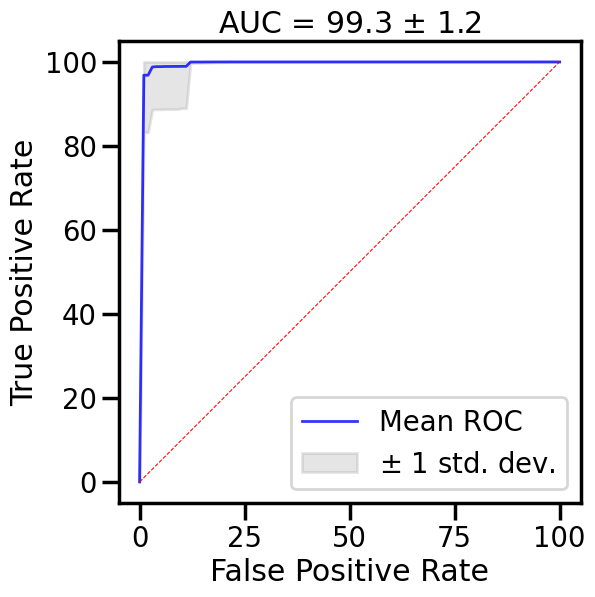

In [94]:
healthy = [
    np.array([x, np.zeros_like(x)]) for x in repetition_query_healthy_distances.values()
]
query = [np.array([x, np.ones_like(x)]) for x in repetition_query_distances.values()]

case_names = list(repetition_query_healthy_distances.keys())

cases = []
for i in range(len(healthy)):
    cases.append(
        {
            "labels": np.concatenate([healthy[i][1], query[i][1]]),
            "scores": np.concatenate([healthy[i][0], query[i][0]]),
        }
    )

fig, ax = plt.subplots(figsize=(6, 6))
# fig, ax = plt.subplots(2, 1, figsize=(6, 6))

fprs = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, case in enumerate(cases[:]):
    # print(case["labels"].shape)
    # print(case["scores"].shape)

    # viz = RocCurveDisplay.from_predictions(
    #     case["labels"],
    #     case["scores"],
    #     name=f"_{case_names[i]}",
    #     alpha=0.3,
    #     lw=1,
    #     # ax=ax,
    #     # plot_chance_level=False,
    #     plot_chance_level=(i == len(cases) - 1),
    # )

    fpr, tpr, _ = roc_curve(case["labels"], case["scores"], drop_intermediate=True)
    roc_auc = roc_auc_score(case["labels"], case["scores"])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    # interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    # aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr * 100,
    mean_tpr * 100,
    color="b",
    label=r"Mean ROC",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr * 100,
    tprs_lower * 100,
    tprs_upper * 100,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}",
    # title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}\n(Positive label 'Faulty')",
    # title=f"Mean ROC curve with variability\n(Positive label 'Faulty')",
)
ax.axis("square")
ax.legend(
    loc="lower right",
)
sns.lineplot(
    x=[0, 100], y=[0, 100], color="red", linestyle="dashed", linewidth=0.75, ax=ax
)
plt.savefig("images/AD_AGFD_T1_to_A3_ROC.svg")
plt.show()

### More detailed distances


In [95]:
rpm = 750
faults = ["micropitting", "pitting", "wear", "tff"]
installation = [1, 2]
torque = 6

repetition_offset = 0  # * Change this to change between repetitions

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

for i in range(ensemble_size):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for fault in faults:
        for severity in severities:
            # SUPPORT #
            support_group = (
                query_data[repetition_offset + i][
                    (query_data[repetition_offset + i]["rpm"] == rpm)
                    & (
                        query_data[repetition_offset + i]["severity"]
                        == str(fault_GP_map[f"{severity}_{fault}"])
                    )
                    & (query_data[repetition_offset + i]["torque"] == torque)
                ]
                .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
                .to_numpy()
            )

            ensemble_support_groups[i][f"{severity}_{fault}"] = support_group[
                : support_group.shape[0] // 2
            ]

            # QUERY BASELINE #
            ensemble_query_healthy_groups[i][f"{severity}_{fault}"] = support_group[
                support_group.shape[0] // 2 :
            ]

            # QUERY FAULTS #
            query_group = (
                query_data[repetition_offset + i][
                    (query_data[repetition_offset + i]["rpm"] == rpm)
                    & (query_data[repetition_offset + i]["severity"] == severity)
                    & (query_data[repetition_offset + i]["torque"] == torque)
                    & (
                        query_data[repetition_offset + i]["installation"].isin(
                            installation
                        )
                    )
                    & (query_data[repetition_offset + i]["fault"] == fault)
                ]
                .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
                .to_numpy()
            )

            ensemble_query_groups[i][f"{severity}_{fault}"] = query_group

> mild micropitting
SUPPORT
Mean:     0.97
Max:      3.01
Min:      0.34

QUERY
Mean:    56.11 |     1.27
Max:     96.66 |     4.11
Min:     24.11 |     0.30

> severe micropitting
SUPPORT
Mean:     1.26
Max:      3.10
Min:      0.42

QUERY
Mean:   146.09 |     1.75
Max:    237.85 |     3.91
Min:     59.09 |     0.54

> mild pitting
SUPPORT
Mean:     0.79
Max:      2.63
Min:      0.17

QUERY
Mean:    32.22 |     0.97
Max:     66.15 |     2.50
Min:      4.71 |     0.21

> severe pitting
SUPPORT
Mean:     1.03
Max:      2.77
Min:      0.42

QUERY
Mean:    38.27 |     1.21
Max:     59.45 |     2.83
Min:     20.86 |     0.33

> mild wear
SUPPORT
Mean:     0.79
Max:      1.48
Min:      0.23

QUERY
Mean:    40.93 |     0.88
Max:     76.35 |     2.14
Min:     21.15 |     0.41

> severe wear
SUPPORT
Mean:     0.85
Max:      1.79
Min:      0.28

QUERY
Mean:    32.25 |     1.05
Max:     57.60 |     2.94
Min:     15.45 |     0.40

> mild tff
SUPPORT
Mean:     1.26
Max:      3.90
Min:      0.27

Q

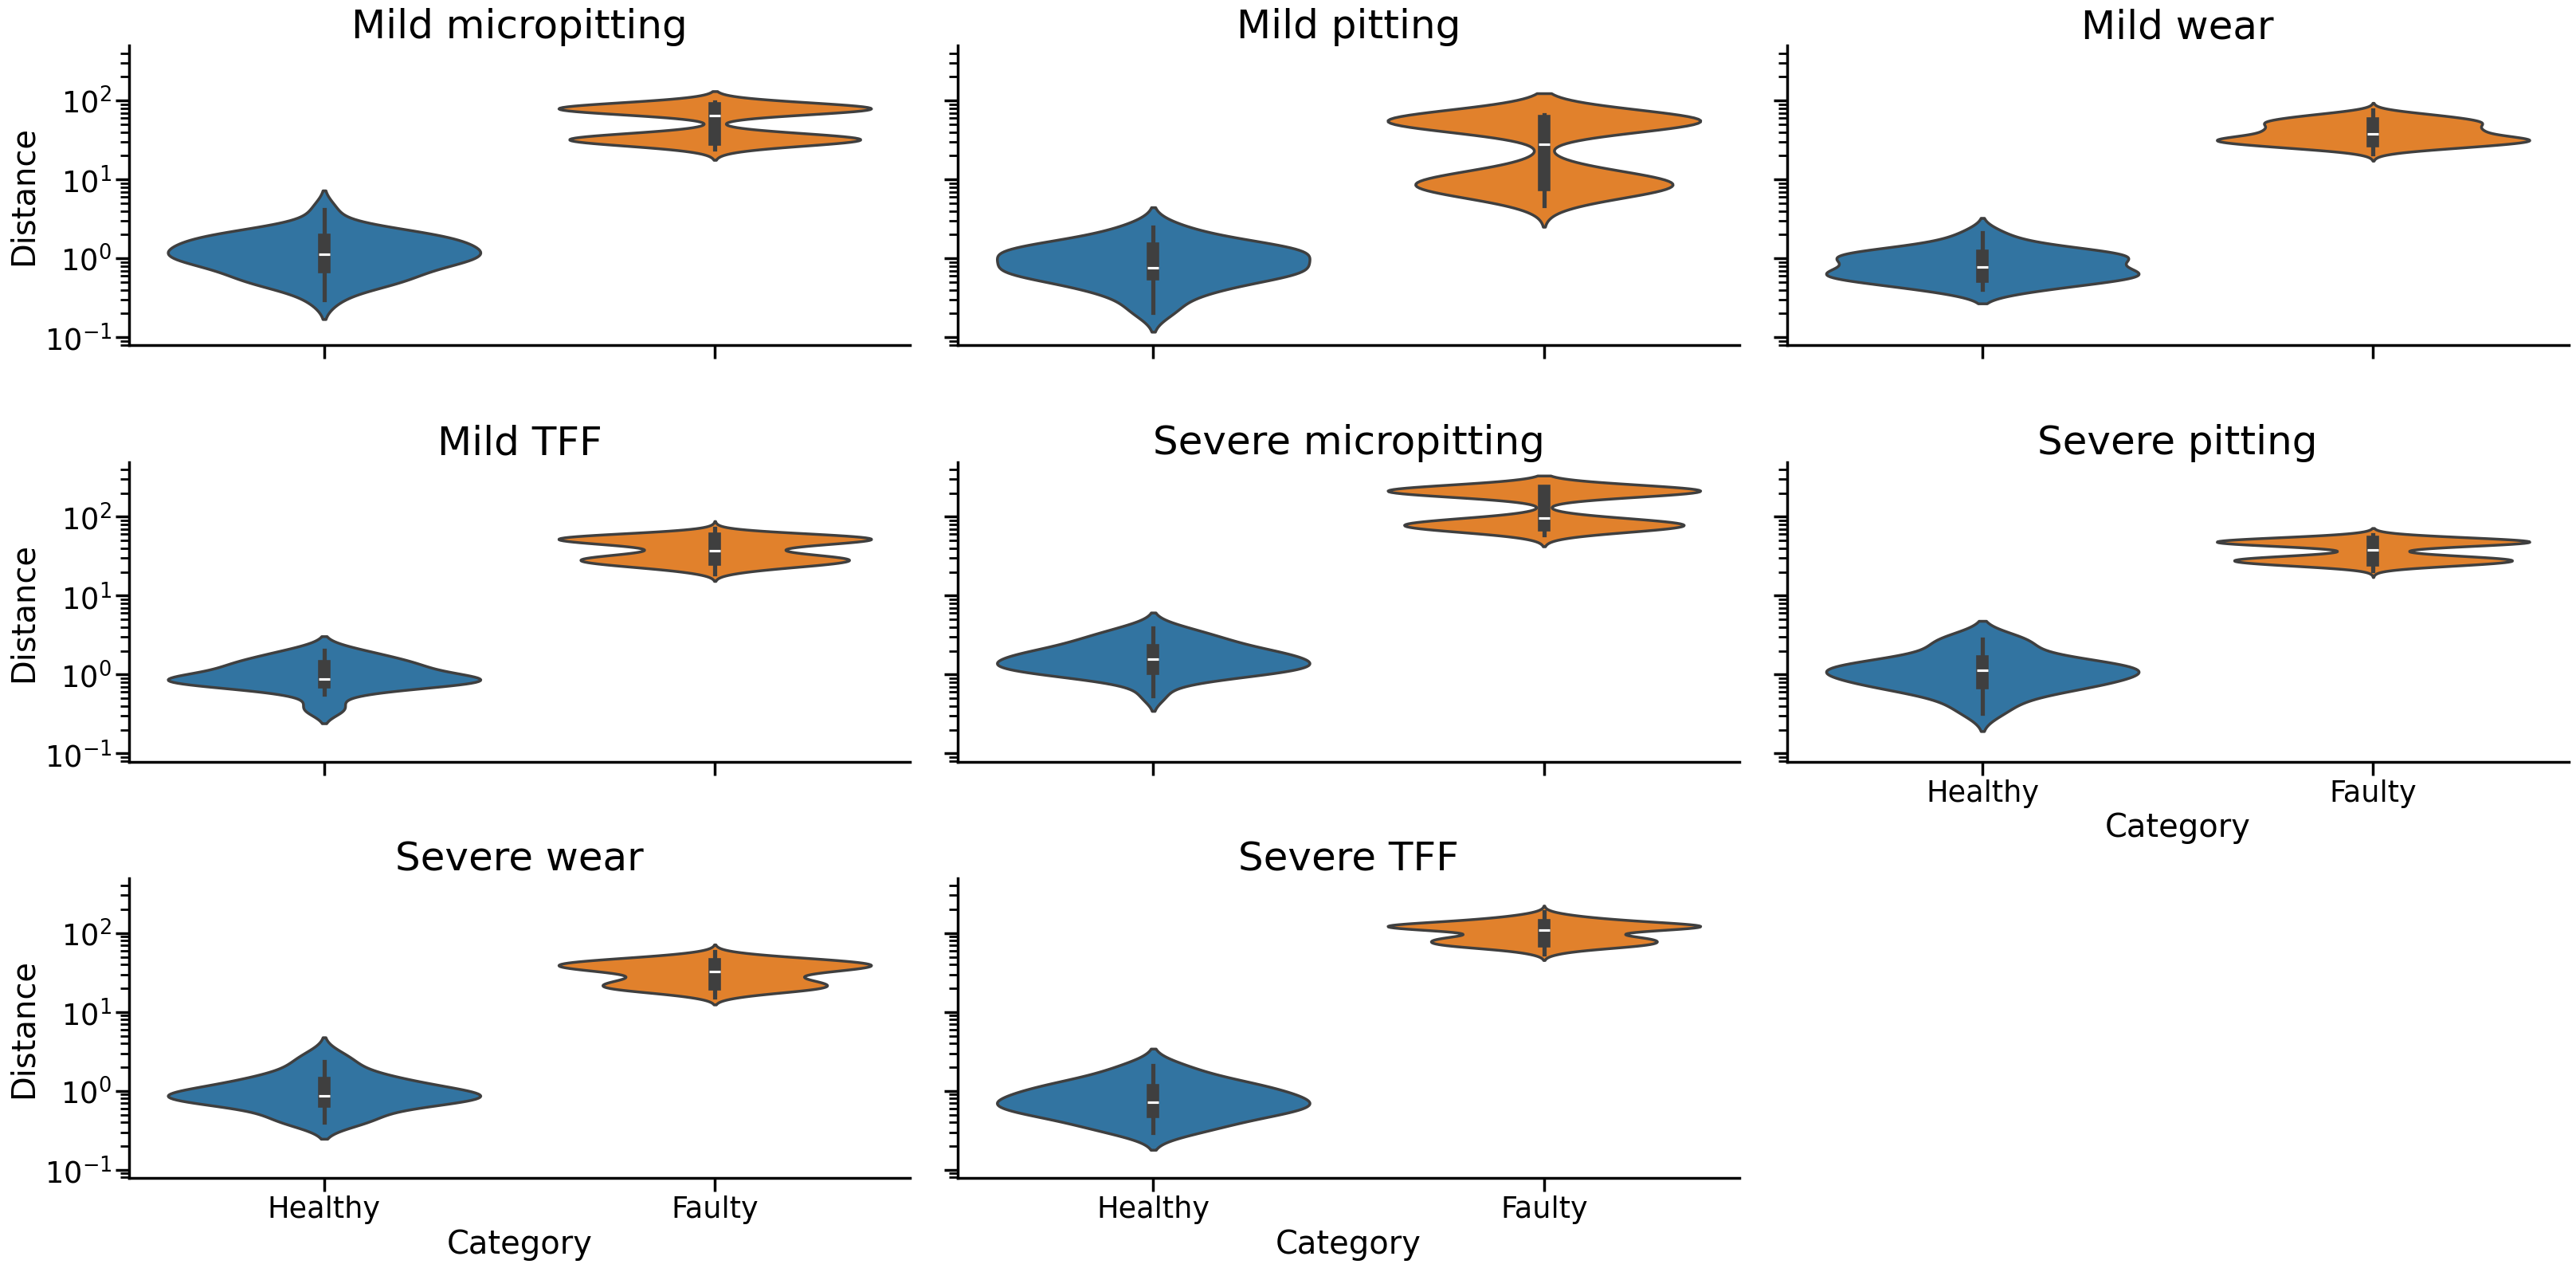

In [96]:
distance_metric = "L2"
# distance_metric = "mahalanobis"

all_support_distances = {}
all_query_healthy_distances = {}
all_query_distances = {}

for fault in faults:
    for severity in severities:
        print(f"> {severity} {fault}")
        print("SUPPORT")

        ensemble_support_distances = []
        prototypes = []
        support_inv_cms = []

        # Ensemble loop
        for i in range(ensemble_size):
            prototype = ensemble_support_groups[i][f"{severity}_{fault}"].mean(axis=0)
            prototypes.append(prototype)

            # Calculate distance
            if distance_metric == "L2":
                support_distances = distance(
                    prototype, ensemble_support_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                support_inv_cm = np.linalg.pinv(
                    np.cov(
                        ensemble_support_groups[i][f"{severity}_{fault}"], rowvar=False
                    )
                )
                support_inv_cms.append(support_inv_cm)
                support_distances = distance_mahalanobis(
                    prototype,
                    ensemble_support_groups[i][f"{severity}_{fault}"],
                    support_inv_cm,
                )
            else:
                raise Exception("WAT")
            ensemble_support_distances.append(support_distances)

        # Ensemble average
        mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(
            axis=-1
        )
        all_support_distances[f"{severity}_{fault}"] = mean_support_distances

        print("Mean: {:>8.2f}".format(mean_support_distances.mean()))
        print("Max:  {:>8.2f}".format(mean_support_distances.max()))
        print("Min:  {:>8.2f}".format(mean_support_distances.min()))
        print()

        print("QUERY")

        ensemble_query_healthy_distances = []
        ensemble_query_distances = []

        for i in range(ensemble_size):
            if distance_metric == "L2":
                # Query healthy
                query_healthy_distances = distance(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                )
                # Faults
                query_distances = distance(
                    prototypes[i], ensemble_query_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                # Query healthy
                query_healthy_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
                # Faults
                query_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
            ensemble_query_healthy_distances.append(query_healthy_distances)
            ensemble_query_distances.append(query_distances)

        # Ensemble averages
        mean_query_healthy_distances = np.stack(
            ensemble_query_healthy_distances, axis=-1
        ).mean(axis=-1)
        all_query_healthy_distances[f"{severity}_{fault}"] = (
            mean_query_healthy_distances
        )

        mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(axis=-1)
        all_query_distances[f"{severity}_{fault}"] = mean_query_distances

        print(
            "Mean: {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.mean(), mean_query_healthy_distances.mean()
            )
        )
        print(
            "Max:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.max(), mean_query_healthy_distances.max()
            )
        )
        print(
            "Min:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.min(), mean_query_healthy_distances.min()
            )
        )
        print()

# Plotting

df = []
for severity in severities:
    for fault in faults:
        full_fault = f"{severity}_{fault}"

        # tmp_1 = pd.DataFrame(all_support_distances[full_fault], columns=["distance"])
        # tmp_1["category"] = "Support"
        # tmp_1["fault"] = full_fault
        tmp_2 = pd.DataFrame(
            all_query_healthy_distances[full_fault], columns=["Distance"]
        )
        tmp_2["Category"] = "Healthy"
        tmp_2["Fault"] = full_fault.replace("_", " ").capitalize().replace("tff", "TFF")
        tmp_3 = pd.DataFrame(all_query_distances[full_fault], columns=["Distance"])
        tmp_3["Category"] = "Faulty"
        # tmp_3["Category"] = "Faulty"
        tmp_3["Fault"] = full_fault.replace("_", " ").capitalize().replace("tff", "TFF")

        # df.append(tmp_1)
        df.append(tmp_2)
        df.append(tmp_3)

df = pd.concat(df)
# print(df)
# raise

# fig, ax = plt.subplots(figsize=(6.5, 6))
with sns.plotting_context("poster", font_scale=1.2):
    g = sns.catplot(
        df,
        x="Category",
        y="Distance",
        hue="Category",
        col="Fault",
        col_wrap=3,
        log_scale=True,
        height=5.5,
        aspect=2,
        kind="violin",
        # palette=sns.color_palette("Paired"),
        legend=False,
        # width=2.1,
    )
    # plt.tight_layout()
    g.set_titles(col_template="{col_name}", size=36)

    plt.savefig(
        "images/AD_AGFD_T1_to_A3_distances.pdf", format="pdf", bbox_inches="tight"
    )

# Trained w/ ASD , Acc3 to Torque1


In [97]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

query_data = []
num_repetitions = 10
ensemble_size = 5

for i in range(num_repetitions * ensemble_size):
    query_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                "AD_arotor_replication_acc3_to_torque1_article",
                f"query_{i}.feather",
            )
        )
    )

print("Number of models: ", len(query_data))
print("Queries:", query_data[0].shape)

fault_GP_map = {
    "mild_micropitting": 4,
    "severe_micropitting": 3,
    "mild_pitting": 1,
    "severe_pitting": 6,
    "mild_wear": 7,
    "severe_wear": 2,
    "mild_tff": 9,
    "severe_tff": 5,
}


def distance_mahalanobis(prototype, queries, inv_cm):
    return np.array([mahalanobis(x, prototype, inv_cm) for x in queries])


def distance(prototype, queries):
    return np.sum((queries - prototype) ** 2, axis=1)

Number of models:  50
Queries: (34017, 21)


In [98]:
rpms = [500, 750, 1250, 1500]
# rpm = 1500
torques = [1, 6, 11]
severities = ["mild", "severe"]
faults = ["micropitting", "pitting", "wear", "tff"]
# installation = [1]
installation = [1, 2]
# GPs = [2, 3, 5, 6]

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

assert (
    len(query_data) == num_repetitions * ensemble_size
), f"len(query_data) != num_repetitions * ensemble_size, {len(query_data)} != {num_repetitions * ensemble_size}"

for i in range(len(query_data)):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    full_fault = f"{severity} {fault} {rpm} {torque}"
                    # SUPPORT #
                    support_group = (
                        query_data[i][
                            (query_data[i]["rpm"] == rpm)
                            & (
                                query_data[i]["severity"]
                                == str(fault_GP_map[f"{severity}_{fault}"])
                            )
                            & (query_data[i]["torque"] == torque)
                        ]
                        .drop(
                            ["rpm", "severity", "fault", "installation", "torque"],
                            axis=1,
                        )
                        .to_numpy()
                    )
                    # Check if NaNs
                    if np.sum(~np.isfinite(support_group)) != 0:
                        print("NaN detected in {full_fault}!")
                        print(support_group)
                        raise

                    # * 50/50 split on baseline measurements to support and query
                    ensemble_support_groups[i][f"{severity}_{fault}_{rpm}_{torque}"] = (
                        support_group[: support_group.shape[0] // 2]
                    )

                    # QUERY BASELINE #
                    ensemble_query_healthy_groups[i][
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = support_group[support_group.shape[0] // 2 :]

                    # QUERY FAULTS #
                    query_group = (
                        query_data[i][
                            (query_data[i]["rpm"] == rpm)
                            & (query_data[i]["severity"] == severity)
                            & (query_data[i]["torque"] == torque)
                            & (query_data[i]["installation"].isin(installation))
                            & (query_data[i]["fault"] == fault)
                        ]
                        .drop(
                            ["rpm", "severity", "fault", "installation", "torque"],
                            axis=1,
                        )
                        .to_numpy()
                    )

                    # Check if NaNs
                    if np.sum(~np.isfinite(query_group)) != 0:
                        print("NaN detected in {full_fault}!")
                        print(query_group)
                        raise

                    ensemble_query_groups[i][
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = query_group

STATS
33880 / 33880 = 100.0%
31387 / 34270 = 91.58739422235192%
77729 / 263500 = 29.498671726755216%

Accuracy: (31387 + 185771) / (34270 + 263500) = 72.9%
Precision: 185771 / (185771 + 2883) = 98.5%
Recall: 185771 / (185771 + 77729) = 70.5%
F1: 0.8217156101682169


[Text(0.5, -2.2833333333333368, 'Predicted label'),
 Text(24.916666666666657, 0.5, 'True label')]

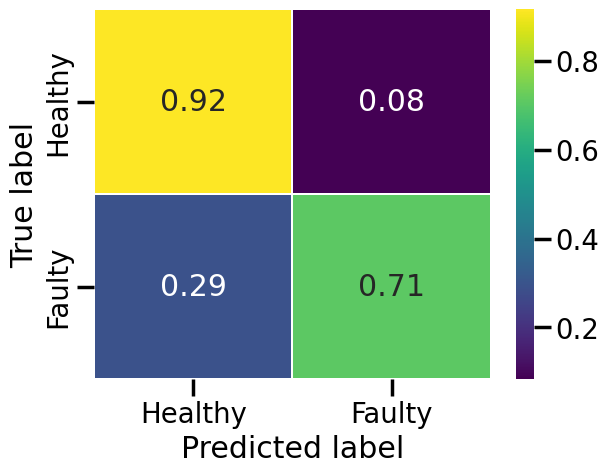

In [99]:
def distance_calculation(
    ensemble_support_groups,
    ensemble_query_healthy_groups,
    ensemble_query_groups,
    distance_metric,
    repetition_offset,
):
    all_support_distances = {}
    all_query_healthy_distances = {}
    all_query_distances = {}

    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    # print(f"> {severity} {fault} {rpm} {torque}")
                    # print("SUPPORT")

                    ensemble_support_distances = []
                    prototypes = []
                    support_inv_cms = []

                    # Ensemble loop
                    for i in range(ensemble_size):
                        prototype = ensemble_support_groups[repetition_offset + i][
                            f"{severity}_{fault}_{rpm}_{torque}"
                        ].mean(axis=0)
                        prototypes.append(prototype)

                        # Calculate distance
                        if distance_metric == "L2":
                            support_distances = distance(
                                prototype,
                                ensemble_support_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                        elif distance_metric == "mahalanobis":
                            support_inv_cm = np.linalg.pinv(
                                np.cov(
                                    ensemble_support_groups[repetition_offset + i][
                                        f"{severity}_{fault}_{rpm}_{torque}"
                                    ],
                                    rowvar=False,
                                )
                            )
                            support_inv_cms.append(support_inv_cm)
                            support_distances = distance_mahalanobis(
                                prototype,
                                ensemble_support_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cm,
                            )
                        else:
                            raise Exception("WAT")
                        ensemble_support_distances.append(support_distances)

                    # Ensemble average
                    mean_support_distances = np.stack(
                        ensemble_support_distances, axis=-1
                    ).mean(axis=-1)
                    all_support_distances[f"{severity}_{fault}_{rpm}_{torque}"] = (
                        mean_support_distances
                    )

                    # print("QUERY")

                    ensemble_query_healthy_distances = []
                    ensemble_query_distances = []

                    for i in range(ensemble_size):
                        if distance_metric == "L2":
                            # Query healthy
                            query_healthy_distances = distance(
                                prototypes[i],
                                ensemble_query_healthy_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                            # Faults
                            query_distances = distance(
                                prototypes[i],
                                ensemble_query_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                        elif distance_metric == "mahalanobis":
                            # Query healthy
                            query_healthy_distances = distance_mahalanobis(
                                prototypes[i],
                                ensemble_query_healthy_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cms[i],
                            )
                            # Faults
                            query_distances = distance_mahalanobis(
                                prototypes[i],
                                ensemble_query_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cms[i],
                            )
                        ensemble_query_healthy_distances.append(query_healthy_distances)
                        ensemble_query_distances.append(query_distances)

                    # Ensemble averages
                    mean_query_healthy_distances = np.stack(
                        ensemble_query_healthy_distances, axis=-1
                    ).mean(axis=-1)
                    all_query_healthy_distances[
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = mean_query_healthy_distances

                    mean_query_distances = np.stack(
                        ensemble_query_distances, axis=-1
                    ).mean(axis=-1)
                    all_query_distances[f"{severity}_{fault}_{rpm}_{torque}"] = (
                        mean_query_distances
                    )

    return all_support_distances, all_query_healthy_distances, all_query_distances


repetition_distances = []  # list<(support, query, query_healthy)>

for repetition_offset in range(
    0, num_repetitions * ensemble_size, ensemble_size
):  # range(0, 25, 5)
    repetition_distances.append(
        distance_calculation(
            ensemble_support_groups,
            ensemble_query_healthy_groups,
            ensemble_query_groups,
            # "mahalanobis",
            "L2",
            repetition_offset,
        )
    )

# Thresholding

support_under = 0
query_healthy_under = 0
query_under = 0

support_total = 0
query_healthy_total = 0
query_total = 0

for (
    repetition_support_distances,
    repetition_query_healthy_distances,
    repetition_query_distances,
) in repetition_distances:
    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    full_class = f"{severity}_{fault}_{rpm}_{torque}"

                    limit = 2.5 * np.max(repetition_support_distances[full_class])
                    # limit = 5 * np.std(repetition_support_distances[full_class])

                    support_under += np.sum(
                        repetition_support_distances[full_class] < limit
                    )
                    support_total += len(repetition_support_distances[full_class])

                    query_healthy_under += np.sum(
                        repetition_query_healthy_distances[full_class] < limit
                    )
                    query_healthy_total += len(
                        repetition_query_healthy_distances[full_class]
                    )

                    query_under += np.sum(
                        repetition_query_distances[full_class] < limit
                    )
                    query_total += len(repetition_query_distances[full_class])

print("STATS")
print(f"{support_under} / {support_total} = {support_under / support_total * 100}%")
print(
    f"{query_healthy_under} / {query_healthy_total} = {query_healthy_under / query_healthy_total * 100}%"
)
print(f"{query_under} / {query_total} = {query_under / query_total * 100}%")
print()
print(
    f"Accuracy: ({query_healthy_under} + {query_total - query_under}) / ({query_healthy_total} + {query_total}) = {(query_healthy_under + (query_total - query_under)) / (query_healthy_total + query_total) * 100:.1f}%"
)
precision = (query_total - query_under) / (
    (query_total - query_under) + (query_healthy_total - query_healthy_under)
)
print(
    f"Precision: {query_total - query_under} / ({query_total - query_under} + {query_healthy_total - query_healthy_under}) = {precision * 100:.1f}%"
)
recall = (query_total - query_under) / ((query_total - query_under) + query_under)
print(
    f"Recall: {query_total - query_under} / ({query_total - query_under} + {query_under}) = {recall * 100:.1f}%"
)
f1 = 2 / ((1 / precision) + (1 / recall))
print(f"F1: {f1}")

# Plotting

cf_agg = np.array(
    [
        [
            query_healthy_under / query_healthy_total,
            (query_healthy_total - query_healthy_under) / query_healthy_total,
        ],
        [query_under / query_total, (query_total - query_under) / query_total],
    ]
)
categories = ["Healthy", "Faulty"]

ax = sns.heatmap(
    cf_agg,
    annot=True,
    fmt=".2f",
    linewidth=0.3,
    xticklabels=categories,
    yticklabels=categories,
    cmap="viridis",
)
ax.set(xlabel="Predicted label", ylabel="True label")

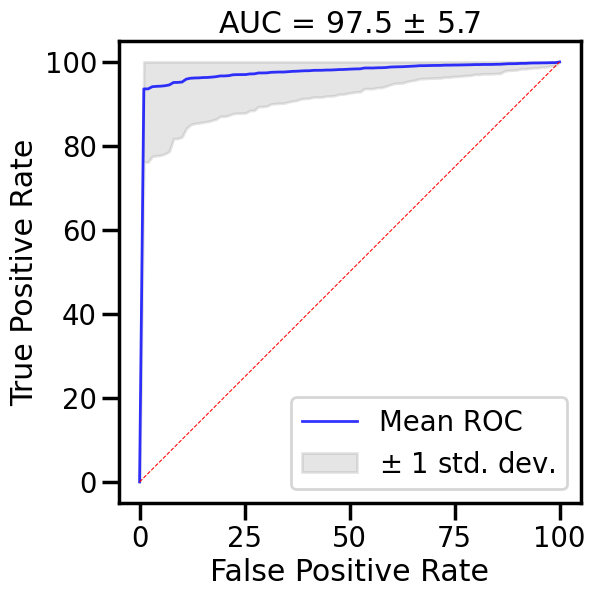

In [100]:
healthy = [
    np.array([x, np.zeros_like(x)]) for x in repetition_query_healthy_distances.values()
]
query = [np.array([x, np.ones_like(x)]) for x in repetition_query_distances.values()]

case_names = list(repetition_query_healthy_distances.keys())

cases = []
for i in range(len(healthy)):
    cases.append(
        {
            "labels": np.concatenate([healthy[i][1], query[i][1]]),
            "scores": np.concatenate([healthy[i][0], query[i][0]]),
        }
    )

fig, ax = plt.subplots(figsize=(6, 6))
# fig, ax = plt.subplots(2, 1, figsize=(6, 6))

fprs = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, case in enumerate(cases[:]):
    # print(case["labels"].shape)
    # print(case["scores"].shape)

    # viz = RocCurveDisplay.from_predictions(
    #     case["labels"],
    #     case["scores"],
    #     name=f"_{case_names[i]}",
    #     alpha=0.3,
    #     lw=1,
    #     # ax=ax,
    #     # plot_chance_level=False,
    #     plot_chance_level=(i == len(cases) - 1),
    # )

    fpr, tpr, _ = roc_curve(case["labels"], case["scores"], drop_intermediate=True)
    roc_auc = roc_auc_score(case["labels"], case["scores"])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    # interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    # aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr * 100,
    mean_tpr * 100,
    color="b",
    label=r"Mean ROC",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr * 100,
    tprs_lower * 100,
    tprs_upper * 100,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}",
    # title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}\n(Positive label 'Faulty')",
    # title=f"Mean ROC curve with variability\n(Positive label 'Faulty')",
)
ax.axis("square")
ax.legend(
    loc="lower right",
)
sns.lineplot(
    x=[0, 100], y=[0, 100], color="red", linestyle="dashed", linewidth=0.75, ax=ax
)
plt.savefig("images/AD_AGFD_A3_to_T1_ROC.svg")
plt.show()

### More detailed distances


In [101]:
rpm = 750
faults = ["micropitting", "pitting", "wear", "tff"]
installation = [1, 2]
torque = 6

repetition_offset = 0  # * Change this to change between repetitions

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

for i in range(ensemble_size):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for fault in faults:
        for severity in severities:
            # SUPPORT #
            support_group = (
                query_data[repetition_offset + i][
                    (query_data[repetition_offset + i]["rpm"] == rpm)
                    & (
                        query_data[repetition_offset + i]["severity"]
                        == str(fault_GP_map[f"{severity}_{fault}"])
                    )
                    & (query_data[repetition_offset + i]["torque"] == torque)
                ]
                .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
                .to_numpy()
            )

            ensemble_support_groups[i][f"{severity}_{fault}"] = support_group[
                : support_group.shape[0] // 2
            ]

            # QUERY BASELINE #
            ensemble_query_healthy_groups[i][f"{severity}_{fault}"] = support_group[
                support_group.shape[0] // 2 :
            ]

            # QUERY FAULTS #
            query_group = (
                query_data[repetition_offset + i][
                    (query_data[repetition_offset + i]["rpm"] == rpm)
                    & (query_data[repetition_offset + i]["severity"] == severity)
                    & (query_data[repetition_offset + i]["torque"] == torque)
                    & (
                        query_data[repetition_offset + i]["installation"].isin(
                            installation
                        )
                    )
                    & (query_data[repetition_offset + i]["fault"] == fault)
                ]
                .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
                .to_numpy()
            )

            ensemble_query_groups[i][f"{severity}_{fault}"] = query_group

> mild micropitting
SUPPORT
Mean:     0.07
Max:      0.32
Min:      0.00

QUERY
Mean:   240.22 |     0.18
Max:    407.38 |     0.68
Min:    138.92 |     0.00

> severe micropitting
SUPPORT
Mean:     0.08
Max:      0.34
Min:      0.00

QUERY
Mean:   373.32 |     0.58
Max:    776.95 |     1.54
Min:     48.60 |     0.02

> mild pitting
SUPPORT
Mean:     1.84
Max:     25.80
Min:      0.01

QUERY
Mean:    75.14 |    13.53
Max:    146.25 |    37.51
Min:      2.12 |     1.03

> severe pitting
SUPPORT
Mean:     0.13
Max:      0.42
Min:      0.00

QUERY
Mean:   219.67 |     1.02
Max:    506.41 |     2.64
Min:     21.42 |     0.00

> mild wear
SUPPORT
Mean:     0.13
Max:      0.40
Min:      0.00

QUERY
Mean:   869.87 |     0.16
Max:   1882.73 |     0.44
Min:     17.84 |     0.07

> severe wear
SUPPORT
Mean:     0.27
Max:      1.86
Min:      0.00

QUERY
Mean:   747.91 |     2.02
Max:   1521.88 |     4.07
Min:     93.86 |     0.04

> mild tff
SUPPORT
Mean:     0.86
Max:      5.11
Min:      0.02

Q

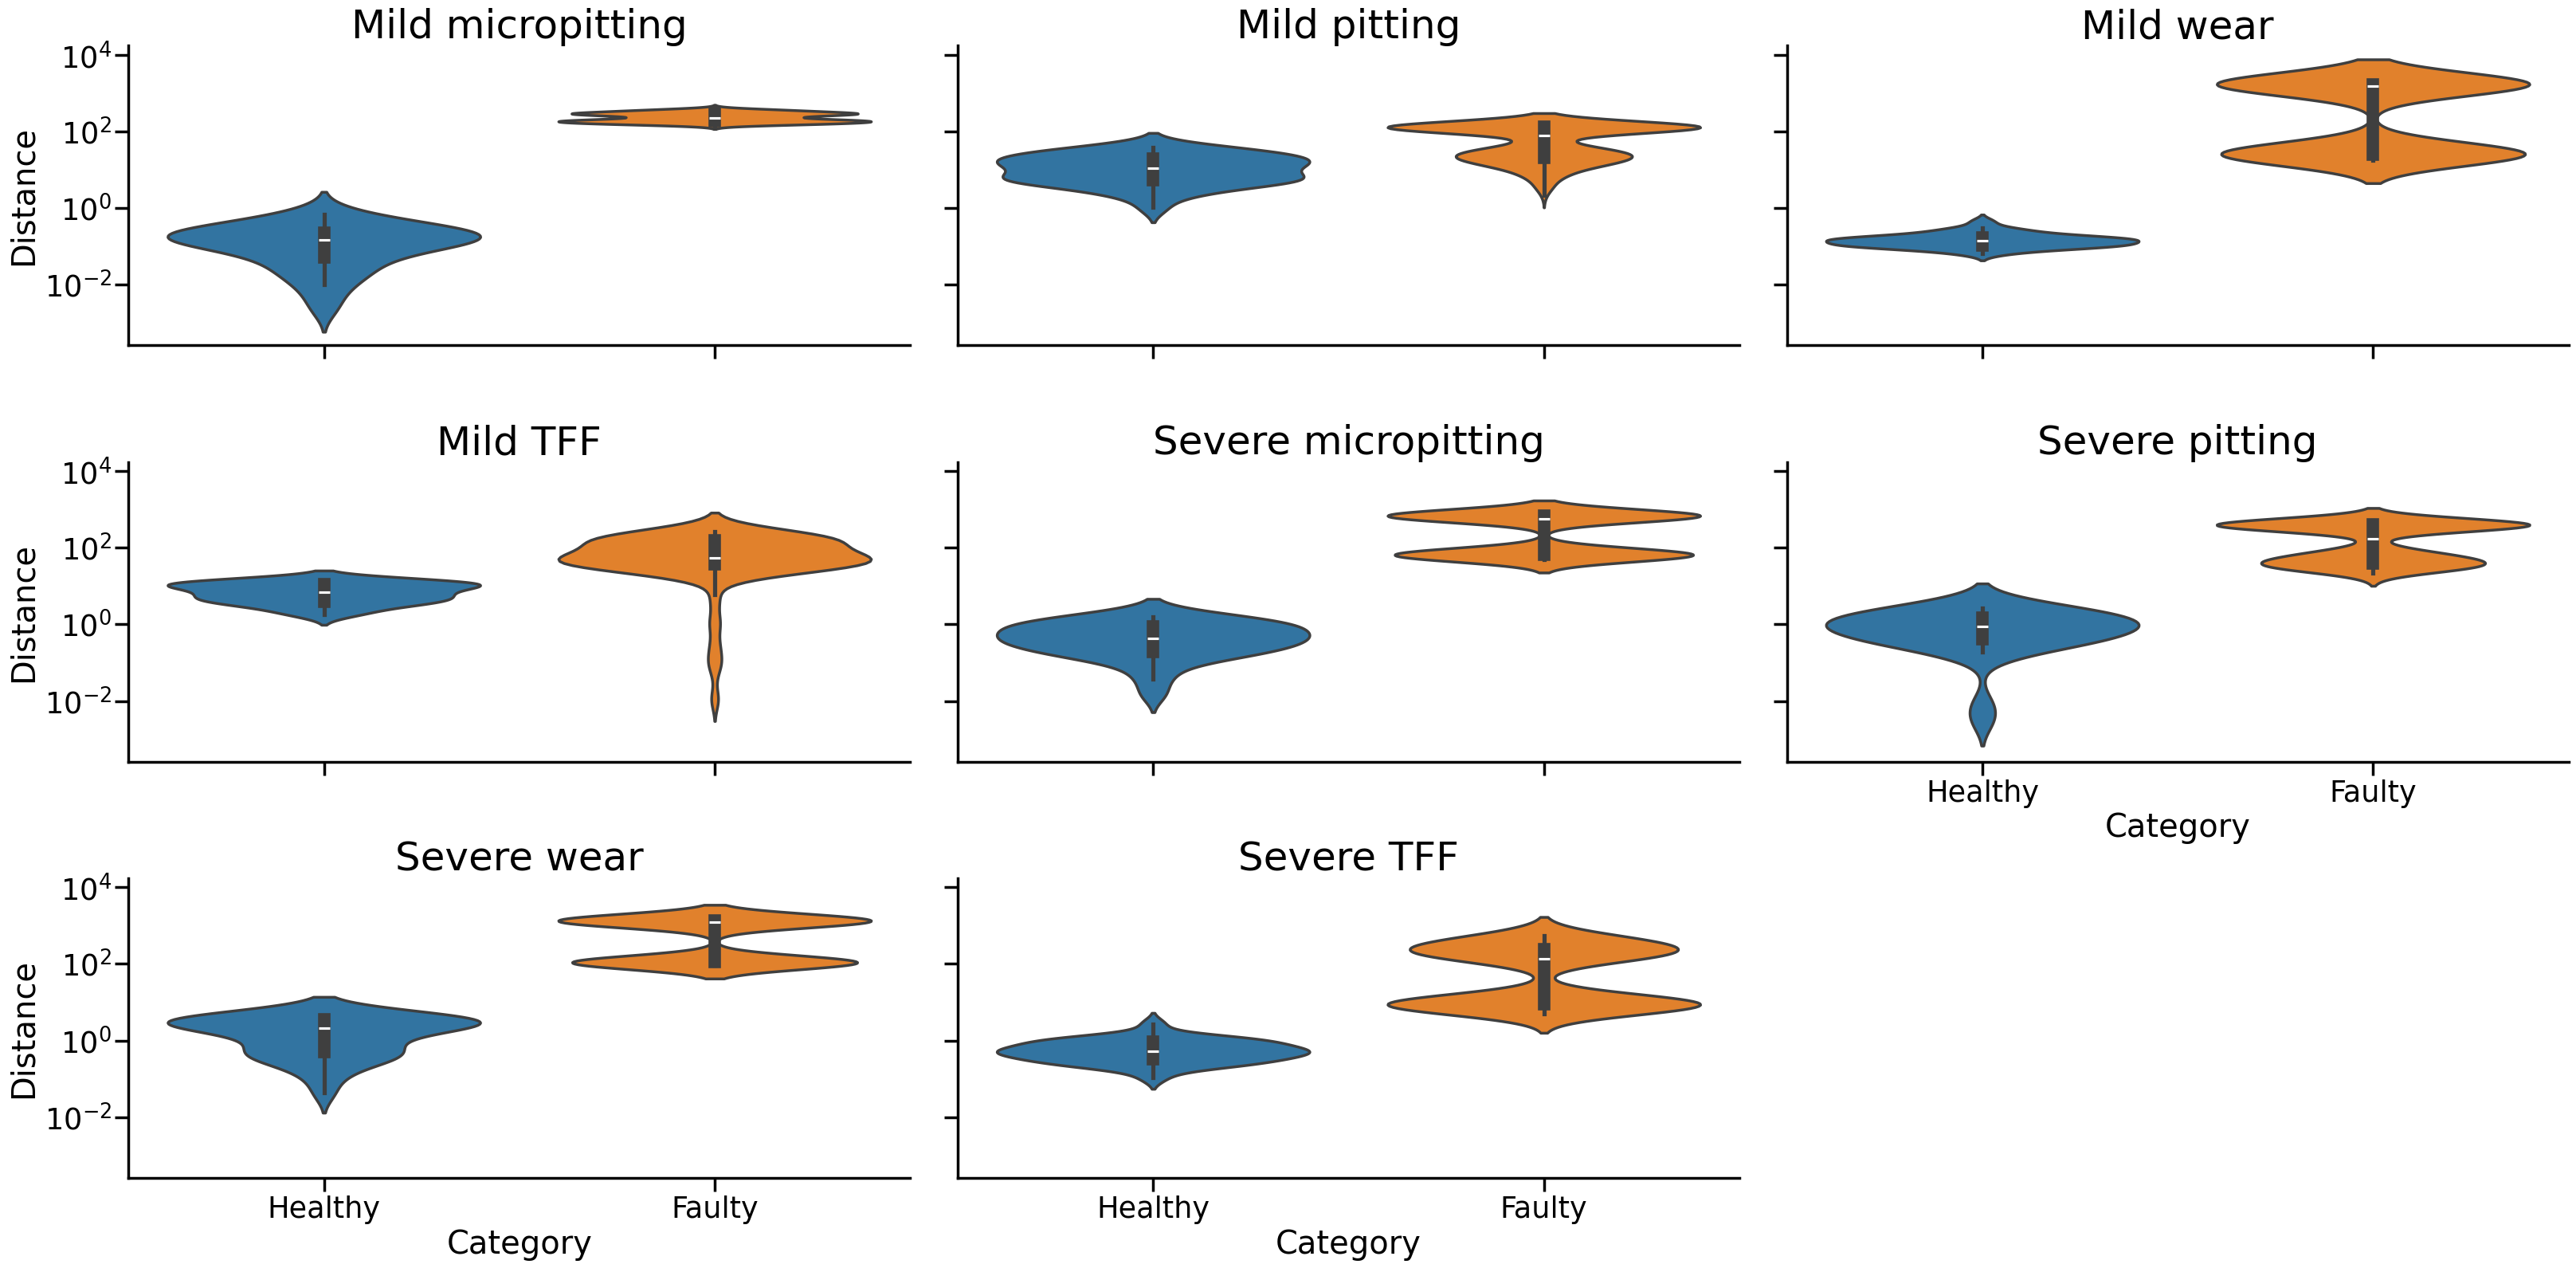

In [102]:
distance_metric = "L2"
# distance_metric = "mahalanobis"

all_support_distances = {}
all_query_healthy_distances = {}
all_query_distances = {}

for fault in faults:
    for severity in severities:
        print(f"> {severity} {fault}")
        print("SUPPORT")

        ensemble_support_distances = []
        prototypes = []
        support_inv_cms = []

        # Ensemble loop
        for i in range(ensemble_size):
            prototype = ensemble_support_groups[i][f"{severity}_{fault}"].mean(axis=0)
            prototypes.append(prototype)

            # Calculate distance
            if distance_metric == "L2":
                support_distances = distance(
                    prototype, ensemble_support_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                support_inv_cm = np.linalg.pinv(
                    np.cov(
                        ensemble_support_groups[i][f"{severity}_{fault}"], rowvar=False
                    )
                )
                support_inv_cms.append(support_inv_cm)
                support_distances = distance_mahalanobis(
                    prototype,
                    ensemble_support_groups[i][f"{severity}_{fault}"],
                    support_inv_cm,
                )
            else:
                raise Exception("WAT")
            ensemble_support_distances.append(support_distances)

        # Ensemble average
        mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(
            axis=-1
        )
        all_support_distances[f"{severity}_{fault}"] = mean_support_distances

        print("Mean: {:>8.2f}".format(mean_support_distances.mean()))
        print("Max:  {:>8.2f}".format(mean_support_distances.max()))
        print("Min:  {:>8.2f}".format(mean_support_distances.min()))
        print()

        print("QUERY")

        ensemble_query_healthy_distances = []
        ensemble_query_distances = []

        for i in range(ensemble_size):
            if distance_metric == "L2":
                # Query healthy
                query_healthy_distances = distance(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                )
                # Faults
                query_distances = distance(
                    prototypes[i], ensemble_query_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                # Query healthy
                query_healthy_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
                # Faults
                query_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
            ensemble_query_healthy_distances.append(query_healthy_distances)
            ensemble_query_distances.append(query_distances)

        # Ensemble averages
        mean_query_healthy_distances = np.stack(
            ensemble_query_healthy_distances, axis=-1
        ).mean(axis=-1)
        all_query_healthy_distances[f"{severity}_{fault}"] = (
            mean_query_healthy_distances
        )

        mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(axis=-1)
        all_query_distances[f"{severity}_{fault}"] = mean_query_distances

        print(
            "Mean: {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.mean(), mean_query_healthy_distances.mean()
            )
        )
        print(
            "Max:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.max(), mean_query_healthy_distances.max()
            )
        )
        print(
            "Min:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.min(), mean_query_healthy_distances.min()
            )
        )
        print()

# Plotting

df = []
for severity in severities:
    for fault in faults:
        full_fault = f"{severity}_{fault}"

        # tmp_1 = pd.DataFrame(all_support_distances[full_fault], columns=["distance"])
        # tmp_1["category"] = "Support"
        # tmp_1["fault"] = full_fault
        tmp_2 = pd.DataFrame(
            all_query_healthy_distances[full_fault], columns=["Distance"]
        )
        tmp_2["Category"] = "Healthy"
        tmp_2["Fault"] = full_fault.replace("_", " ").capitalize().replace("tff", "TFF")
        tmp_3 = pd.DataFrame(all_query_distances[full_fault], columns=["Distance"])
        tmp_3["Category"] = "Faulty"
        # tmp_3["Category"] = "Faulty"
        tmp_3["Fault"] = full_fault.replace("_", " ").capitalize().replace("tff", "TFF")

        # df.append(tmp_1)
        df.append(tmp_2)
        df.append(tmp_3)

df = pd.concat(df)
# print(df)
# raise

# fig, ax = plt.subplots(figsize=(6.5, 6))
with sns.plotting_context("poster", font_scale=1.2):
    g = sns.catplot(
        df,
        x="Category",
        y="Distance",
        hue="Category",
        col="Fault",
        col_wrap=3,
        log_scale=True,
        height=5.5,
        aspect=2,
        kind="violin",
        # palette=sns.color_palette("Paired"),
        legend=False,
        # width=2.1,
    )
    # plt.tight_layout()
    g.set_titles(col_template="{col_name}", size=36)

    plt.savefig(
        "images/AD_AGFD_A3_to_T1_distances.pdf", format="pdf", bbox_inches="tight"
    )

# Trained w/ AGFD, acc3 to torque1


In [103]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

query_data = []
num_repetitions = 10
ensemble_size = 5

for i in range(num_repetitions * ensemble_size):
    query_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                "AD_arotor_acc3_to_torque1_article",
                f"query_{i}.feather",
            )
        )
    )

print("Number of models: ", len(query_data))
print("Queries:", query_data[0].shape)


def distance_mahalanobis(prototype, queries, inv_cm):
    return np.array([mahalanobis(x, prototype, inv_cm) for x in queries])


def distance(prototype, queries):
    return np.sum((queries - prototype) ** 2, axis=1)

Number of models:  50
Queries: (6240, 18)


In [104]:
rpms = [250, 500, 750, 1000, 1250, 1500]
faults = [1, 2, 3, 4, 5, 6, 7, 8, 9]

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

assert (
    len(query_data) == num_repetitions * ensemble_size
), f"len(query_data) != num_repetitions * ensemble_size, {len(query_data)} != {num_repetitions * ensemble_size}"

for i in range(len(query_data)):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for rpm in rpms:
        # SUPPORT #
        support_group = (
            query_data[i][(query_data[i]["rpm"] == rpm) & (query_data[i]["class"] == 0)]
            .drop(
                ["rpm", "class"],
                axis=1,
            )
            .to_numpy()
        )
        # Check if NaNs
        if np.sum(~np.isfinite(support_group)) != 0:
            print("NaN detected in {full_fault}!")
            print(support_group)
            raise

        # * 50/50 split on baseline measurements to support and query
        ensemble_support_groups[i][f"0_{rpm}"] = support_group[
            : support_group.shape[0] // 2
        ]

        # QUERY BASELINE #
        ensemble_query_healthy_groups[i][f"0_{rpm}"] = support_group[
            support_group.shape[0] // 2 :
        ]

        for fault in faults:
            full_fault = f"{fault} {rpm}"

            # QUERY FAULTS #
            query_group = (
                query_data[i][
                    (query_data[i]["rpm"] == rpm) & (query_data[i]["class"] == fault)
                ]
                .drop(
                    ["rpm", "class"],
                    axis=1,
                )
                .to_numpy()
            )

            # Check if NaNs
            if np.sum(~np.isfinite(query_group)) != 0:
                print("NaN detected in {full_fault}!")
                print(query_group)
                raise

            ensemble_query_groups[i][f"{fault}_{rpm}"] = query_group

STATS
28080 / 28080 = 100.0%
27630 / 28080 = 98.3974358974359%
478 / 56160 = 0.8511396011396012%

Accuracy: (27630 + 55682) / (28080 + 56160) = 98.9%
Precision: 55682 / (55682 + 450) = 99.2%
Recall: 55682 / (55682 + 478) = 99.1%
F1: 0.9917358315819472


[Text(0.5, -2.2833333333333368, 'Predicted label'),
 Text(24.916666666666657, 0.5, 'True label')]

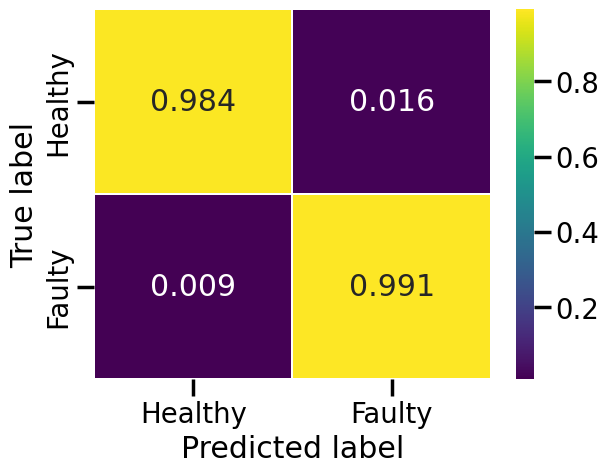

In [105]:
distance_metric = "L2"
# distance_metric = "mahalanobis"


def distance_calculation(
    ensemble_support_groups,
    ensemble_query_healthy_groups,
    ensemble_query_groups,
    distance_metric,
    repetition_offset,
):
    all_support_distances = {}
    all_query_healthy_distances = {}
    all_query_distances = {}

    for rpm in rpms:
        ensemble_support_distances = []
        ensemble_query_healthy_distances = []
        prototypes = []
        support_inv_cms = []

        # Ensemble loop
        for i in range(ensemble_size):
            prototype = ensemble_support_groups[repetition_offset + i][f"0_{rpm}"].mean(
                axis=0
            )
            prototypes.append(prototype)

            # Calculate distance
            if distance_metric == "L2":
                # Support
                support_distances = distance(
                    prototype,
                    ensemble_support_groups[repetition_offset + i][f"0_{rpm}"],
                )
                # Query healthy
                query_healthy_distances = distance(
                    prototypes[i],
                    ensemble_query_healthy_groups[repetition_offset + i][f"0_{rpm}"],
                )
            elif distance_metric == "mahalanobis":
                # Support
                support_inv_cm = np.linalg.pinv(
                    np.cov(
                        ensemble_support_groups[repetition_offset + i][f"0_{rpm}"],
                        rowvar=False,
                    )
                )
                support_inv_cms.append(support_inv_cm)
                support_distances = distance_mahalanobis(
                    prototype,
                    ensemble_support_groups[repetition_offset + i][f"0_{rpm}"],
                    support_inv_cm,
                )
                # Query healthy
                query_healthy_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_healthy_groups[repetition_offset + i][f"0_{rpm}"],
                    support_inv_cms[i],
                )
            else:
                raise Exception("WAT")
            ensemble_support_distances.append(support_distances)
            ensemble_query_healthy_distances.append(query_healthy_distances)

        # Ensemble average
        # Support
        mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(
            axis=-1
        )
        all_support_distances[f"0_{rpm}"] = mean_support_distances
        # Query healthy
        mean_query_healthy_distances = np.stack(
            ensemble_query_healthy_distances, axis=-1
        ).mean(axis=-1)
        all_query_healthy_distances[f"0_{rpm}"] = mean_query_healthy_distances

        for fault in faults:
            ensemble_query_distances = []

            for i in range(ensemble_size):
                if distance_metric == "L2":
                    # Faults
                    query_distances = distance(
                        prototypes[i],
                        ensemble_query_groups[repetition_offset + i][f"{fault}_{rpm}"],
                    )
                elif distance_metric == "mahalanobis":
                    # Faults
                    query_distances = distance_mahalanobis(
                        prototypes[i],
                        ensemble_query_groups[repetition_offset + i][f"{fault}_{rpm}"],
                        support_inv_cms[i],
                    )
                ensemble_query_distances.append(query_distances)

            # Ensemble averages
            mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(
                axis=-1
            )
            all_query_distances[f"{fault}_{rpm}"] = mean_query_distances

    return all_support_distances, all_query_healthy_distances, all_query_distances


repetition_distances = []  # list<(support, query, query_healthy)>

for repetition_offset in range(
    0, num_repetitions * ensemble_size, ensemble_size
):  # range(0, 50, 5)
    repetition_distances.append(
        distance_calculation(
            ensemble_support_groups,
            ensemble_query_healthy_groups,
            ensemble_query_groups,
            # "mahalanobis",
            # "L2",
            distance_metric,
            repetition_offset,
        )
    )

# Thresholding

support_under = 0
query_healthy_under = 0
query_under = 0

support_total = 0
query_healthy_total = 0
query_total = 0

for (
    repetition_support_distances,
    repetition_query_healthy_distances,
    repetition_query_distances,
) in repetition_distances:
    for rpm in rpms:
        for fault in faults:
            full_class = f"{fault}_{rpm}"
            support_class = f"0_{rpm}"

            limit = 4 * np.max(repetition_support_distances[support_class])
            # std = np.std(repetition_support_distances[full_class])
            # limit = 20 * std

            support_under += np.sum(repetition_support_distances[support_class] < limit)
            support_total += len(repetition_support_distances[support_class])

            query_healthy_under += np.sum(
                repetition_query_healthy_distances[support_class] < limit
            )
            query_healthy_total += len(
                repetition_query_healthy_distances[support_class]
            )

            # print(list(repetition_query_distances.keys()))
            # raise
            query_under += np.sum(repetition_query_distances[full_class] < limit)
            query_total += len(repetition_query_distances[full_class])

print("STATS")
print(f"{support_under} / {support_total} = {support_under / support_total * 100}%")
print(
    f"{query_healthy_under} / {query_healthy_total} = {query_healthy_under / query_healthy_total * 100}%"
)
print(f"{query_under} / {query_total} = {query_under / query_total * 100}%")
print()
print(
    f"Accuracy: ({query_healthy_under} + {query_total - query_under}) / ({query_healthy_total} + {query_total}) = {(query_healthy_under + (query_total - query_under)) / (query_healthy_total + query_total) * 100:.1f}%"
)
precision = (query_total - query_under) / (
    (query_total - query_under) + (query_healthy_total - query_healthy_under)
)
print(
    f"Precision: {query_total - query_under} / ({query_total - query_under} + {query_healthy_total - query_healthy_under}) = {precision * 100:.1f}%"
)
recall = (query_total - query_under) / ((query_total - query_under) + query_under)
print(
    f"Recall: {query_total - query_under} / ({query_total - query_under} + {query_under}) = {recall * 100:.1f}%"
)
f1 = 2 / ((1 / precision) + (1 / recall))
print(f"F1: {f1}")

# Plotting

cf_agg = np.array(
    [
        [
            query_healthy_under / query_healthy_total,
            (query_healthy_total - query_healthy_under) / query_healthy_total,
        ],
        [query_under / query_total, (query_total - query_under) / query_total],
    ]
)
categories = ["Healthy", "Faulty"]

ax = sns.heatmap(
    cf_agg,
    annot=True,
    fmt=".3f",
    linewidth=0.3,
    xticklabels=categories,
    yticklabels=categories,
    cmap="viridis",
)
ax.set(xlabel="Predicted label", ylabel="True label")

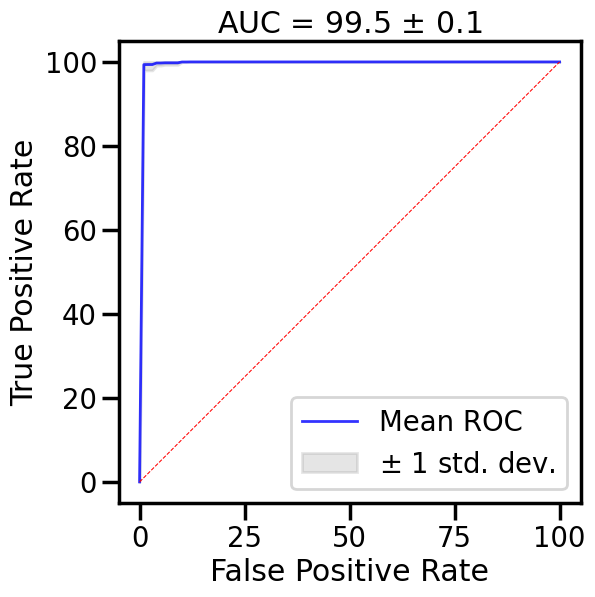

In [106]:
healthy_ds = {}
healthy_labels = {}
for rpm in rpms:
    ds = repetition_query_healthy_distances[f"0_{rpm}"]
    healthy_ds[f"{rpm}"] = ds
    healthy_labels[f"{rpm}"] = np.zeros_like(ds)

faulty_ds = {}
faulty_labels = {}
for rpm in rpms:
    faulty_ds[f"{rpm}"] = []
    faulty_labels[f"{rpm}"] = []

    for fault in faults:
        ds = repetition_query_distances[f"{fault}_{rpm}"]
        faulty_ds[f"{rpm}"].extend(ds)
        faulty_labels[f"{rpm}"].extend(np.ones_like(ds))

cases = []
for rpm in rpms:
    cases.append(
        {
            "labels": np.concatenate(
                [healthy_labels[f"{rpm}"], faulty_labels[f"{rpm}"]]
            ),
            "scores": np.concatenate([healthy_ds[f"{rpm}"], faulty_ds[f"{rpm}"]]),
        }
    )

fig, ax = plt.subplots(figsize=(6, 6))
# fig, ax = plt.subplots(2, 1, figsize=(6, 6))

fprs = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, case in enumerate(cases[:]):
    # print(case["labels"].shape)
    # print(case["scores"].shape)

    # viz = RocCurveDisplay.from_predictions(
    #     case["labels"],
    #     case["scores"],
    #     name=f"_{case_names[i]}",
    #     alpha=0.3,
    #     lw=1,
    #     # ax=ax,
    #     # plot_chance_level=False,
    #     plot_chance_level=(i == len(cases) - 1),
    # )

    fpr, tpr, _ = roc_curve(case["labels"], case["scores"], drop_intermediate=True)
    roc_auc = roc_auc_score(case["labels"], case["scores"])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    # interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    # aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr * 100,
    mean_tpr * 100,
    color="b",
    label=r"Mean ROC",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr * 100,
    tprs_lower * 100,
    tprs_upper * 100,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}",
    # title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}\n(Positive label 'Faulty')",
)
ax.axis("square")
ax.legend(
    loc="lower right",
)
sns.lineplot(
    x=[0, 100], y=[0, 100], color="red", linestyle="dashed", linewidth=0.75, ax=ax
)
plt.savefig("images/AD_ASD_A3_to_T1_ROC.svg")
plt.show()

### More detailed distances


In [107]:
rpm = 750
faults = [1, 2, 3, 4, 5, 6, 7, 8, 9]

repetition_offset = 0  # * Change this to change between repetitions

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

for i in range(ensemble_size):
    # ensemble_support_groups.append({})
    # ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    # SUPPORT #
    support_group = (
        query_data[repetition_offset + i][
            (
                (query_data[repetition_offset + i]["rpm"] == rpm)
                & (query_data[repetition_offset + i]["class"] == 0)
            )
        ]
        .drop(["rpm", "class"], axis=1)
        .to_numpy()
    )

    ensemble_support_groups.append(support_group[: support_group.shape[0] // 2])
    # ensemble_support_groups[i][rpm] = support_group[: support_group.shape[0] // 2]

    # QUERY BASELINE #
    ensemble_query_healthy_groups.append(support_group[support_group.shape[0] // 2 :])
    # ensemble_query_healthy_groups[i][rpm] = support_group[support_group.shape[0] // 2 :]

    for fault in faults:
        # QUERY FAULTS #
        query_group = (
            query_data[repetition_offset + i][
                (query_data[repetition_offset + i]["rpm"] == rpm)
                & (query_data[repetition_offset + i]["class"] == fault)
            ]
            .drop(["rpm", "class"], axis=1)
            .to_numpy()
        )

        ensemble_query_groups[i][f"{fault}"] = query_group

> 1
SUPPORT
Mean:     0.24
Max:      0.76
Min:      0.01

QUERY
Mean:    46.48 |     0.46
Max:     57.41 |     1.32
Min:     36.80 |     0.06

> 2
SUPPORT
Mean:     0.24
Max:      0.76
Min:      0.01

QUERY
Mean:   146.90 |     0.46
Max:    169.22 |     1.32
Min:    129.93 |     0.06

> 3
SUPPORT
Mean:     0.24
Max:      0.76
Min:      0.01

QUERY
Mean:   823.53 |     0.46
Max:    930.30 |     1.32
Min:    683.20 |     0.06

> 4
SUPPORT
Mean:     0.24
Max:      0.76
Min:      0.01

QUERY
Mean:   768.70 |     0.46
Max:    896.65 |     1.32
Min:    663.22 |     0.06

> 5
SUPPORT
Mean:     0.24
Max:      0.76
Min:      0.01

QUERY
Mean:   623.45 |     0.46
Max:    664.22 |     1.32
Min:    592.06 |     0.06

> 6
SUPPORT
Mean:     0.24
Max:      0.76
Min:      0.01

QUERY
Mean:  1030.92 |     0.46
Max:   1112.77 |     1.32
Min:    936.91 |     0.06

> 7
SUPPORT
Mean:     0.24
Max:      0.76
Min:      0.01

QUERY
Mean:   321.16 |     0.46
Max:    350.67 |     1.32
Min:    301.59 |     0.06


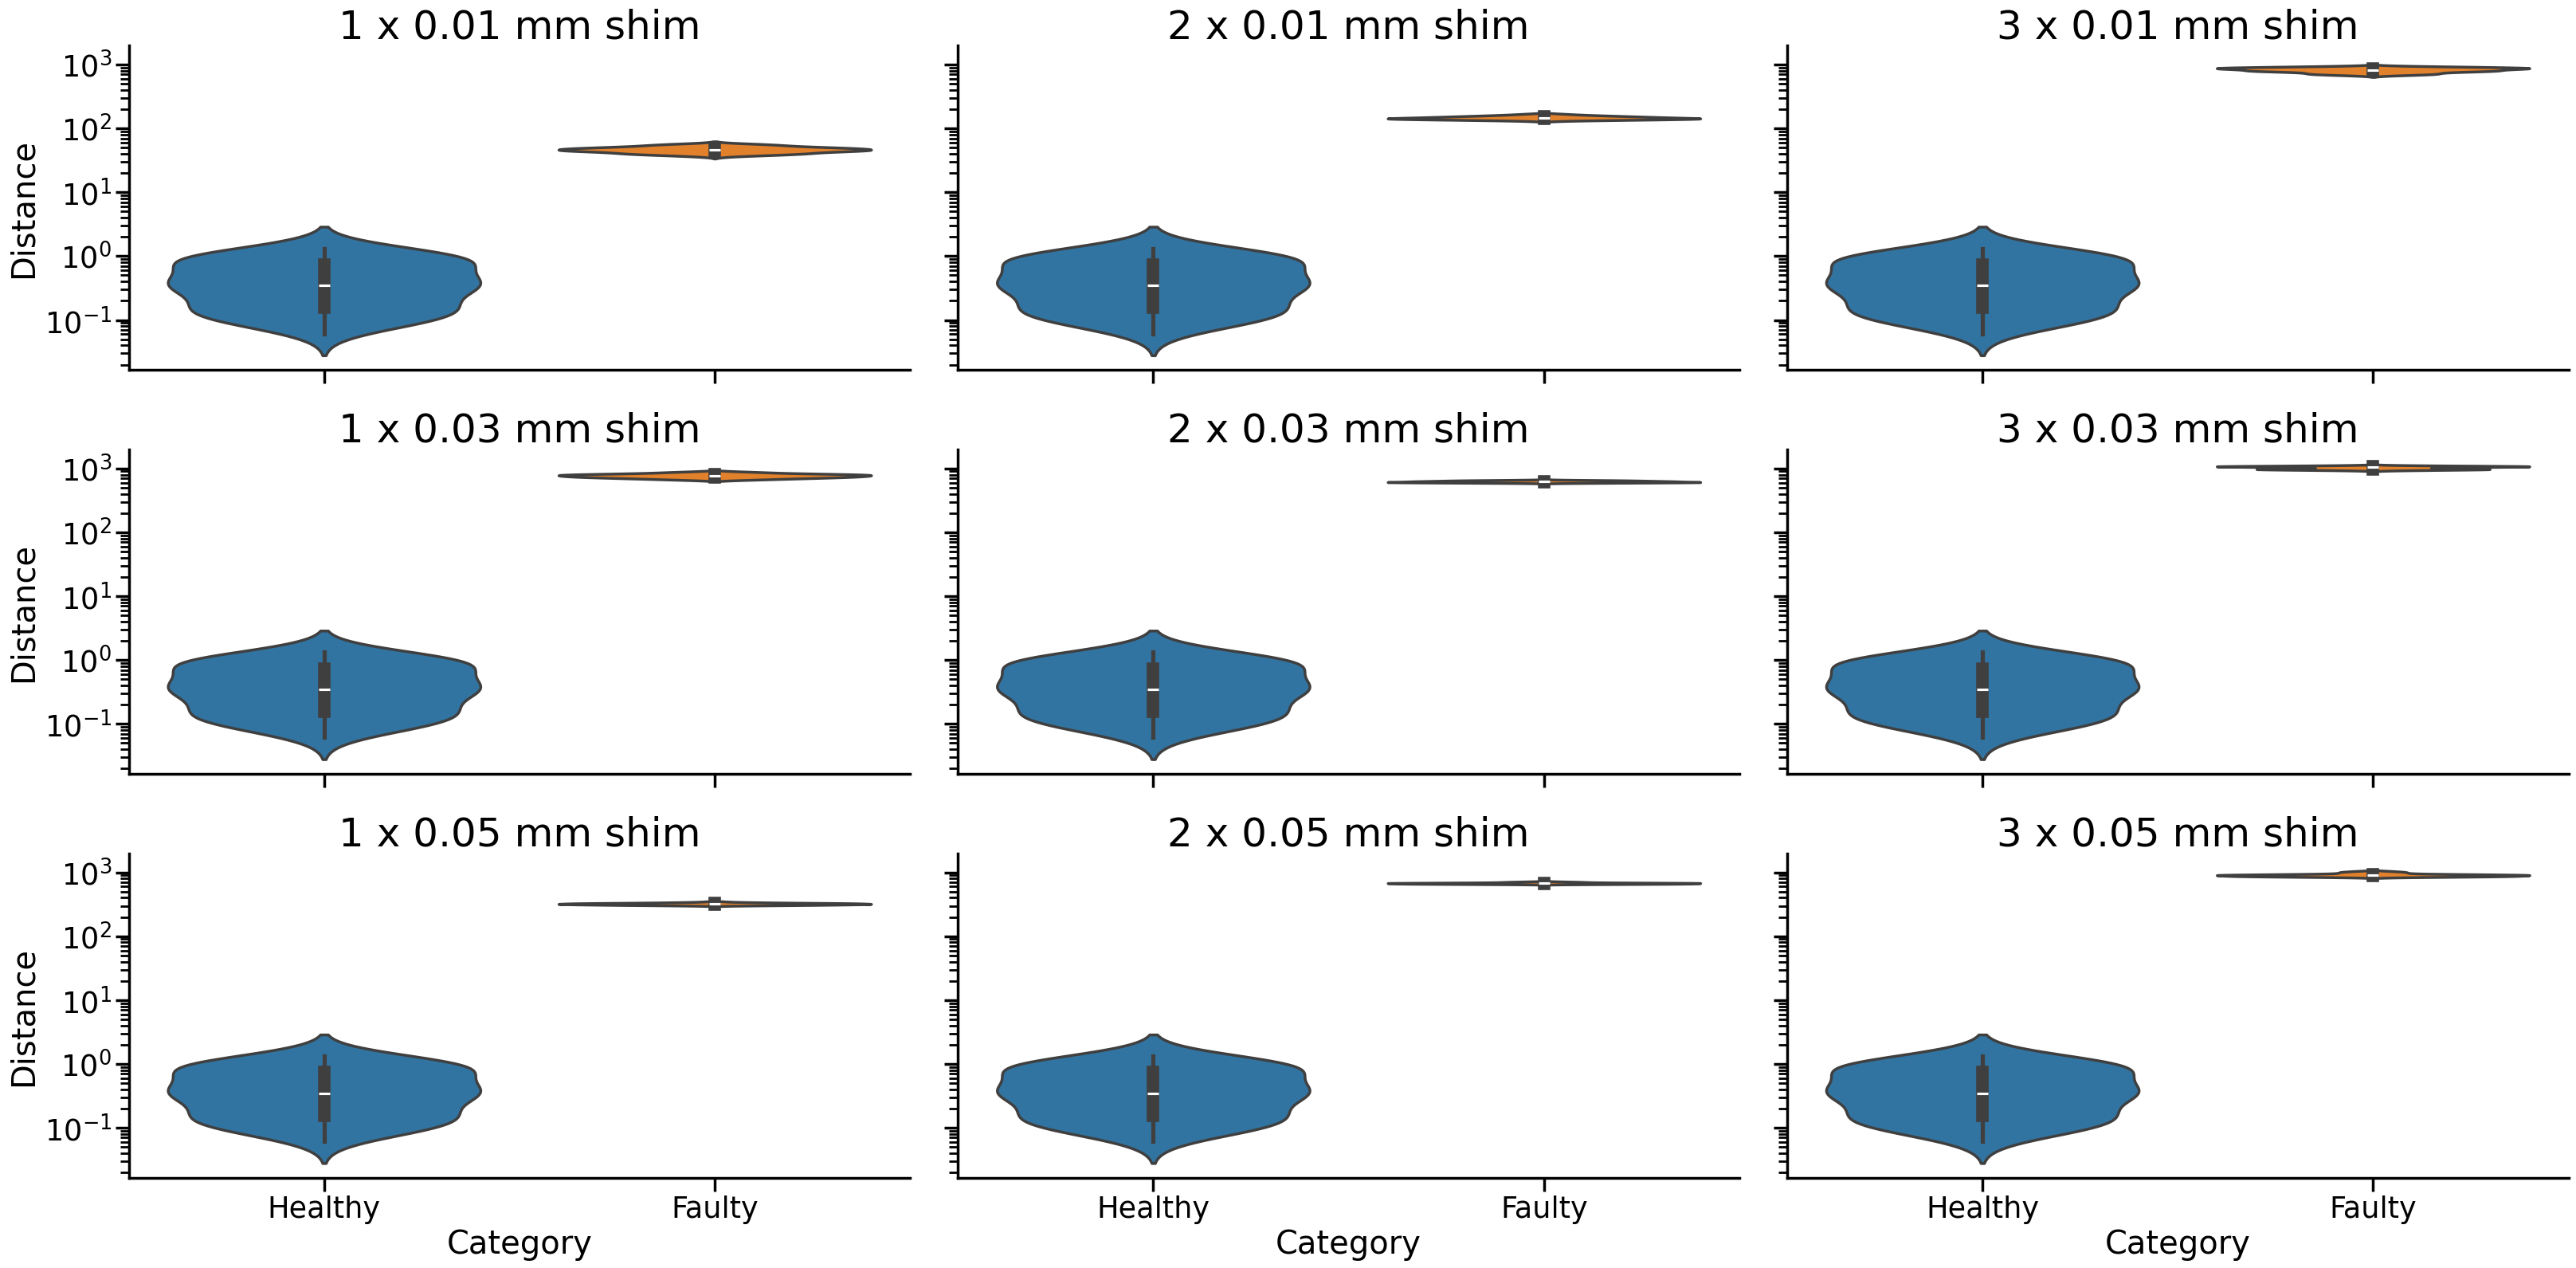

In [108]:
distance_metric = "L2"
# distance_metric = "mahalanobis"

all_support_distances = {}
all_query_healthy_distances = {}
all_query_distances = {}

for fault in faults:
    print(f"> {fault}")
    print("SUPPORT")

    ensemble_support_distances = []
    prototypes = []
    support_inv_cms = []

    # Ensemble loop
    for i in range(ensemble_size):
        prototype = ensemble_support_groups[i].mean(axis=0)
        prototypes.append(prototype)

        # Calculate distance
        if distance_metric == "L2":
            support_distances = distance(prototype, ensemble_support_groups[i])
        elif distance_metric == "mahalanobis":
            support_inv_cm = np.linalg.pinv(
                np.cov(ensemble_support_groups[i], rowvar=False)
            )
            support_inv_cms.append(support_inv_cm)
            support_distances = distance_mahalanobis(
                prototype,
                ensemble_support_groups[i],
                support_inv_cm,
            )
        else:
            raise Exception("WAT")
        ensemble_support_distances.append(support_distances)

    # Ensemble average
    # Support
    mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(axis=-1)
    all_support_distances[f"{fault}"] = mean_support_distances

    print("Mean: {:>8.2f}".format(mean_support_distances.mean()))
    print("Max:  {:>8.2f}".format(mean_support_distances.max()))
    print("Min:  {:>8.2f}".format(mean_support_distances.min()))
    print()

    print("QUERY")

    ensemble_query_healthy_distances = []
    ensemble_query_distances = []

    for i in range(ensemble_size):
        if distance_metric == "L2":
            # Query healthy
            query_healthy_distances = distance(
                prototypes[i],
                ensemble_query_healthy_groups[i],
            )
            # Faults
            query_distances = distance(
                prototypes[i], ensemble_query_groups[i][f"{fault}"]
            )
        elif distance_metric == "mahalanobis":
            # Query healthy
            query_healthy_distances = distance_mahalanobis(
                prototypes[i],
                ensemble_query_healthy_groups[i],
                support_inv_cms[i],
            )
            # Faults
            query_distances = distance_mahalanobis(
                prototypes[i],
                ensemble_query_groups[i][f"{fault}"],
                support_inv_cms[i],
            )
        ensemble_query_healthy_distances.append(query_healthy_distances)
        ensemble_query_distances.append(query_distances)

    # Ensemble averages
    # Query healthy
    mean_query_healthy_distances = np.stack(
        ensemble_query_healthy_distances, axis=-1
    ).mean(axis=-1)
    all_query_healthy_distances[f"{fault}"] = mean_query_healthy_distances

    # Faults
    mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(axis=-1)
    all_query_distances[f"{fault}"] = mean_query_distances

    print(
        "Mean: {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.mean(), mean_query_healthy_distances.mean()
        )
    )
    print(
        "Max:  {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.max(), mean_query_healthy_distances.max()
        )
    )
    print(
        "Min:  {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.min(), mean_query_healthy_distances.min()
        )
    )
    print()

# Plotting
fault_type_map = {
    "1": "1 x 0.01 mm shim",
    "2": "2 x 0.01 mm shim",
    "3": "3 x 0.01 mm shim",
    "4": "1 x 0.03 mm shim",
    "5": "2 x 0.03 mm shim",
    "6": "3 x 0.03 mm shim",
    "7": "1 x 0.05 mm shim",
    "8": "2 x 0.05 mm shim",
    "9": "3 x 0.05 mm shim",
}

df = []
for fault in faults:
    full_fault = f"{fault}"

    # tmp_1 = pd.DataFrame(all_support_distances[full_fault], columns=["distance"])
    # tmp_1["Category"] = "Support"
    # tmp_1["fault"] = full_fault
    tmp_2 = pd.DataFrame(all_query_healthy_distances[full_fault], columns=["Distance"])
    tmp_2["Category"] = "Healthy"
    tmp_2["Fault"] = fault_type_map[full_fault]
    tmp_3 = pd.DataFrame(all_query_distances[full_fault], columns=["Distance"])
    tmp_3["Category"] = "Faulty"
    # tmp_3["Fault"] = full_fault
    tmp_3["Fault"] = fault_type_map[full_fault]

    # df.append(tmp_1)
    df.append(tmp_2)
    df.append(tmp_3)

df = pd.concat(df)

with sns.plotting_context("poster", font_scale=1.2):
    g = sns.catplot(
        df,
        x="Category",
        y="Distance",
        hue="Category",
        col="Fault",
        col_wrap=3,
        log_scale=True,
        height=5.5,
        aspect=2,
        kind="violin",
        # palette=sns.color_palette("Paired"),
        legend=False,
        # width=2.1,
    )
    # plt.tight_layout()
    g.set_titles(col_template="{col_name}", size=36)

    plt.savefig(
        "images/AD_ASD_A3_to_T1_distances.pdf", format="pdf", bbox_inches="tight"
    )

# Trained w/ AGFD, torque1 to acc3


In [109]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

query_data = []
num_repetitions = 10
ensemble_size = 5

for i in range(num_repetitions * ensemble_size):
    query_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                "AD_arotor_torque1_to_acc3_article",
                f"query_{i}.feather",
            )
        )
    )

print("Number of models: ", len(query_data))
print("Queries:", query_data[0].shape)


def distance_mahalanobis(prototype, queries, inv_cm):
    return np.array([mahalanobis(x, prototype, inv_cm) for x in queries])


def distance(prototype, queries):
    return np.sum((queries - prototype) ** 2, axis=1)

Number of models:  50
Queries: (6240, 18)


In [110]:
rpms = [250, 500, 750, 1000, 1250, 1500]
faults = [1, 2, 3, 4, 5, 6, 7, 8, 9]

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

assert (
    len(query_data) == num_repetitions * ensemble_size
), f"len(query_data) != num_repetitions * ensemble_size, {len(query_data)} != {num_repetitions * ensemble_size}"

for i in range(len(query_data)):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for rpm in rpms:
        # SUPPORT #
        support_group = (
            query_data[i][(query_data[i]["rpm"] == rpm) & (query_data[i]["class"] == 0)]
            .drop(
                ["rpm", "class"],
                axis=1,
            )
            .to_numpy()
        )
        # Check if NaNs
        if np.sum(~np.isfinite(support_group)) != 0:
            print("NaN detected in {full_fault}!")
            print(support_group)
            raise

        # * 50/50 split on baseline measurements to support and query
        ensemble_support_groups[i][f"0_{rpm}"] = support_group[
            : support_group.shape[0] // 2
        ]

        # QUERY BASELINE #
        ensemble_query_healthy_groups[i][f"0_{rpm}"] = support_group[
            support_group.shape[0] // 2 :
        ]

        for fault in faults:
            full_fault = f"{fault} {rpm}"

            # QUERY FAULTS #
            query_group = (
                query_data[i][
                    (query_data[i]["rpm"] == rpm) & (query_data[i]["class"] == fault)
                ]
                .drop(
                    ["rpm", "class"],
                    axis=1,
                )
                .to_numpy()
            )

            # Check if NaNs
            if np.sum(~np.isfinite(query_group)) != 0:
                print("NaN detected in {full_fault}!")
                print(query_group)
                raise

            ensemble_query_groups[i][f"{fault}_{rpm}"] = query_group

STATS
28080 / 28080 = 100.0%
27990 / 28080 = 99.67948717948718%
5759 / 56160 = 10.25462962962963%

Accuracy: (27990 + 50401) / (28080 + 56160) = 93.1%
Precision: 50401 / (50401 + 90) = 99.8%
Recall: 50401 / (50401 + 5759) = 89.7%
F1: 0.9451575700180963


[Text(0.5, -2.2833333333333368, 'Predicted label'),
 Text(24.916666666666657, 0.5, 'True label')]

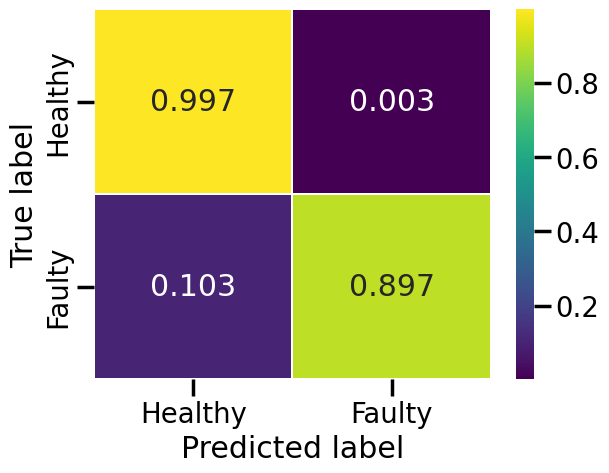

In [111]:
distance_metric = "L2"
# distance_metric = "mahalanobis"


def distance_calculation(
    ensemble_support_groups,
    ensemble_query_healthy_groups,
    ensemble_query_groups,
    distance_metric,
    repetition_offset,
):
    all_support_distances = {}
    all_query_healthy_distances = {}
    all_query_distances = {}

    for rpm in rpms:
        ensemble_support_distances = []
        ensemble_query_healthy_distances = []
        prototypes = []
        support_inv_cms = []

        # Ensemble loop
        for i in range(ensemble_size):
            prototype = ensemble_support_groups[repetition_offset + i][f"0_{rpm}"].mean(
                axis=0
            )
            prototypes.append(prototype)

            # Calculate distance
            if distance_metric == "L2":
                # Support
                support_distances = distance(
                    prototype,
                    ensemble_support_groups[repetition_offset + i][f"0_{rpm}"],
                )
                # Query healthy
                query_healthy_distances = distance(
                    prototypes[i],
                    ensemble_query_healthy_groups[repetition_offset + i][f"0_{rpm}"],
                )
            elif distance_metric == "mahalanobis":
                # Support
                support_inv_cm = np.linalg.pinv(
                    np.cov(
                        ensemble_support_groups[repetition_offset + i][f"0_{rpm}"],
                        rowvar=False,
                    )
                )
                support_inv_cms.append(support_inv_cm)
                support_distances = distance_mahalanobis(
                    prototype,
                    ensemble_support_groups[repetition_offset + i][f"0_{rpm}"],
                    support_inv_cm,
                )
                # Query healthy
                query_healthy_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_healthy_groups[repetition_offset + i][f"0_{rpm}"],
                    support_inv_cms[i],
                )
            else:
                raise Exception("WAT")
            ensemble_support_distances.append(support_distances)
            ensemble_query_healthy_distances.append(query_healthy_distances)

        # Ensemble average
        # Support
        mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(
            axis=-1
        )
        all_support_distances[f"0_{rpm}"] = mean_support_distances
        # Query healthy
        mean_query_healthy_distances = np.stack(
            ensemble_query_healthy_distances, axis=-1
        ).mean(axis=-1)
        all_query_healthy_distances[f"0_{rpm}"] = mean_query_healthy_distances

        for fault in faults:
            ensemble_query_distances = []

            for i in range(ensemble_size):
                if distance_metric == "L2":
                    # Faults
                    query_distances = distance(
                        prototypes[i],
                        ensemble_query_groups[repetition_offset + i][f"{fault}_{rpm}"],
                    )
                elif distance_metric == "mahalanobis":
                    # Faults
                    query_distances = distance_mahalanobis(
                        prototypes[i],
                        ensemble_query_groups[repetition_offset + i][f"{fault}_{rpm}"],
                        support_inv_cms[i],
                    )
                ensemble_query_distances.append(query_distances)

            # Ensemble averages
            mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(
                axis=-1
            )
            all_query_distances[f"{fault}_{rpm}"] = mean_query_distances

    return all_support_distances, all_query_healthy_distances, all_query_distances


repetition_distances = []  # list<(support, query, query_healthy)>

for repetition_offset in range(
    0, num_repetitions * ensemble_size, ensemble_size
):  # range(0, 50, 5)
    repetition_distances.append(
        distance_calculation(
            ensemble_support_groups,
            ensemble_query_healthy_groups,
            ensemble_query_groups,
            # "mahalanobis",
            # "L2",
            distance_metric,
            repetition_offset,
        )
    )

# Thresholding

support_under = 0
query_healthy_under = 0
query_under = 0

support_total = 0
query_healthy_total = 0
query_total = 0

for (
    repetition_support_distances,
    repetition_query_healthy_distances,
    repetition_query_distances,
) in repetition_distances:
    for rpm in rpms:
        for fault in faults:
            full_class = f"{fault}_{rpm}"
            support_class = f"0_{rpm}"

            limit = 4 * np.max(repetition_support_distances[support_class])
            # std = np.std(repetition_support_distances[full_class])
            # limit = 20 * std

            support_under += np.sum(repetition_support_distances[support_class] < limit)
            support_total += len(repetition_support_distances[support_class])

            query_healthy_under += np.sum(
                repetition_query_healthy_distances[support_class] < limit
            )
            query_healthy_total += len(
                repetition_query_healthy_distances[support_class]
            )

            # print(list(repetition_query_distances.keys()))
            # raise
            query_under += np.sum(repetition_query_distances[full_class] < limit)
            query_total += len(repetition_query_distances[full_class])

print("STATS")
print(f"{support_under} / {support_total} = {support_under / support_total * 100}%")
print(
    f"{query_healthy_under} / {query_healthy_total} = {query_healthy_under / query_healthy_total * 100}%"
)
print(f"{query_under} / {query_total} = {query_under / query_total * 100}%")
print()
print(
    f"Accuracy: ({query_healthy_under} + {query_total - query_under}) / ({query_healthy_total} + {query_total}) = {(query_healthy_under + (query_total - query_under)) / (query_healthy_total + query_total) * 100:.1f}%"
)
precision = (query_total - query_under) / (
    (query_total - query_under) + (query_healthy_total - query_healthy_under)
)
print(
    f"Precision: {query_total - query_under} / ({query_total - query_under} + {query_healthy_total - query_healthy_under}) = {precision * 100:.1f}%"
)
recall = (query_total - query_under) / ((query_total - query_under) + query_under)
print(
    f"Recall: {query_total - query_under} / ({query_total - query_under} + {query_under}) = {recall * 100:.1f}%"
)
f1 = 2 / ((1 / precision) + (1 / recall))
print(f"F1: {f1}")

# Plotting

cf_agg = np.array(
    [
        [
            query_healthy_under / query_healthy_total,
            (query_healthy_total - query_healthy_under) / query_healthy_total,
        ],
        [query_under / query_total, (query_total - query_under) / query_total],
    ]
)
categories = ["Healthy", "Faulty"]

ax = sns.heatmap(
    cf_agg,
    annot=True,
    fmt=".3f",
    linewidth=0.3,
    xticklabels=categories,
    yticklabels=categories,
    cmap="viridis",
)
ax.set(xlabel="Predicted label", ylabel="True label")

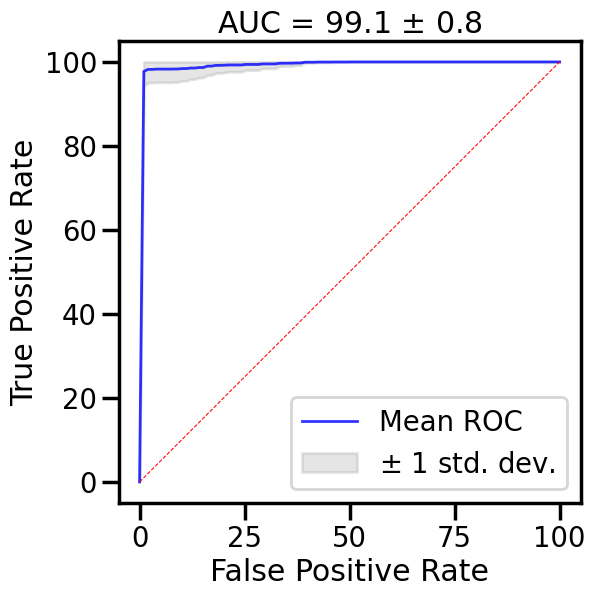

In [112]:
healthy_ds = {}
healthy_labels = {}
for rpm in rpms:
    ds = repetition_query_healthy_distances[f"0_{rpm}"]
    healthy_ds[f"{rpm}"] = ds
    healthy_labels[f"{rpm}"] = np.zeros_like(ds)

faulty_ds = {}
faulty_labels = {}
for rpm in rpms:
    faulty_ds[f"{rpm}"] = []
    faulty_labels[f"{rpm}"] = []

    for fault in faults:
        ds = repetition_query_distances[f"{fault}_{rpm}"]
        faulty_ds[f"{rpm}"].extend(ds)
        faulty_labels[f"{rpm}"].extend(np.ones_like(ds))

cases = []
for rpm in rpms:
    cases.append(
        {
            "labels": np.concatenate(
                [healthy_labels[f"{rpm}"], faulty_labels[f"{rpm}"]]
            ),
            "scores": np.concatenate([healthy_ds[f"{rpm}"], faulty_ds[f"{rpm}"]]),
        }
    )

fig, ax = plt.subplots(figsize=(6, 6))
# fig, ax = plt.subplots(2, 1, figsize=(6, 6))

fprs = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, case in enumerate(cases[:]):
    # print(case["labels"].shape)
    # print(case["scores"].shape)

    # viz = RocCurveDisplay.from_predictions(
    #     case["labels"],
    #     case["scores"],
    #     name=f"_{case_names[i]}",
    #     alpha=0.3,
    #     lw=1,
    #     # ax=ax,
    #     # plot_chance_level=False,
    #     plot_chance_level=(i == len(cases) - 1),
    # )

    fpr, tpr, _ = roc_curve(case["labels"], case["scores"], drop_intermediate=True)
    roc_auc = roc_auc_score(case["labels"], case["scores"])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    # interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    # aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr * 100,
    mean_tpr * 100,
    color="b",
    label=r"Mean ROC",
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr * 100,
    tprs_lower * 100,
    tprs_upper * 100,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}",
    # title=f"AUC = {mean_auc*100:.1f} $\pm$ {std_auc * 100:.1f}\n(Positive label 'Faulty')",
)
ax.axis("square")
ax.legend(
    loc="lower right",
)
sns.lineplot(
    x=[0, 100], y=[0, 100], color="red", linestyle="dashed", linewidth=0.75, ax=ax
)
plt.savefig("images/AD_ASD_T1_to_A3_ROC.svg")
plt.show()

In [113]:
rpm = 1500
faults = [1, 2, 3, 4, 5, 6, 7, 8, 9]

repetition_offset = 5  # * Change this to change between repetitions

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

for i in range(ensemble_size):
    # ensemble_support_groups.append({})
    # ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    # SUPPORT #
    support_group = (
        query_data[repetition_offset + i][
            (
                (query_data[repetition_offset + i]["rpm"] == rpm)
                & (query_data[repetition_offset + i]["class"] == 0)
            )
        ]
        .drop(["rpm", "class"], axis=1)
        .to_numpy()
    )

    ensemble_support_groups.append(support_group[: support_group.shape[0] // 2])
    # ensemble_support_groups[i][rpm] = support_group[: support_group.shape[0] // 2]

    # QUERY BASELINE #
    ensemble_query_healthy_groups.append(support_group[support_group.shape[0] // 2 :])
    # ensemble_query_healthy_groups[i][rpm] = support_group[support_group.shape[0] // 2 :]

    for fault in faults:
        # QUERY FAULTS #
        query_group = (
            query_data[repetition_offset + i][
                (query_data[repetition_offset + i]["rpm"] == rpm)
                & (query_data[repetition_offset + i]["class"] == fault)
            ]
            .drop(["rpm", "class"], axis=1)
            .to_numpy()
        )

        ensemble_query_groups[i][f"{fault}"] = query_group

> 1
SUPPORT
Mean:     0.75
Max:      3.85
Min:      0.10

QUERY
Mean:    35.20 |     0.69
Max:     48.52 |     2.86
Min:     23.19 |     0.21

> 2
SUPPORT
Mean:     0.75
Max:      3.85
Min:      0.10

QUERY
Mean:    40.94 |     0.69
Max:     58.63 |     2.86
Min:     25.45 |     0.21

> 3
SUPPORT
Mean:     0.75
Max:      3.85
Min:      0.10

QUERY
Mean:    49.10 |     0.69
Max:     71.70 |     2.86
Min:     28.93 |     0.21

> 4
SUPPORT
Mean:     0.75
Max:      3.85
Min:      0.10

QUERY
Mean:     6.64 |     0.69
Max:     10.37 |     2.86
Min:      3.18 |     0.21

> 5
SUPPORT
Mean:     0.75
Max:      3.85
Min:      0.10

QUERY
Mean:    14.29 |     0.69
Max:     28.02 |     2.86
Min:      5.37 |     0.21

> 6
SUPPORT
Mean:     0.75
Max:      3.85
Min:      0.10

QUERY
Mean:    26.21 |     0.69
Max:     49.70 |     2.86
Min:     14.93 |     0.21

> 7
SUPPORT
Mean:     0.75
Max:      3.85
Min:      0.10

QUERY
Mean:     6.16 |     0.69
Max:     12.53 |     2.86
Min:      3.31 |     0.21


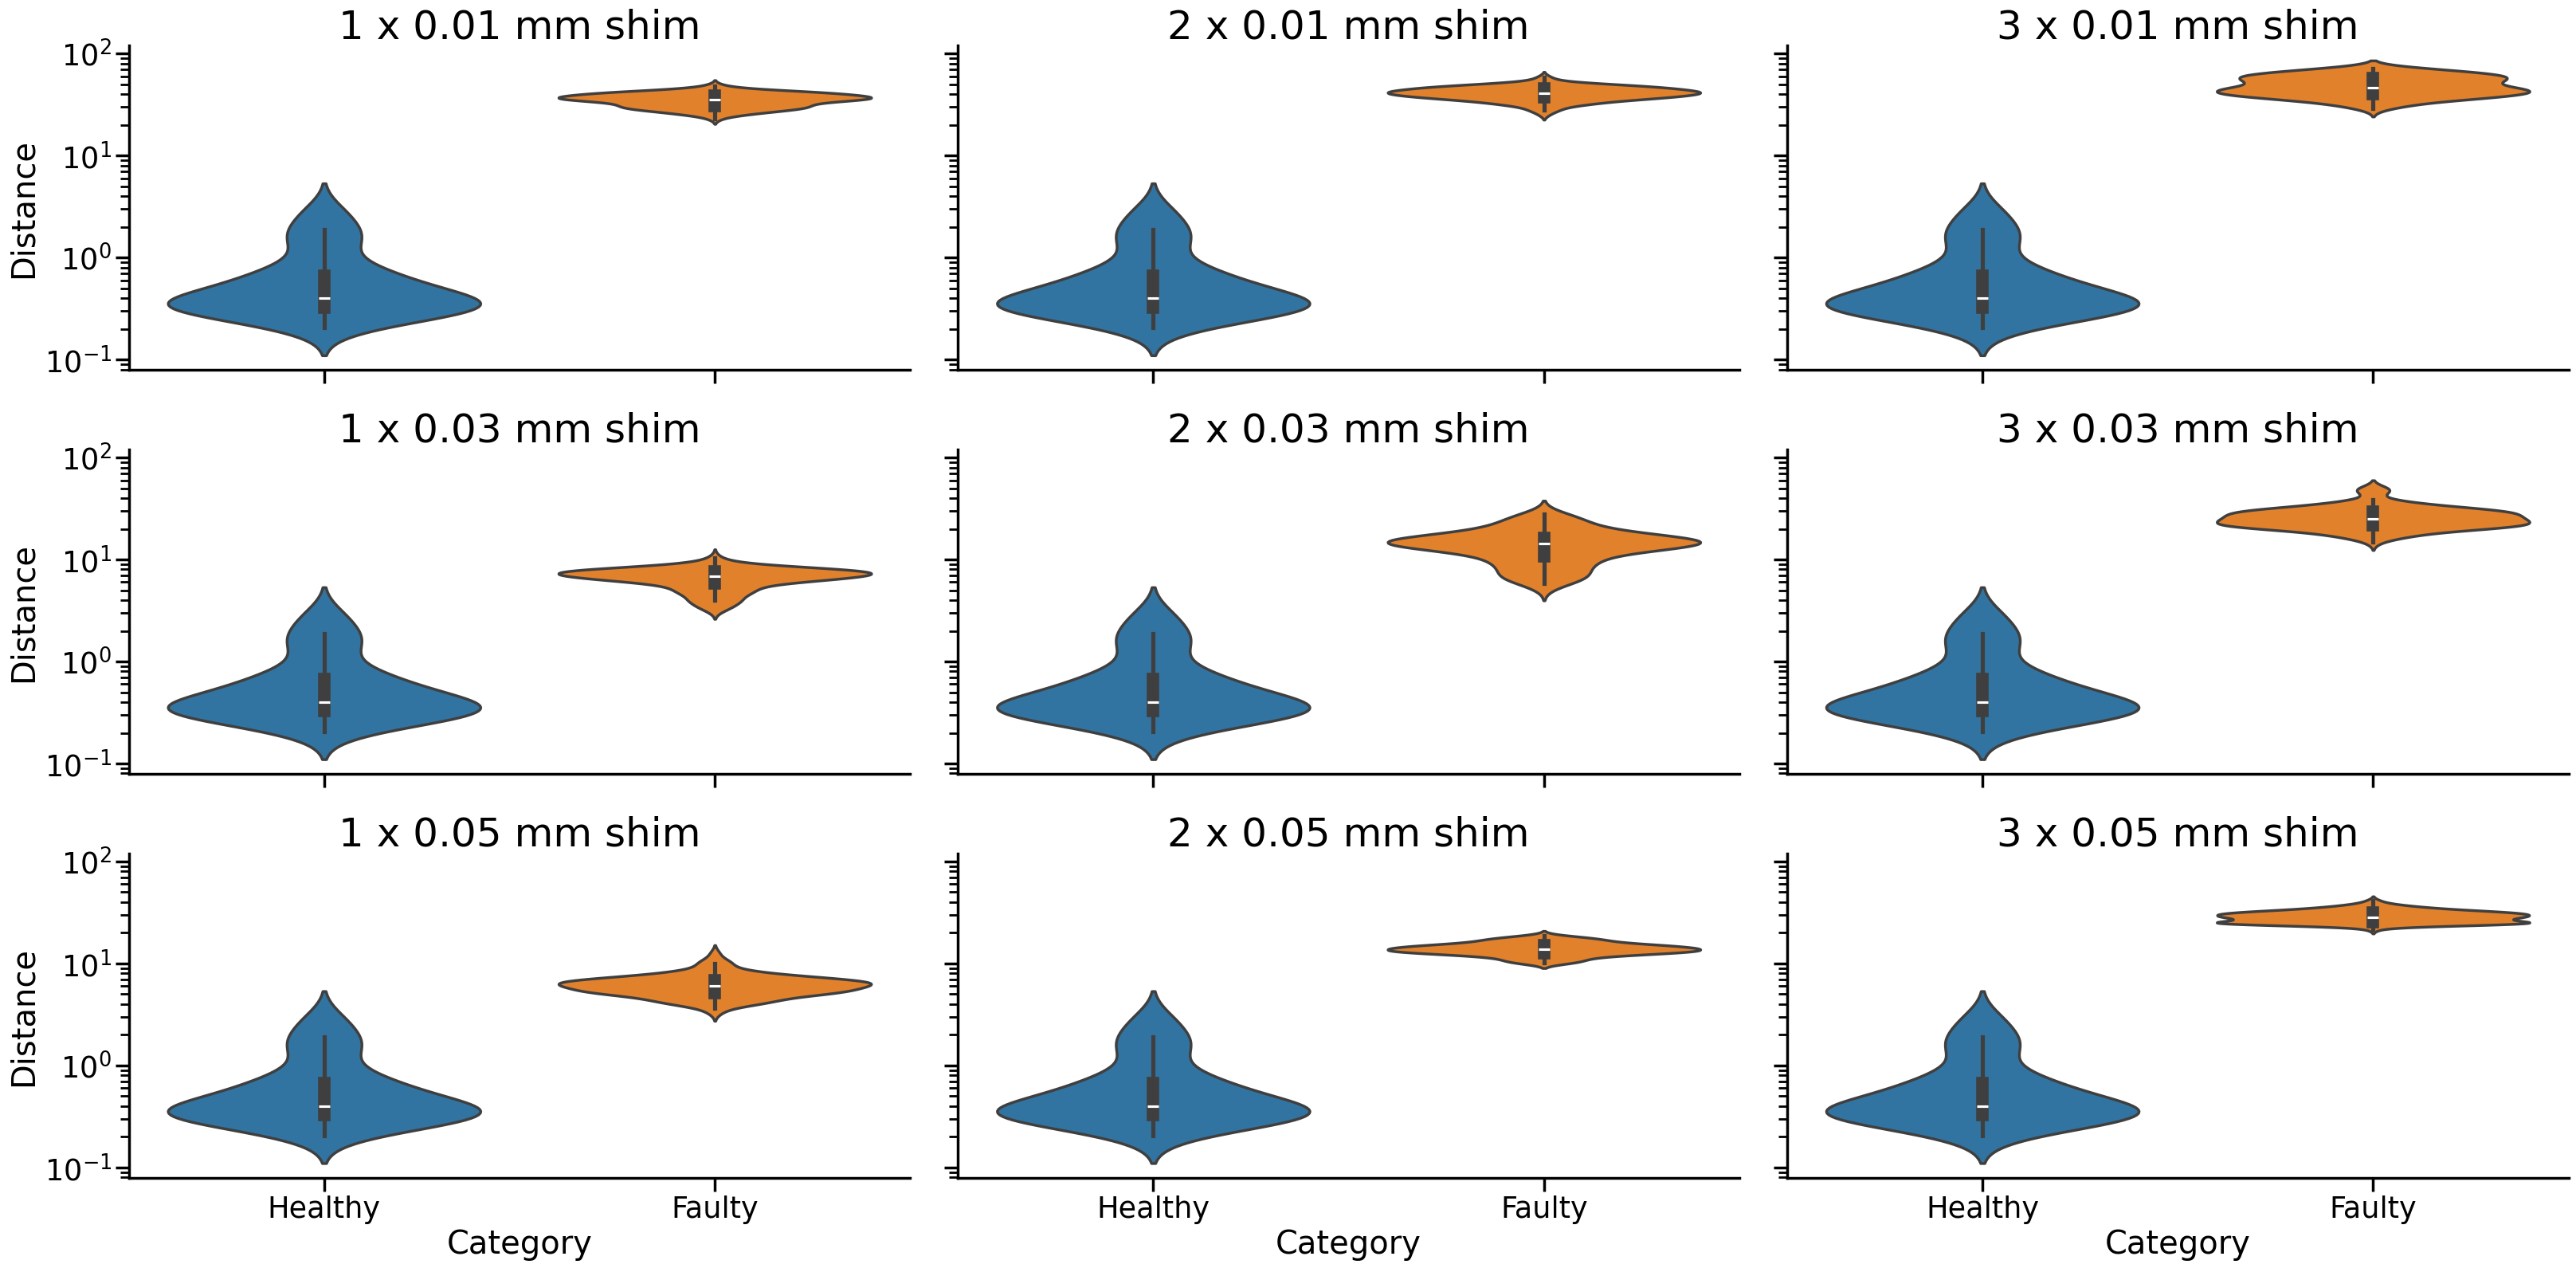

In [114]:
distance_metric = "L2"
# distance_metric = "mahalanobis"

all_support_distances = {}
all_query_healthy_distances = {}
all_query_distances = {}

for fault in faults:
    print(f"> {fault}")
    print("SUPPORT")

    ensemble_support_distances = []
    prototypes = []
    support_inv_cms = []

    # Ensemble loop
    for i in range(ensemble_size):
        prototype = ensemble_support_groups[i].mean(axis=0)
        prototypes.append(prototype)

        # Calculate distance
        if distance_metric == "L2":
            support_distances = distance(prototype, ensemble_support_groups[i])
        elif distance_metric == "mahalanobis":
            support_inv_cm = np.linalg.pinv(
                np.cov(ensemble_support_groups[i], rowvar=False)
            )
            support_inv_cms.append(support_inv_cm)
            support_distances = distance_mahalanobis(
                prototype,
                ensemble_support_groups[i],
                support_inv_cm,
            )
        else:
            raise Exception("WAT")
        ensemble_support_distances.append(support_distances)

    # Ensemble average
    # Support
    mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(axis=-1)
    all_support_distances[f"{fault}"] = mean_support_distances

    print("Mean: {:>8.2f}".format(mean_support_distances.mean()))
    print("Max:  {:>8.2f}".format(mean_support_distances.max()))
    print("Min:  {:>8.2f}".format(mean_support_distances.min()))
    print()

    print("QUERY")

    ensemble_query_healthy_distances = []
    ensemble_query_distances = []

    for i in range(ensemble_size):
        if distance_metric == "L2":
            # Query healthy
            query_healthy_distances = distance(
                prototypes[i],
                ensemble_query_healthy_groups[i],
            )
            # Faults
            query_distances = distance(
                prototypes[i], ensemble_query_groups[i][f"{fault}"]
            )
        elif distance_metric == "mahalanobis":
            # Query healthy
            query_healthy_distances = distance_mahalanobis(
                prototypes[i],
                ensemble_query_healthy_groups[i],
                support_inv_cms[i],
            )
            # Faults
            query_distances = distance_mahalanobis(
                prototypes[i],
                ensemble_query_groups[i][f"{fault}"],
                support_inv_cms[i],
            )
        ensemble_query_healthy_distances.append(query_healthy_distances)
        ensemble_query_distances.append(query_distances)

    # Ensemble averages
    # Query healthy
    mean_query_healthy_distances = np.stack(
        ensemble_query_healthy_distances, axis=-1
    ).mean(axis=-1)
    all_query_healthy_distances[f"{fault}"] = mean_query_healthy_distances

    # Faults
    mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(axis=-1)
    all_query_distances[f"{fault}"] = mean_query_distances

    print(
        "Mean: {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.mean(), mean_query_healthy_distances.mean()
        )
    )
    print(
        "Max:  {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.max(), mean_query_healthy_distances.max()
        )
    )
    print(
        "Min:  {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.min(), mean_query_healthy_distances.min()
        )
    )
    print()

# Plotting
fault_type_map = {
    "1": "1 x 0.01 mm shim",
    "2": "2 x 0.01 mm shim",
    "3": "3 x 0.01 mm shim",
    "4": "1 x 0.03 mm shim",
    "5": "2 x 0.03 mm shim",
    "6": "3 x 0.03 mm shim",
    "7": "1 x 0.05 mm shim",
    "8": "2 x 0.05 mm shim",
    "9": "3 x 0.05 mm shim",
}

df = []
for fault in faults:
    full_fault = f"{fault}"

    # tmp_1 = pd.DataFrame(all_support_distances[full_fault], columns=["distance"])
    # tmp_1["Category"] = "Support"
    # tmp_1["fault"] = full_fault
    tmp_2 = pd.DataFrame(all_query_healthy_distances[full_fault], columns=["Distance"])
    tmp_2["Category"] = "Healthy"
    tmp_2["Fault"] = fault_type_map[full_fault]
    tmp_3 = pd.DataFrame(all_query_distances[full_fault], columns=["Distance"])
    tmp_3["Category"] = "Faulty"
    # tmp_3["Fault"] = full_fault
    tmp_3["Fault"] = fault_type_map[full_fault]

    # df.append(tmp_1)
    df.append(tmp_2)
    df.append(tmp_3)

df = pd.concat(df)

with sns.plotting_context("poster", font_scale=1.2):
    g = sns.catplot(
        df,
        x="Category",
        y="Distance",
        hue="Category",
        col="Fault",
        col_wrap=3,
        log_scale=True,
        height=5.5,
        aspect=2,
        kind="violin",
        # palette=sns.color_palette("Paired"),
        legend=False,
        # width=2.1,
    )
    # plt.tight_layout()
    g.set_titles(col_template="{col_name}", size=36)

    plt.savefig(
        "images/AD_ASD_T1_to_A3_distances.pdf", format="pdf", bbox_inches="tight"
    )

# TODO TODO TODO


---
---

---

# OLD


# Trained w/ ASD (New setup)


In [51]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

query_data = []
num_repetitions = 5
ensemble_size = 5

for i in range(num_repetitions * ensemble_size):
    query_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                # "anomality_detection_arotor_replication",
                "anomality_detection_arotor_replication_norm_new_2",
                # "anomality_detection_arotor_replication_32_norm_new",
                # "anomality_detection_arotor_replication_torque2_32_norm_new",
                # "anomality_detection_arotor_replication_acc3",
                # "anomality_detection_arotor_replication_acc3_32",
                # "anomality_detection_arotor_replication_acc3_32_norm",
                # "anomality_detection_arotor_replication_acc3_32_norm_new",
                f"query_{i}.feather",
            )
        )
    )

print("Number of models: ", len(query_data))
print("Queries:", query_data[0].shape)

fault_GP_map = {
    "mild_micropitting": 4,
    "severe_micropitting": 3,
    "mild_pitting": 1,
    "severe_pitting": 6,
    "mild_wear": 7,
    "severe_wear": 2,
    "mild_tff": 9,
    "severe_tff": 5,
}


def distance_mahalanobis(prototype, queries, inv_cm):
    return np.array([mahalanobis(x, prototype, inv_cm) for x in queries])


def distance(prototype, queries):
    return np.sum((queries - prototype) ** 2, axis=1)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hamalaa14/git/fewshot-framework/reports/processed/../../reports/RAW/embedding_databases/anomality_detection_arotor_replication_norm_new_2/query_0.feather'

## Results


In [ ]:
rpms = [500, 750, 1250, 1500]
# rpm = 1500
torques = [1, 6, 11]
severities = ["mild", "severe"]
faults = ["micropitting", "pitting", "wear", "tff"]
# installation = [1]
installation = [1, 2]
# GPs = [2, 3, 5, 6]

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

assert (
    len(query_data) == num_repetitions * ensemble_size
), f"len(query_data) != num_repetitions * ensemble_size, {len(query_data)} != {num_repetitions * ensemble_size}"

for i in range(len(query_data)):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    full_fault = f"{severity} {fault} {rpm} {torque}"
                    # SUPPORT #
                    support_group = (
                        query_data[i][
                            (query_data[i]["rpm"] == rpm)
                            & (
                                query_data[i]["severity"]
                                == str(fault_GP_map[f"{severity}_{fault}"])
                            )
                            & (query_data[i]["torque"] == torque)
                        ]
                        .drop(
                            ["rpm", "severity", "fault", "installation", "torque"],
                            axis=1,
                        )
                        .to_numpy()
                    )
                    # Check if NaNs
                    if np.sum(~np.isfinite(support_group)) != 0:
                        print("NaN detected in {full_fault}!")
                        print(support_group)
                        raise

                    # * 50/50 split on baseline measurements to support and query
                    ensemble_support_groups[i][f"{severity}_{fault}_{rpm}_{torque}"] = (
                        support_group[: support_group.shape[0] // 2]
                    )

                    # QUERY BASELINE #
                    ensemble_query_healthy_groups[i][
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = support_group[support_group.shape[0] // 2 :]

                    # QUERY FAULTS #
                    query_group = (
                        query_data[i][
                            (query_data[i]["rpm"] == rpm)
                            & (query_data[i]["severity"] == severity)
                            & (query_data[i]["torque"] == torque)
                            & (query_data[i]["installation"].isin(installation))
                            & (query_data[i]["fault"] == fault)
                        ]
                        .drop(
                            ["rpm", "severity", "fault", "installation", "torque"],
                            axis=1,
                        )
                        .to_numpy()
                    )

                    # Check if NaNs
                    if np.sum(~np.isfinite(query_group)) != 0:
                        print("NaN detected in {full_fault}!")
                        print(query_group)
                        raise

                    ensemble_query_groups[i][
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = query_group

16940 / 16940 = 100.0%
17006 / 17135 = 99.24715494601692%
10595 / 131750 = 8.041745730550284%


[Text(0.5, 23.52222222222222, 'Predicted label'),
 Text(50.722222222222214, 0.5, 'True label')]

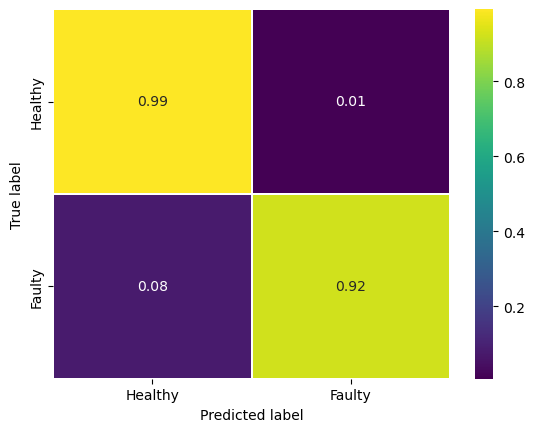

In [ ]:
def distance_calculation(
    ensemble_support_groups,
    ensemble_query_healthy_groups,
    ensemble_query_groups,
    distance_metric,
    repetition_offset,
):
    all_support_distances = {}
    all_query_healthy_distances = {}
    all_query_distances = {}

    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    # print(f"> {severity} {fault} {rpm} {torque}")
                    # print("SUPPORT")

                    ensemble_support_distances = []
                    prototypes = []
                    support_inv_cms = []

                    # Ensemble loop
                    for i in range(ensemble_size):
                        prototype = ensemble_support_groups[repetition_offset + i][
                            f"{severity}_{fault}_{rpm}_{torque}"
                        ].mean(axis=0)
                        prototypes.append(prototype)

                        # Calculate distance
                        if distance_metric == "L2":
                            support_distances = distance(
                                prototype,
                                ensemble_support_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                        elif distance_metric == "mahalanobis":
                            support_inv_cm = np.linalg.pinv(
                                np.cov(
                                    ensemble_support_groups[repetition_offset + i][
                                        f"{severity}_{fault}_{rpm}_{torque}"
                                    ],
                                    rowvar=False,
                                )
                            )
                            support_inv_cms.append(support_inv_cm)
                            support_distances = distance_mahalanobis(
                                prototype,
                                ensemble_support_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cm,
                            )
                        else:
                            raise Exception("WAT")
                        ensemble_support_distances.append(support_distances)

                    # Ensemble average
                    mean_support_distances = np.stack(
                        ensemble_support_distances, axis=-1
                    ).mean(axis=-1)
                    all_support_distances[f"{severity}_{fault}_{rpm}_{torque}"] = (
                        mean_support_distances
                    )

                    # print("QUERY")

                    ensemble_query_healthy_distances = []
                    ensemble_query_distances = []

                    for i in range(ensemble_size):
                        if distance_metric == "L2":
                            # Query healthy
                            query_healthy_distances = distance(
                                prototypes[i],
                                ensemble_query_healthy_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                            # Faults
                            query_distances = distance(
                                prototypes[i],
                                ensemble_query_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                            )
                        elif distance_metric == "mahalanobis":
                            # Query healthy
                            query_healthy_distances = distance_mahalanobis(
                                prototypes[i],
                                ensemble_query_healthy_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cms[i],
                            )
                            # Faults
                            query_distances = distance_mahalanobis(
                                prototypes[i],
                                ensemble_query_groups[repetition_offset + i][
                                    f"{severity}_{fault}_{rpm}_{torque}"
                                ],
                                support_inv_cms[i],
                            )
                        ensemble_query_healthy_distances.append(query_healthy_distances)
                        ensemble_query_distances.append(query_distances)

                    # Ensemble averages
                    mean_query_healthy_distances = np.stack(
                        ensemble_query_healthy_distances, axis=-1
                    ).mean(axis=-1)
                    all_query_healthy_distances[
                        f"{severity}_{fault}_{rpm}_{torque}"
                    ] = mean_query_healthy_distances

                    mean_query_distances = np.stack(
                        ensemble_query_distances, axis=-1
                    ).mean(axis=-1)
                    all_query_distances[f"{severity}_{fault}_{rpm}_{torque}"] = (
                        mean_query_distances
                    )

    return all_support_distances, all_query_healthy_distances, all_query_distances


repetition_distances = []  # list<(support, query, query_healthy)>

for repetition_offset in range(
    0, num_repetitions * ensemble_size, ensemble_size
):  # range(0, 25, 5)
    repetition_distances.append(
        distance_calculation(
            ensemble_support_groups,
            ensemble_query_healthy_groups,
            ensemble_query_groups,
            "mahalanobis",
            # "L2",
            repetition_offset,
        )
    )

# Thresholding

support_under = 0
query_healthy_under = 0
query_under = 0

support_total = 0
query_healthy_total = 0
query_total = 0

for (
    repetition_support_distances,
    repetition_query_healthy_distances,
    repetition_query_distances,
) in repetition_distances:
    for fault in faults:
        for severity in severities:
            for rpm in rpms:
                for torque in torques:
                    full_class = f"{severity}_{fault}_{rpm}_{torque}"

                    limit = 10 * np.max(repetition_support_distances[full_class])
                    # std = np.std(repetition_support_distances[full_class])
                    # limit = 20 * std

                    support_under += np.sum(
                        repetition_support_distances[full_class] < limit
                    )
                    support_total += len(repetition_support_distances[full_class])

                    query_healthy_under += np.sum(
                        repetition_query_healthy_distances[full_class] < limit
                    )
                    query_healthy_total += len(
                        repetition_query_healthy_distances[full_class]
                    )

                    query_under += np.sum(
                        repetition_query_distances[full_class] < limit
                    )
                    query_total += len(repetition_query_distances[full_class])

print(f"{support_under} / {support_total} = {support_under / support_total * 100}%")
print(
    f"{query_healthy_under} / {query_healthy_total} = {query_healthy_under / query_healthy_total * 100}%"
)
print(f"{query_under} / {query_total} = {query_under / query_total * 100}%")

# Plotting

cf_agg = np.array(
    [
        [
            query_healthy_under / query_healthy_total,
            (query_healthy_total - query_healthy_under) / query_healthy_total,
        ],
        [query_under / query_total, (query_total - query_under) / query_total],
    ]
)
categories = ["Healthy", "Faulty"]

ax = sns.heatmap(
    cf_agg,
    annot=True,
    fmt=".2f",
    linewidth=0.3,
    xticklabels=categories,
    yticklabels=categories,
    cmap="viridis",
)
ax.set(xlabel="Predicted label", ylabel="True label")

### ROC & AUC


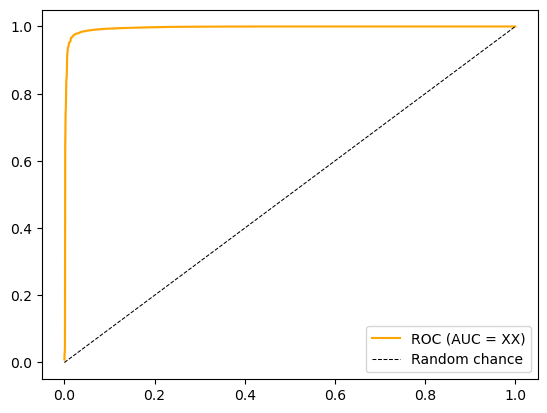

In [ ]:
healthy = np.concatenate(
    [x for x in repetition_query_healthy_distances.values()]
).flatten()
healthy_labels = np.zeros_like(healthy)

faulty = np.concatenate([x for x in repetition_query_distances.values()]).flatten()
faulty_labels = np.ones_like(faulty)

y_true = np.concatenate([healthy_labels, faulty_labels])
y_score = np.concatenate([healthy, faulty])

fpr, tpr, thresholds = roc_curve(y_true, y_score)

fig, ax = plt.subplots(1, 1)

sns.lineplot(x=fpr, y=tpr, color="orange", ax=ax)
sns.lineplot(
    x=[0, 1], y=[0, 1], color="black", linestyle="dashed", linewidth=0.75, ax=ax
)

ax.legend(handles=ax.lines, labels=["ROC (AUC = XX)", "Random chance"])

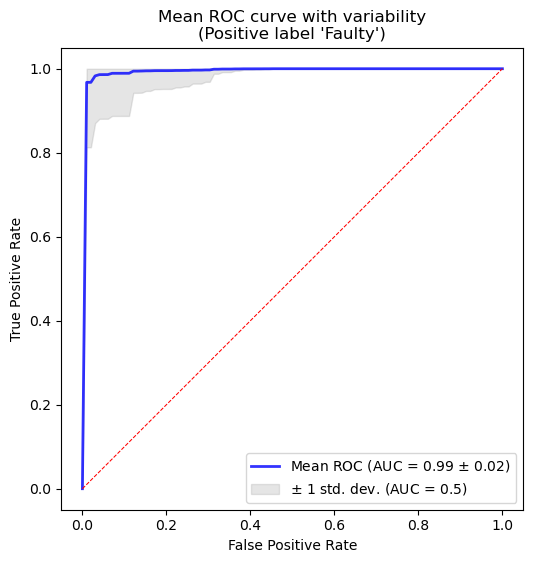

In [ ]:
healthy = [
    np.array([x, np.zeros_like(x)]) for x in repetition_query_healthy_distances.values()
]
query = [np.array([x, np.ones_like(x)]) for x in repetition_query_distances.values()]

case_names = list(repetition_query_healthy_distances.keys())

cases = []
for i in range(len(healthy)):
    cases.append(
        {
            "labels": np.concatenate([healthy[i][1], query[i][1]]),
            "scores": np.concatenate([healthy[i][0], query[i][0]]),
        }
    )

fig, ax = plt.subplots(figsize=(6, 6))
# fig, ax = plt.subplots(2, 1, figsize=(6, 6))

fprs = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, case in enumerate(cases[:]):
    # print(case["labels"].shape)
    # print(case["scores"].shape)

    # viz = RocCurveDisplay.from_predictions(
    #     case["labels"],
    #     case["scores"],
    #     name=f"_{case_names[i]}",
    #     alpha=0.3,
    #     lw=1,
    #     # ax=ax,
    #     # plot_chance_level=False,
    #     plot_chance_level=(i == len(cases) - 1),
    # )

    fpr, tpr, _ = roc_curve(case["labels"], case["scores"], drop_intermediate=True)
    roc_auc = roc_auc_score(case["labels"], case["scores"])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    # interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    # aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev. (AUC = 0.5)",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'Faulty')",
)
ax.axis("square")
ax.legend(
    loc="lower right",
)
sns.lineplot(x=[0, 1], y=[0, 1], color="red", linestyle="dashed", linewidth=0.75, ax=ax)
plt.show()

## More detailed look


In [ ]:
rpm = 1500
# rpm = 1500
torque = 1
severities = ["mild", "severe"]
faults = ["micropitting", "pitting", "wear", "tff"]
# installation = [1]
installation = [1, 2]
# GPs = [2, 3, 5, 6]

repetition_offset = 5  # * Change this to change between repetitions

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

for i in range(ensemble_size):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for fault in faults:
        for severity in severities:
            # SUPPORT #
            support_group = (
                query_data[repetition_offset + i][
                    (query_data[repetition_offset + i]["rpm"] == rpm)
                    & (
                        query_data[repetition_offset + i]["severity"]
                        == str(fault_GP_map[f"{severity}_{fault}"])
                    )
                    & (query_data[repetition_offset + i]["torque"] == torque)
                ]
                .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
                .to_numpy()
            )

            ensemble_support_groups[i][f"{severity}_{fault}"] = support_group[
                : support_group.shape[0] // 2
            ]

            # QUERY BASELINE #
            ensemble_query_healthy_groups[i][f"{severity}_{fault}"] = support_group[
                support_group.shape[0] // 2 :
            ]

            # QUERY FAULTS #
            query_group = (
                query_data[repetition_offset + i][
                    (query_data[repetition_offset + i]["rpm"] == rpm)
                    & (query_data[repetition_offset + i]["severity"] == severity)
                    & (query_data[repetition_offset + i]["torque"] == torque)
                    & (
                        query_data[repetition_offset + i]["installation"].isin(
                            installation
                        )
                    )
                    & (query_data[repetition_offset + i]["fault"] == fault)
                ]
                .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
                .to_numpy()
            )

            ensemble_query_groups[i][f"{severity}_{fault}"] = query_group

> mild micropitting
SUPPORT
Mean:     2.57
Max:      8.65
Min:      0.58

QUERY
Mean:   689.07 |     4.95
Max:   1674.77 |    10.77
Min:     47.44 |     2.51

> severe micropitting
SUPPORT
Mean:     5.37
Max:     16.87
Min:      0.87

QUERY
Mean:   363.74 |    21.22
Max:    734.85 |    41.53
Min:    115.84 |     5.39

> mild pitting
SUPPORT
Mean:     5.61
Max:     20.13
Min:      0.89

QUERY
Mean:   642.69 |    15.68
Max:   1228.46 |    34.23
Min:    265.33 |     6.96

> severe pitting
SUPPORT
Mean:     3.51
Max:      9.29
Min:      1.07

QUERY
Mean:   946.65 |     4.34
Max:   1370.78 |     8.95
Min:    561.70 |     1.67

> mild wear
SUPPORT
Mean:     3.76
Max:     13.45
Min:      0.93

QUERY
Mean:   192.15 |     9.56
Max:    275.51 |    19.85
Min:     93.36 |     2.96

> severe wear
SUPPORT
Mean:     2.16
Max:      4.44
Min:      0.79

QUERY
Mean:   727.32 |    19.46
Max:   1313.72 |   358.45
Min:    261.10 |     1.85

> mild tff
SUPPORT
Mean:     3.02
Max:     15.25
Min:      0.78

Q

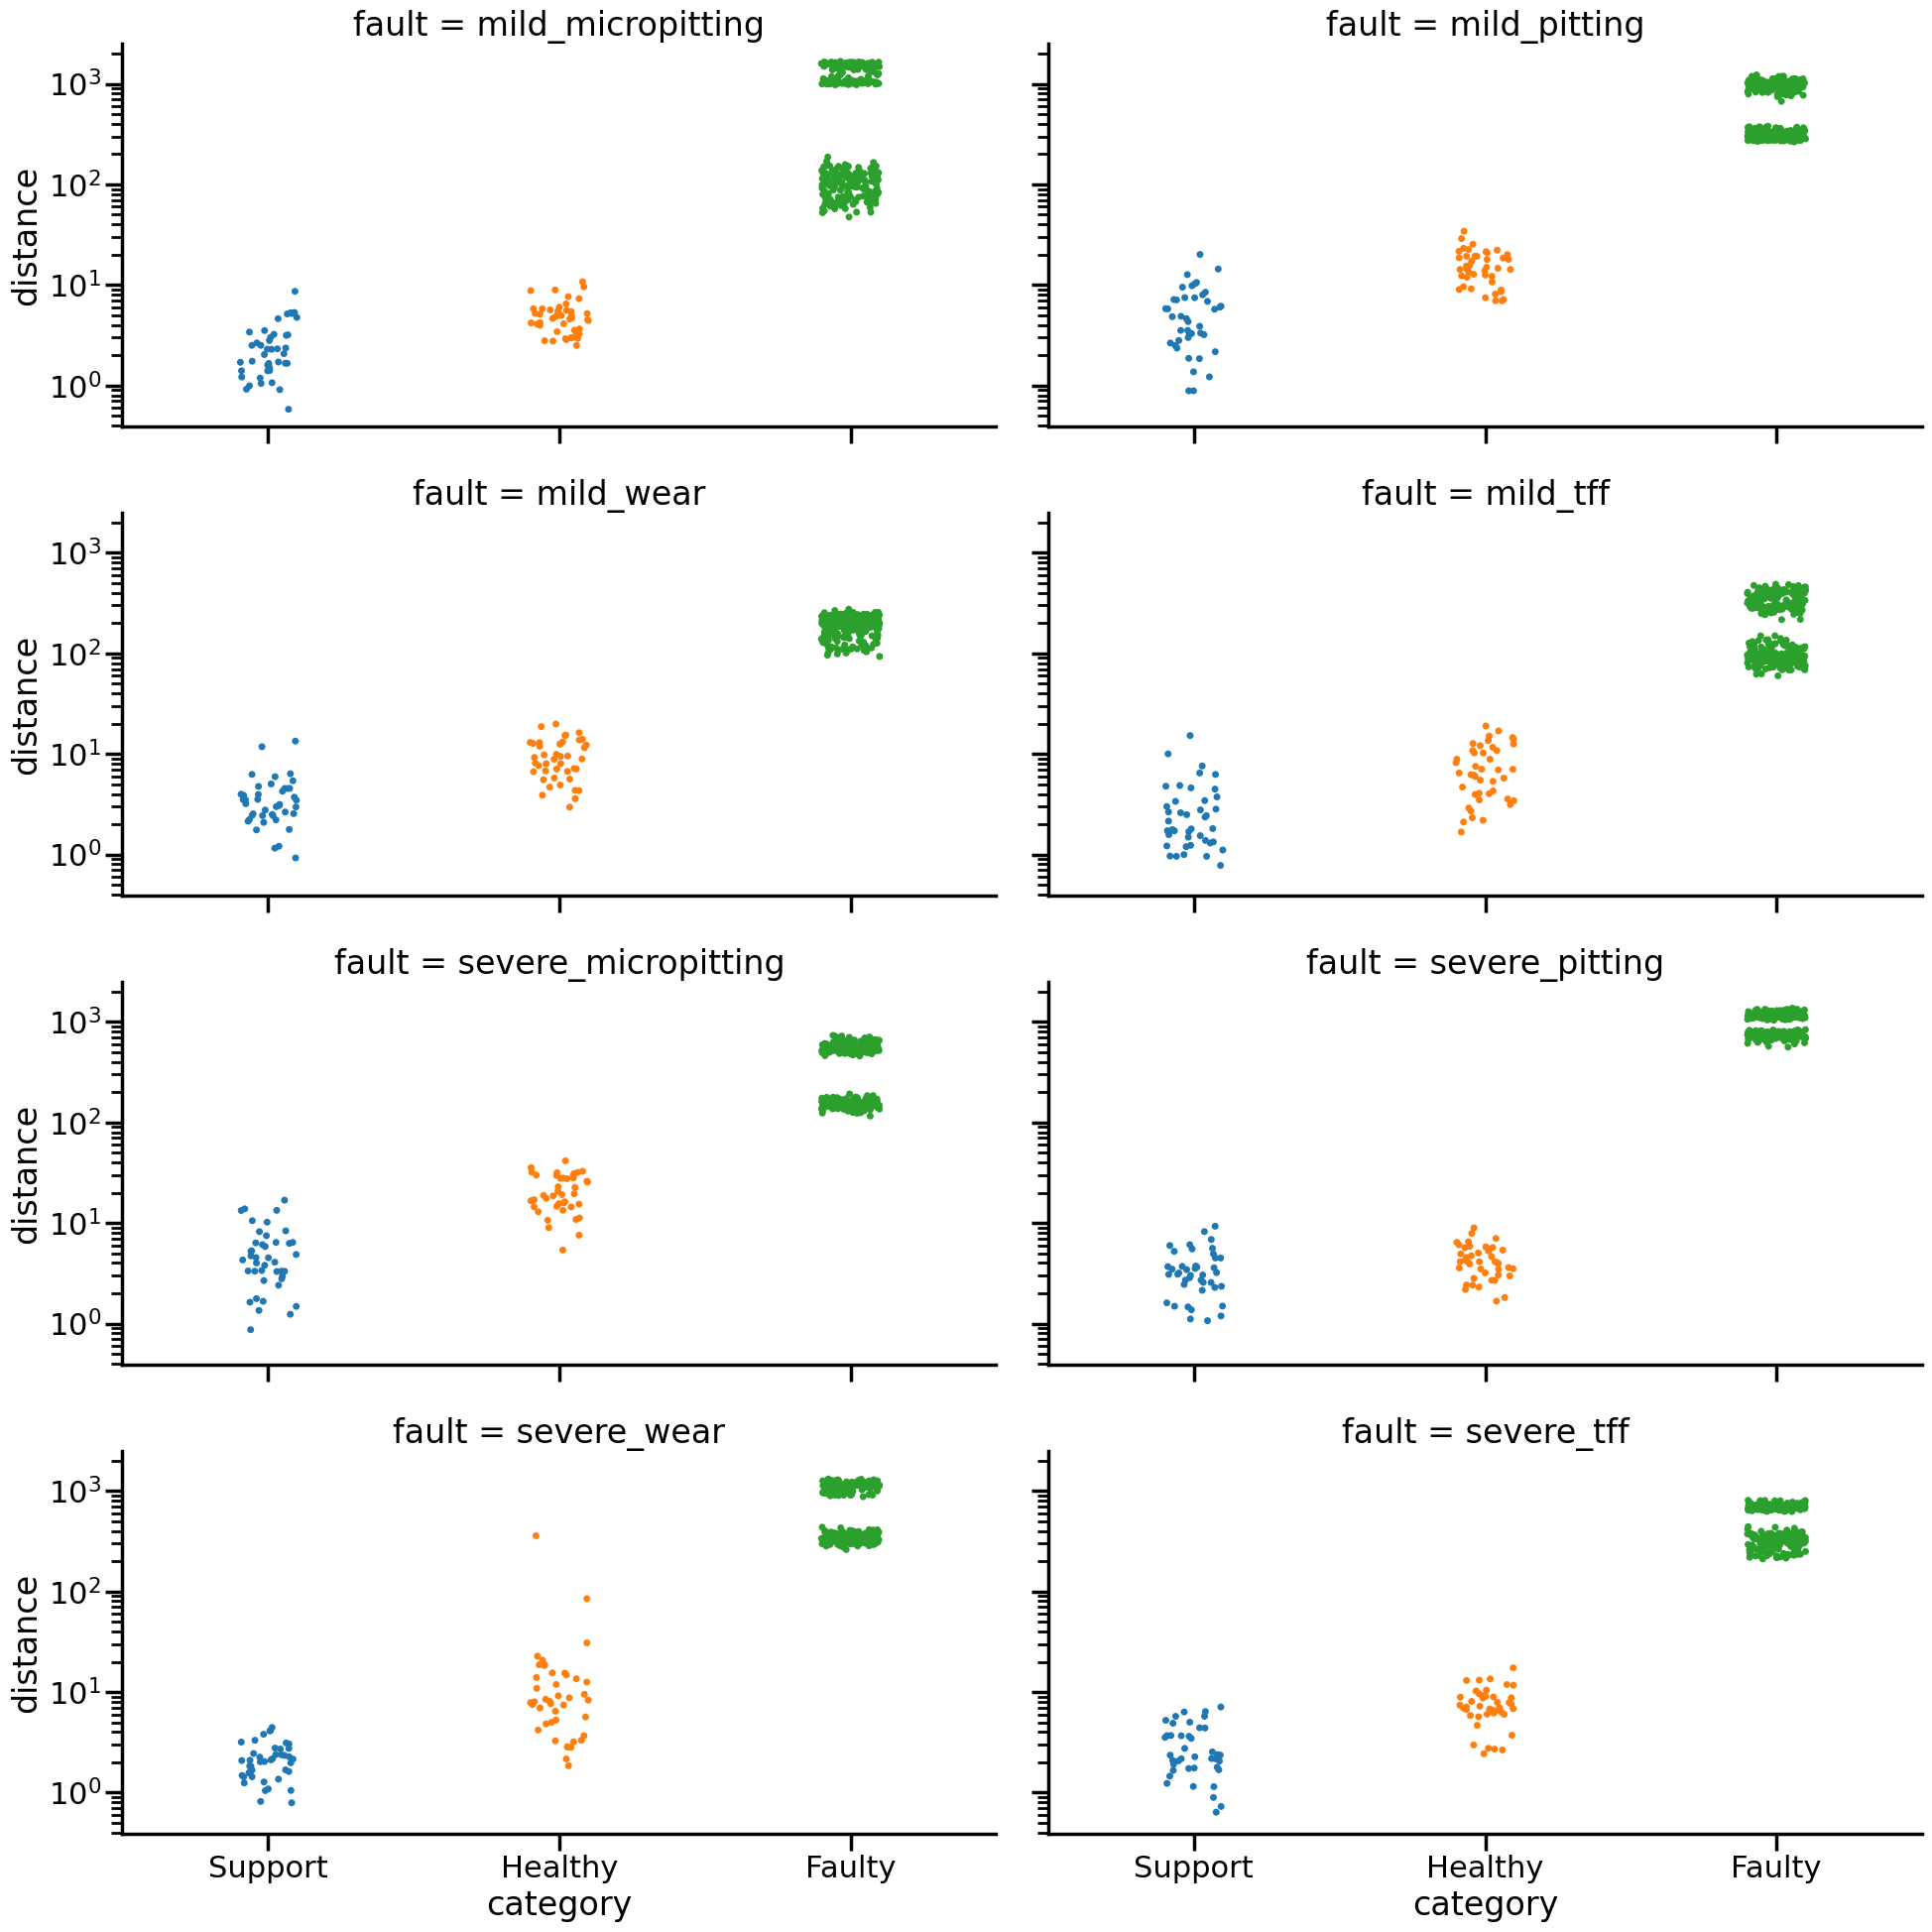

In [ ]:
distance_metric = "L2"
# distance_metric = "mahalanobis"

all_support_distances = {}
all_query_healthy_distances = {}
all_query_distances = {}

for fault in faults:
    for severity in severities:
        print(f"> {severity} {fault}")
        print("SUPPORT")

        ensemble_support_distances = []
        prototypes = []
        support_inv_cms = []

        # Ensemble loop
        for i in range(ensemble_size):
            prototype = ensemble_support_groups[i][f"{severity}_{fault}"].mean(axis=0)
            prototypes.append(prototype)

            # Calculate distance
            if distance_metric == "L2":
                support_distances = distance(
                    prototype, ensemble_support_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                support_inv_cm = np.linalg.pinv(
                    np.cov(
                        ensemble_support_groups[i][f"{severity}_{fault}"], rowvar=False
                    )
                )
                support_inv_cms.append(support_inv_cm)
                support_distances = distance_mahalanobis(
                    prototype,
                    ensemble_support_groups[i][f"{severity}_{fault}"],
                    support_inv_cm,
                )
            else:
                raise Exception("WAT")
            ensemble_support_distances.append(support_distances)

        # Ensemble average
        mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(
            axis=-1
        )
        all_support_distances[f"{severity}_{fault}"] = mean_support_distances

        print("Mean: {:>8.2f}".format(mean_support_distances.mean()))
        print("Max:  {:>8.2f}".format(mean_support_distances.max()))
        print("Min:  {:>8.2f}".format(mean_support_distances.min()))
        print()

        print("QUERY")

        ensemble_query_healthy_distances = []
        ensemble_query_distances = []

        for i in range(ensemble_size):
            if distance_metric == "L2":
                # Query healthy
                query_healthy_distances = distance(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                )
                # Faults
                query_distances = distance(
                    prototypes[i], ensemble_query_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                # Query healthy
                query_healthy_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
                # Faults
                query_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
            ensemble_query_healthy_distances.append(query_healthy_distances)
            ensemble_query_distances.append(query_distances)

        # Ensemble averages
        mean_query_healthy_distances = np.stack(
            ensemble_query_healthy_distances, axis=-1
        ).mean(axis=-1)
        all_query_healthy_distances[f"{severity}_{fault}"] = (
            mean_query_healthy_distances
        )

        mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(axis=-1)
        all_query_distances[f"{severity}_{fault}"] = mean_query_distances

        print(
            "Mean: {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.mean(), mean_query_healthy_distances.mean()
            )
        )
        print(
            "Max:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.max(), mean_query_healthy_distances.max()
            )
        )
        print(
            "Min:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.min(), mean_query_healthy_distances.min()
            )
        )
        print()

# Plotting

df = []
for severity in severities:
    for fault in faults:
        full_fault = f"{severity}_{fault}"

        tmp_1 = pd.DataFrame(all_support_distances[full_fault], columns=["distance"])
        tmp_1["category"] = "Support"
        tmp_1["fault"] = full_fault
        tmp_2 = pd.DataFrame(
            all_query_healthy_distances[full_fault], columns=["distance"]
        )
        tmp_2["category"] = "Healthy"
        tmp_2["fault"] = full_fault
        tmp_3 = pd.DataFrame(all_query_distances[full_fault], columns=["distance"])
        tmp_3["category"] = "Faulty"
        tmp_3["fault"] = full_fault

        df.append(tmp_1)
        df.append(tmp_2)
        df.append(tmp_3)

df = pd.concat(df)

with sns.plotting_context("poster"):
    sns.catplot(
        df,
        x="category",
        y="distance",
        hue="category",
        col="fault",
        col_wrap=2,
        log_scale=True,
        height=5,
        aspect=2,
        # palette=sns.color_palette("Paired"),
        legend=False,
    )

### Article distance


> mild micropitting
SUPPORT
Mean:     3.91
Max:      4.65
Min:      3.34

QUERY
Mean:   614.94 |     7.15
Max:   1527.15 |    12.33
Min:     42.32 |     5.06

> severe micropitting
SUPPORT
Mean:     3.92
Max:      5.11
Min:      3.35

QUERY
Mean:   347.85 |    11.40
Max:   1036.90 |    19.99
Min:     78.04 |     5.47

> mild pitting
SUPPORT
Mean:     3.92
Max:      4.75
Min:      3.05

QUERY
Mean:   359.04 |     8.72
Max:    771.09 |    13.70
Min:    134.13 |     5.11

> severe pitting
SUPPORT
Mean:     3.92
Max:      4.48
Min:      3.29

QUERY
Mean:   503.39 |     5.73
Max:    735.48 |     8.52
Min:    299.30 |     3.44

> mild wear
SUPPORT
Mean:     3.92
Max:      4.93
Min:      3.51

QUERY
Mean:    89.18 |     7.09
Max:    120.27 |    10.64
Min:     48.19 |     4.60

> severe wear
SUPPORT
Mean:     3.91
Max:      4.82
Min:      3.37

QUERY
Mean:   902.70 |    20.30
Max:   1905.46 |   344.54
Min:    272.22 |     4.52

> mild tff
SUPPORT
Mean:     3.91
Max:      5.40
Min:      3.18

Q

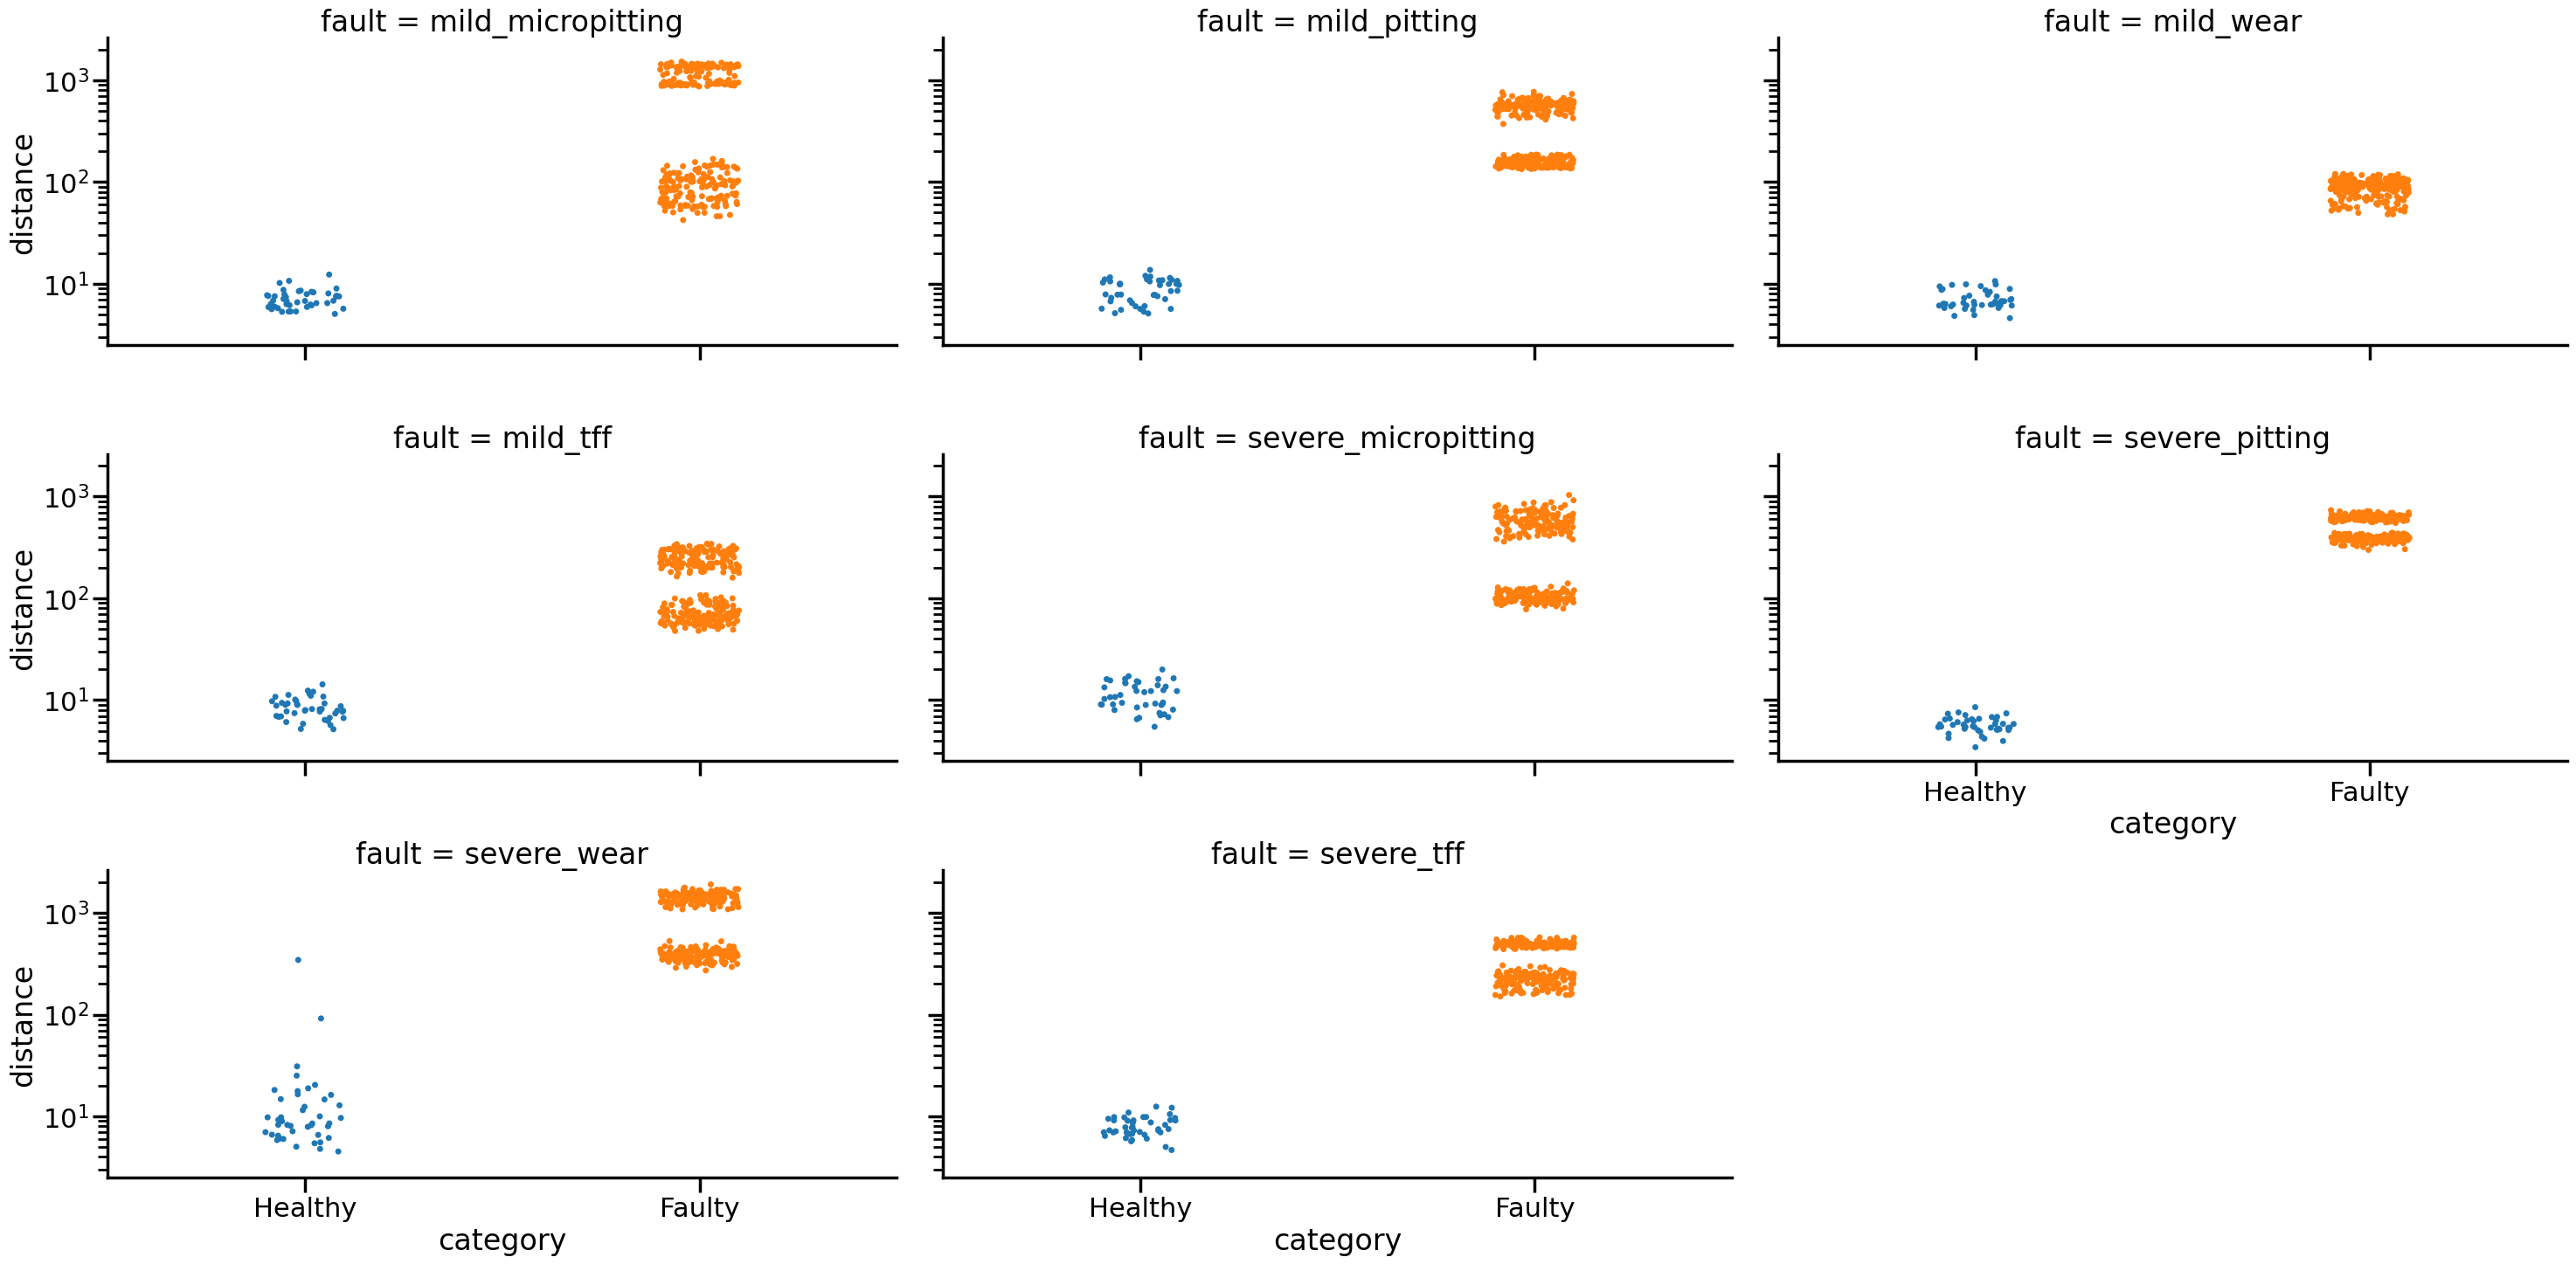

In [ ]:
# distance_metric = "L2"
distance_metric = "mahalanobis"

all_support_distances = {}
all_query_healthy_distances = {}
all_query_distances = {}

for fault in faults:
    for severity in severities:
        print(f"> {severity} {fault}")
        print("SUPPORT")

        ensemble_support_distances = []
        prototypes = []
        support_inv_cms = []

        # Ensemble loop
        for i in range(ensemble_size):
            prototype = ensemble_support_groups[i][f"{severity}_{fault}"].mean(axis=0)
            prototypes.append(prototype)

            # Calculate distance
            if distance_metric == "L2":
                support_distances = distance(
                    prototype, ensemble_support_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                support_inv_cm = np.linalg.pinv(
                    np.cov(
                        ensemble_support_groups[i][f"{severity}_{fault}"], rowvar=False
                    )
                )
                support_inv_cms.append(support_inv_cm)
                support_distances = distance_mahalanobis(
                    prototype,
                    ensemble_support_groups[i][f"{severity}_{fault}"],
                    support_inv_cm,
                )
            else:
                raise Exception("WAT")
            ensemble_support_distances.append(support_distances)

        # Ensemble average
        mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(
            axis=-1
        )
        all_support_distances[f"{severity}_{fault}"] = mean_support_distances

        print("Mean: {:>8.2f}".format(mean_support_distances.mean()))
        print("Max:  {:>8.2f}".format(mean_support_distances.max()))
        print("Min:  {:>8.2f}".format(mean_support_distances.min()))
        print()

        print("QUERY")

        ensemble_query_healthy_distances = []
        ensemble_query_distances = []

        for i in range(ensemble_size):
            if distance_metric == "L2":
                # Query healthy
                query_healthy_distances = distance(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                )
                # Faults
                query_distances = distance(
                    prototypes[i], ensemble_query_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                # Query healthy
                query_healthy_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
                # Faults
                query_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
            ensemble_query_healthy_distances.append(query_healthy_distances)
            ensemble_query_distances.append(query_distances)

        # Ensemble averages
        mean_query_healthy_distances = np.stack(
            ensemble_query_healthy_distances, axis=-1
        ).mean(axis=-1)
        all_query_healthy_distances[f"{severity}_{fault}"] = (
            mean_query_healthy_distances
        )

        mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(axis=-1)
        all_query_distances[f"{severity}_{fault}"] = mean_query_distances

        print(
            "Mean: {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.mean(), mean_query_healthy_distances.mean()
            )
        )
        print(
            "Max:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.max(), mean_query_healthy_distances.max()
            )
        )
        print(
            "Min:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.min(), mean_query_healthy_distances.min()
            )
        )
        print()

# Plotting

df = []
for severity in severities:
    for fault in faults:
        full_fault = f"{severity}_{fault}"

        tmp_1 = pd.DataFrame(all_support_distances[full_fault], columns=["distance"])
        tmp_1["category"] = "Support"
        tmp_1["fault"] = full_fault
        tmp_2 = pd.DataFrame(
            all_query_healthy_distances[full_fault], columns=["distance"]
        )
        tmp_2["category"] = "Healthy"
        tmp_2["fault"] = full_fault
        tmp_3 = pd.DataFrame(all_query_distances[full_fault], columns=["distance"])
        tmp_3["category"] = "Faulty"
        tmp_3["fault"] = full_fault

        # df.append(tmp_1)
        df.append(tmp_2)
        df.append(tmp_3)

df = pd.concat(df)

with sns.plotting_context("poster"):
    sns.catplot(
        df,
        x="category",
        y="distance",
        hue="category",
        col="fault",
        col_wrap=3,
        log_scale=True,
        height=5,
        aspect=2,
        # palette=sns.color_palette("Paired"),
        legend=False,
    )

> mild micropitting
SUPPORT
Mean:     3.91
Max:      4.65
Min:      3.34

QUERY
Mean:   614.94 |     7.15
Max:   1527.15 |    12.33
Min:     42.32 |     5.06

> severe micropitting
SUPPORT
Mean:     3.92
Max:      5.11
Min:      3.35

QUERY
Mean:   347.85 |    11.40
Max:   1036.90 |    19.99
Min:     78.04 |     5.47

> mild pitting
SUPPORT
Mean:     3.92
Max:      4.75
Min:      3.05

QUERY
Mean:   359.04 |     8.72
Max:    771.09 |    13.70
Min:    134.13 |     5.11

> severe pitting
SUPPORT
Mean:     3.92
Max:      4.48
Min:      3.29

QUERY
Mean:   503.39 |     5.73
Max:    735.48 |     8.52
Min:    299.30 |     3.44

> mild wear
SUPPORT
Mean:     3.92
Max:      4.93
Min:      3.51

QUERY
Mean:    89.18 |     7.09
Max:    120.27 |    10.64
Min:     48.19 |     4.60

> severe wear
SUPPORT
Mean:     3.91
Max:      4.82
Min:      3.37

QUERY
Mean:   902.70 |    20.30
Max:   1905.46 |   344.54
Min:    272.22 |     4.52

> mild tff
SUPPORT
Mean:     3.91
Max:      5.40
Min:      3.18

Q

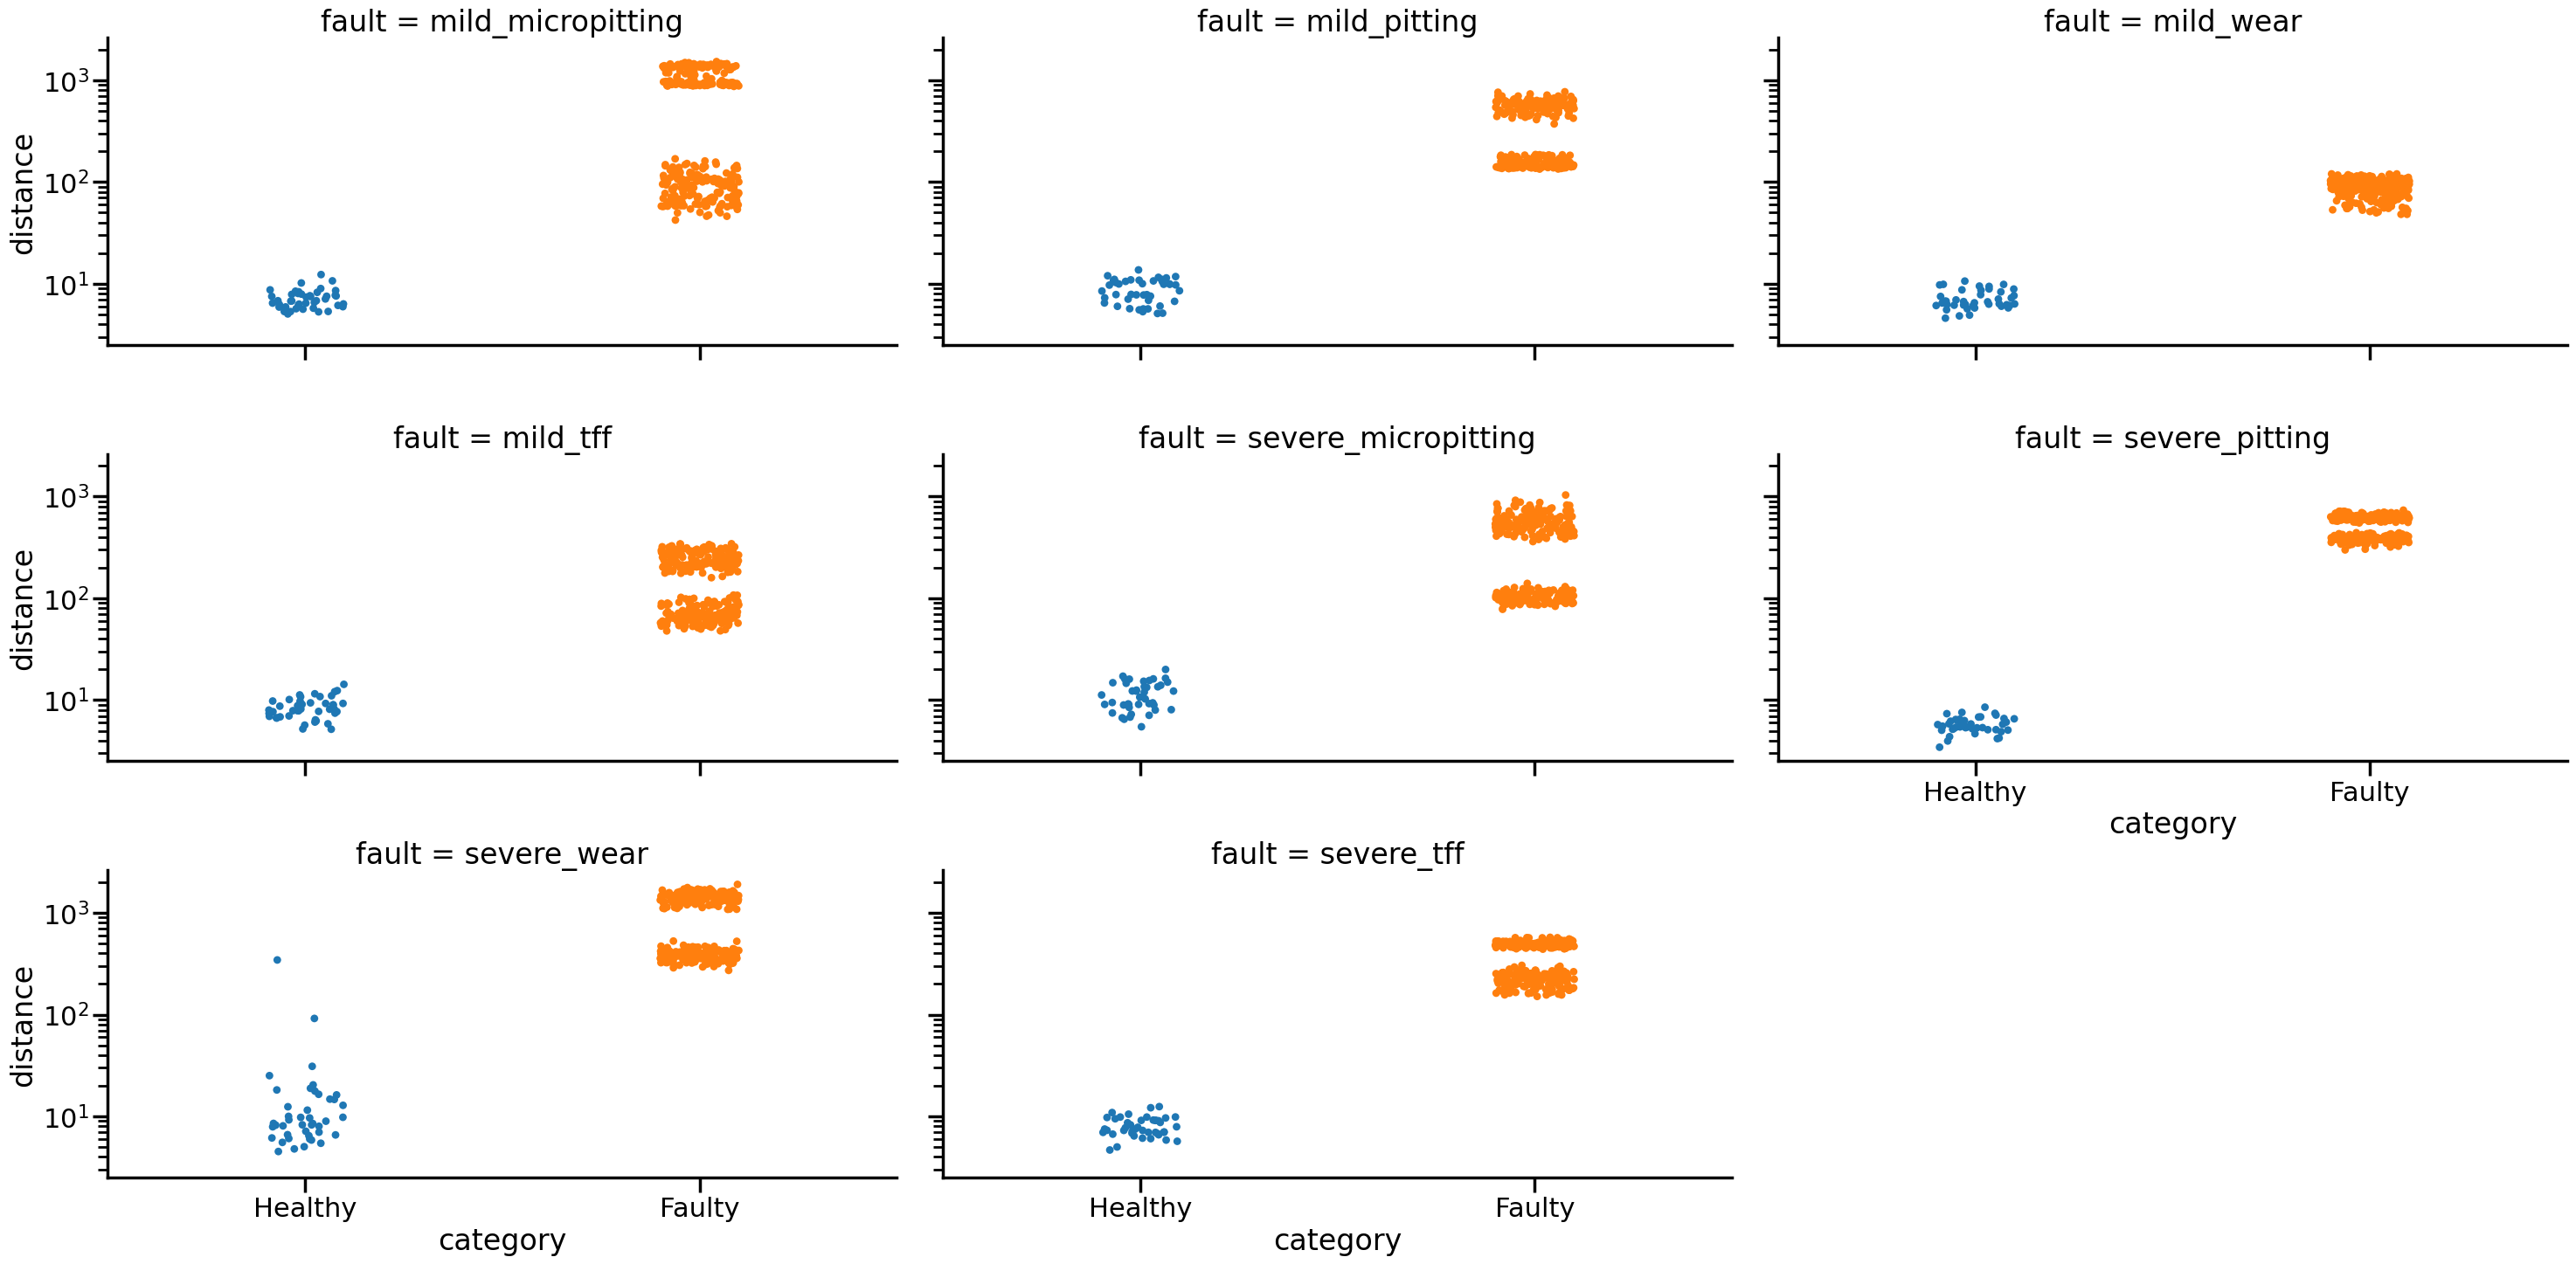

In [ ]:
# distance_metric = "L2"
distance_metric = "mahalanobis"

all_support_distances = {}
all_query_healthy_distances = {}
all_query_distances = {}

for fault in faults:
    for severity in severities:
        print(f"> {severity} {fault}")
        print("SUPPORT")

        ensemble_support_distances = []
        prototypes = []
        support_inv_cms = []

        # Ensemble loop
        for i in range(ensemble_size):
            prototype = ensemble_support_groups[i][f"{severity}_{fault}"].mean(axis=0)
            prototypes.append(prototype)

            # Calculate distance
            if distance_metric == "L2":
                support_distances = distance(
                    prototype, ensemble_support_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                support_inv_cm = np.linalg.pinv(
                    np.cov(
                        ensemble_support_groups[i][f"{severity}_{fault}"], rowvar=False
                    )
                )
                support_inv_cms.append(support_inv_cm)
                support_distances = distance_mahalanobis(
                    prototype,
                    ensemble_support_groups[i][f"{severity}_{fault}"],
                    support_inv_cm,
                )
            else:
                raise Exception("WAT")
            ensemble_support_distances.append(support_distances)

        # Ensemble average
        mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(
            axis=-1
        )
        all_support_distances[f"{severity}_{fault}"] = mean_support_distances

        print("Mean: {:>8.2f}".format(mean_support_distances.mean()))
        print("Max:  {:>8.2f}".format(mean_support_distances.max()))
        print("Min:  {:>8.2f}".format(mean_support_distances.min()))
        print()

        print("QUERY")

        ensemble_query_healthy_distances = []
        ensemble_query_distances = []

        for i in range(ensemble_size):
            if distance_metric == "L2":
                # Query healthy
                query_healthy_distances = distance(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                )
                # Faults
                query_distances = distance(
                    prototypes[i], ensemble_query_groups[i][f"{severity}_{fault}"]
                )
            elif distance_metric == "mahalanobis":
                # Query healthy
                query_healthy_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_healthy_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
                # Faults
                query_distances = distance_mahalanobis(
                    prototypes[i],
                    ensemble_query_groups[i][f"{severity}_{fault}"],
                    support_inv_cms[i],
                )
            ensemble_query_healthy_distances.append(query_healthy_distances)
            ensemble_query_distances.append(query_distances)

        # Ensemble averages
        mean_query_healthy_distances = np.stack(
            ensemble_query_healthy_distances, axis=-1
        ).mean(axis=-1)
        all_query_healthy_distances[f"{severity}_{fault}"] = (
            mean_query_healthy_distances
        )

        mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(axis=-1)
        all_query_distances[f"{severity}_{fault}"] = mean_query_distances

        print(
            "Mean: {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.mean(), mean_query_healthy_distances.mean()
            )
        )
        print(
            "Max:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.max(), mean_query_healthy_distances.max()
            )
        )
        print(
            "Min:  {:>8.2f} | {:>8.2f}".format(
                mean_query_distances.min(), mean_query_healthy_distances.min()
            )
        )
        print()

# Plotting

df = []
for severity in severities:
    for fault in faults:
        full_fault = f"{severity}_{fault}"

        # tmp_1 = pd.DataFrame(all_support_distances[full_fault], columns=["distance"])
        # tmp_1["category"] = "Support"
        # tmp_1["fault"] = full_fault
        tmp_2 = pd.DataFrame(
            all_query_healthy_distances[full_fault], columns=["distance"]
        )
        tmp_2["category"] = "Healthy"
        tmp_2["fault"] = full_fault
        tmp_3 = pd.DataFrame(all_query_distances[full_fault], columns=["distance"])
        tmp_3["category"] = "Faulty"
        tmp_3["fault"] = full_fault

        # df.append(tmp_1)
        df.append(tmp_2)
        df.append(tmp_3)

df = pd.concat(df)

with sns.plotting_context("poster"):
    sns.catplot(
        df,
        x="category",
        y="distance",
        hue="category",
        col="fault",
        col_wrap=3,
        log_scale=True,
        height=5,
        aspect=2,
        s=40,
        # kind="box",
        # palette=sns.color_palette("Paired"),
        legend=False,
    )

### Embeddings


In [ ]:
rpm = 1500
severity = "severe"
fault = "tff"
torque = 1
# installation = [1, 2]
repetition_offset = 0
i = 0

support_group = (
    query_data[repetition_offset + i][
        (query_data[repetition_offset + i]["rpm"] == rpm)
        & (
            query_data[repetition_offset + i]["severity"]
            == str(fault_GP_map[f"{severity}_{fault}"])
        )
        & (query_data[repetition_offset + i]["torque"] == torque)
    ]
    .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
    .to_numpy()
)

support_cluster = support_group[: support_group.shape[0] // 2]

# QUERY BASELINE #
query_healthy_cluster = support_group[support_group.shape[0] // 2 :]

# QUERY FAULTS #
query_cluster_1 = (
    query_data[repetition_offset + i][
        (query_data[repetition_offset + i]["rpm"] == rpm)
        & (query_data[repetition_offset + i]["severity"] == severity)
        & (query_data[repetition_offset + i]["torque"] == torque)
        & (query_data[repetition_offset + i]["installation"] == 1)
        & (query_data[repetition_offset + i]["fault"] == fault)
    ]
    .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
    .to_numpy()
)

# QUERY FAULTS #
query_cluster_2 = (
    query_data[repetition_offset + i][
        (query_data[repetition_offset + i]["rpm"] == rpm)
        & (query_data[repetition_offset + i]["severity"] == severity)
        & (query_data[repetition_offset + i]["torque"] == torque)
        & (query_data[repetition_offset + i]["installation"] == 2)
        & (query_data[repetition_offset + i]["fault"] == fault)
    ]
    .drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
    .to_numpy()
)

In [ ]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(
    np.concatenate(
        [support_cluster, query_healthy_cluster, query_cluster_1, query_cluster_2]
    )
)
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_cluster) * ["Support"],
        len(query_healthy_cluster) * ["Healthy"],
        len(query_cluster_1) * [f"{severity} {fault}, installation = 1"],
        len(query_cluster_2) * [f"{severity} {fault}, installation = 2"],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings, x="x", y="y", z="z", color="class", width=1200, height=1200
)
fig.update_layout(
    title=dict(text="TSNE", font=dict(size=50), automargin=True, yref="paper")
)
fig.show()

In [ ]:
pca = PCA(n_components=3)
pca.fit(
    np.concatenate(
        [support_cluster, query_healthy_cluster, query_cluster_1, query_cluster_2]
    )
)

pca_embeddings = pca.transform(
    np.concatenate(
        [support_cluster, query_healthy_cluster, query_cluster_1, query_cluster_2]
    )
)

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [
        len(support_cluster) * ["Support"],
        len(query_healthy_cluster) * ["Healthy"],
        len(query_cluster_1) * [f"{severity} {fault}, installation = 1"],
        len(query_cluster_2) * [f"{severity} {fault}, installation = 2"],
    ]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1600,
    height=1200,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
)
fig.update_layout(
    title=dict(text="PCA", font=dict(size=50), automargin=True, yref="paper")
)
fig.show()

In [ ]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(
    np.concatenate(
        # [support_cluster, query_healthy_cluster]
        # [support_cluster, query_healthy_cluster, query_cluster_1]
        # [support_cluster, query_healthy_cluster, query_cluster_1, query_cluster_2]
        [
            support_cluster,
            query_healthy_cluster,
            query_cluster_1[::2],
            query_cluster_2[::2],
        ]
    )
)
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_cluster) * ["Support"],
        len(query_healthy_cluster) * ["Healthy"],
        len(query_cluster_1[::2]) * [f"{severity} {fault}, installation = 1"],
        len(query_cluster_2[::2]) * [f"{severity} {fault}, installation = 2"],
    ]
)
tsne_embeddings["order"] = np.concatenate(
    [
        np.arange(len(support_cluster)),
        np.arange(
            len(support_cluster), len(support_cluster) + len(query_healthy_cluster)
        ),
        np.arange(len(query_cluster_1[::2])),
        np.arange(len(query_cluster_2[::2])),
    ]
)
# tsne_embeddings["order"] = np.arange(len(tsne_embeddings))

fig = px.scatter_3d(
    tsne_embeddings,
    x="x",
    y="y",
    z="z",
    color="order",
    symbol="class",
    width=1200,
    height=1200,
)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside"))
fig.update_layout(
    title=dict(text="TSNE", font=dict(size=50), automargin=True, yref="paper")
)
fig.show()

In [ ]:
pca = PCA(n_components=3)
pca.fit(
    np.concatenate(
        [support_cluster, query_healthy_cluster, query_cluster_1, query_cluster_2]
    )
)

pca_embeddings = pca.transform(
    np.concatenate(
        [support_cluster, query_healthy_cluster, query_cluster_1, query_cluster_2]
    )
)

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [
        len(support_cluster) * ["Support"],
        len(query_healthy_cluster) * ["Healthy"],
        len(query_cluster_1) * [f"{severity} {fault}, installation = 1"],
        len(query_cluster_2) * [f"{severity} {fault}, installation = 2"],
    ]
)
# pca_embeddings["order"] = np.arange(len(pca_embeddings))
pca_embeddings["order"] = np.concatenate(
    [
        np.arange(len(support_cluster)),
        np.arange(
            len(support_cluster), len(support_cluster) + len(query_healthy_cluster)
        ),
        np.arange(len(query_cluster_1)),
        np.arange(len(query_cluster_2)),
    ]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="order",
    symbol="class",
    width=1600,
    height=1200,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0, ticks="outside"))

fig.update_layout(
    title=dict(text="PCA", font=dict(size=50), automargin=True, yref="paper")
)
fig.show()

In [ ]:
# Is drift or fault separation greater?

healthy_cluster = np.concatenate([support_cluster, query_healthy_cluster])

healthy_prototype = np.mean(healthy_cluster, axis=0)

healthy_max = np.max(
    np.sqrt(np.sum((healthy_cluster - healthy_prototype) ** 2, axis=1))
)
tff_1_min = np.min(np.sqrt(np.sum((query_cluster_1 - healthy_prototype) ** 2, axis=1)))
tff_2_min = np.min(np.sqrt(np.sum((query_cluster_2 - healthy_prototype) ** 2, axis=1)))

print(f"{healthy_max} VS ({tff_1_min} OR {tff_2_min})")

2.895108461380005 VS (8.000455856323242 TAI 12.475703239440918)


# Trained w/ AGFD (New setup)


In [ ]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

query_data = []
# num_repetitions = 10
num_repetitions = 5
ensemble_size = 5

for i in range(num_repetitions * ensemble_size):
    query_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                # "AD_arotor_torque1_article",
                "archive",
                "anomality_detection_arotor_norm_new",
                f"query_{i}.feather",
            )
        )
    )

print("Number of models: ", len(query_data))
print("Queries:", query_data[0].shape)

# * Distances defined in `Trained w/ ASD` (above)

Number of models:  25
Queries: (5928, 18)


In [ ]:
rpms = [250, 500, 750, 1000, 1250, 1500]
faults = [1, 2, 3, 4, 5, 6, 7, 8, 9]

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

assert (
    len(query_data) == num_repetitions * ensemble_size
), f"len(query_data) != num_repetitions * ensemble_size, {len(query_data)} != {num_repetitions * ensemble_size}"

for i in range(len(query_data)):
    ensemble_support_groups.append({})
    ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    for rpm in rpms:
        # SUPPORT #

        support_group = (
            query_data[i][(query_data[i]["rpm"] == rpm) & (query_data[i]["class"] == 0)]
            .drop(["rpm", "class"], axis=1)
            .to_numpy()
        )

        # Check if NaNs
        if np.sum(~np.isfinite(support_group)) != 0:
            print("NaN detected in healthy @{rpm}!")
            print(support_group)
            raise

        # * 50/50 split on baseline measurements to support and query
        ensemble_support_groups[i][rpm] = support_group[: support_group.shape[0] // 2]

        # QUERY BASELINE #

        ensemble_query_healthy_groups[i][rpm] = support_group[
            support_group.shape[0] // 2 :
        ]

        # QUERY FAULTS #
        for fault in faults:
            query_group = (
                query_data[i][
                    (query_data[i]["rpm"] == rpm) & (query_data[i]["class"] == fault)
                ]
                .drop(["rpm", "class"], axis=1)
                .to_numpy()
            )

            # Check if NaNs
            if np.sum(~np.isfinite(query_group)) != 0:
                print("NaN detected in fault {fault} @{rpm}!")
                print(query_group)
                raise

            ensemble_query_groups[i][f"{fault}_{rpm}"] = query_group

780 / 780 = 100.0%
780 / 780 = 100.0%
528 / 28080 = 1.8803418803418803%


[Text(0.5, 23.52222222222222, 'Predicted label'),
 Text(50.722222222222214, 0.5, 'True label')]

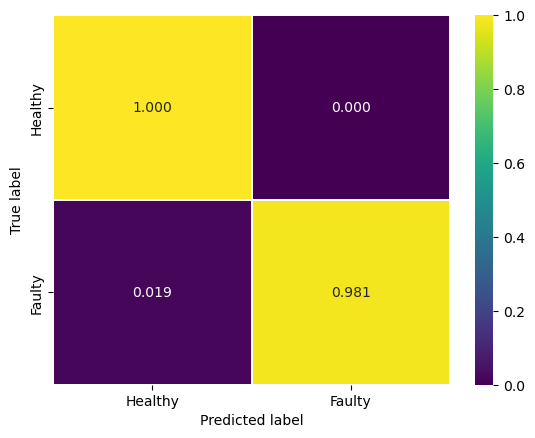

In [ ]:
def distance_calculation(
    ensemble_support_groups,
    ensemble_query_healthy_groups,
    ensemble_query_groups,
    distance_metric,
    repetition_offset,
):
    all_support_distances = {}
    all_query_healthy_distances = {}
    all_query_distances = {}

    for rpm in rpms:
        # SUPPORT & QUERY HEALTHY #

        ensemble_support_distances = []
        ensemble_query_healthy_distances = []
        prototypes = []
        support_inv_cms = []

        # Ensemble loop
        # * Separate ensemble loop for faults!
        for i in range(ensemble_size):
            prototype = ensemble_support_groups[repetition_offset + i][rpm].mean(axis=0)
            prototypes.append(prototype)

            # Calculate distance
            if distance_metric == "L2":
                # Support
                support_distances = distance(
                    prototype,
                    ensemble_support_groups[repetition_offset + i][rpm],
                )
                # Query healthy
                query_healthy_distances = distance(
                    prototype,
                    ensemble_query_healthy_groups[repetition_offset + i][rpm],
                )
            elif distance_metric == "mahalanobis":
                # (Inverted) Covariance matrix
                try:
                    support_inv_cm = np.linalg.pinv(
                        np.cov(
                            ensemble_support_groups[repetition_offset + i][rpm],
                            rowvar=False,
                        )
                    )
                    support_inv_cms.append(support_inv_cm)
                except Exception as e:
                    print(ensemble_support_groups[repetition_offset + i][rpm])
                    raise e

                # Support
                support_distances = distance_mahalanobis(
                    prototype,
                    ensemble_support_groups[repetition_offset + i][rpm],
                    support_inv_cm,
                )

                # Query healthy
                query_healthy_distances = distance_mahalanobis(
                    prototype,
                    ensemble_query_healthy_groups[repetition_offset + i][rpm],
                    support_inv_cm,
                )
            else:
                raise Exception("WAT")

            ensemble_support_distances.append(support_distances)
            ensemble_query_healthy_distances.append(query_healthy_distances)

        # Ensemble averages
        # Support
        mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(
            axis=-1
        )
        all_support_distances[rpm] = mean_support_distances

        # Query healthy
        mean_query_healthy_distances = np.stack(
            ensemble_query_healthy_distances, axis=-1
        ).mean(axis=-1)
        all_query_healthy_distances[rpm] = mean_query_healthy_distances

        # QUERY (FAULTS) #

        for fault in faults:
            # print(f"> {severity} {fault} {rpm} {torque}")
            ensemble_query_distances = []

            for i in range(ensemble_size):
                if distance_metric == "L2":
                    # Faults
                    query_distances = distance(
                        prototypes[i],
                        ensemble_query_groups[repetition_offset + i][f"{fault}_{rpm}"],
                    )
                elif distance_metric == "mahalanobis":
                    # Faults
                    query_distances = distance_mahalanobis(
                        prototypes[i],
                        ensemble_query_groups[repetition_offset + i][f"{fault}_{rpm}"],
                        support_inv_cms[i],
                    )
                ensemble_query_healthy_distances.append(query_healthy_distances)
                ensemble_query_distances.append(query_distances)

            # Ensemble averages
            # Faults
            mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(
                axis=-1
            )
            all_query_distances[f"{fault}_{rpm}"] = mean_query_distances

    return all_support_distances, all_query_healthy_distances, all_query_distances


repetition_distances = []  # list<(support, query, query_healthy)>

for repetition_offset in range(
    0, num_repetitions * ensemble_size, ensemble_size
):  # range(0, 25, 5)
    repetition_distances.append(
        distance_calculation(
            ensemble_support_groups,
            ensemble_query_healthy_groups,
            ensemble_query_groups,
            # "mahalanobis",
            "L2",
            repetition_offset,
        )
    )

# Thresholding

support_under = 0
query_healthy_under = 0
query_under = 0

support_total = 0
query_healthy_total = 0
query_total = 0

for (
    repetition_support_distances,
    repetition_query_healthy_distances,
    repetition_query_distances,
) in repetition_distances:
    for rpm in rpms:
        # Threshold
        limit = 10 * np.max(repetition_support_distances[rpm])
        # std = np.std(repetition_support_distances[rpm])
        # limit = 20 * std

        # Support
        support_under += np.sum(repetition_support_distances[rpm] < limit)
        support_total += len(repetition_support_distances[rpm])

        # Query healthy
        query_healthy_under += np.sum(repetition_query_healthy_distances[rpm] < limit)
        query_healthy_total += len(repetition_query_healthy_distances[rpm])
        for fault in faults:
            full_class = f"{fault}_{rpm}"

            # Faults
            query_under += np.sum(repetition_query_distances[full_class] < limit)
            query_total += len(repetition_query_distances[full_class])

print(f"{support_under} / {support_total} = {support_under / support_total * 100}%")
print(
    f"{query_healthy_under} / {query_healthy_total} = {query_healthy_under / query_healthy_total * 100}%"
)
print(f"{query_under} / {query_total} = {query_under / query_total * 100}%")

# Plotting

cf_agg = np.array(
    [
        [
            query_healthy_under / query_healthy_total,
            (query_healthy_total - query_healthy_under) / query_healthy_total,
        ],
        [query_under / query_total, (query_total - query_under) / query_total],
    ]
)
categories = ["Healthy", "Faulty"]

ax = sns.heatmap(
    cf_agg,
    annot=True,
    fmt=".3f",
    linewidth=0.3,
    xticklabels=categories,
    yticklabels=categories,
    cmap="viridis",
)
ax.set(xlabel="Predicted label", ylabel="True label")

### ROC & AUC


In [ ]:
repetition_query_distances

{'1_250': array([10.124227 , 14.148436 ,  7.9075775, 14.700902 , 11.989706 ,
        13.837004 ,  8.683313 , 11.981343 , 11.84458  , 12.198234 ,
         8.194091 , 16.52518  ,  9.6974945, 13.437454 ,  8.796133 ,
        12.986325 , 10.832172 , 15.86471  , 11.691942 , 15.57073  ,
        11.918264 , 12.184978 ,  8.800722 , 13.12254  ,  9.196615 ,
         8.866661 , 10.429068 , 13.3550415,  8.468415 ,  8.170332 ,
         8.32442  , 10.573097 ,  7.7860365,  8.217539 ,  8.060624 ,
        12.115875 ,  5.9952726,  6.958925 ,  8.540452 ,  7.8683534,
         5.463315 ,  6.687978 ,  5.7943735,  7.941433 ,  5.5978966,
         7.707717 ,  5.985564 ,  8.796202 ,  6.382764 ,  7.74756  ,
         7.6576066,  8.657724 ,  5.4913816,  7.691682 ,  6.1911726,
         7.6788583,  8.189052 ,  9.060266 ,  6.3412714,  9.137308 ,
         6.1596847,  6.4777184,  6.0352383,  6.1466036,  6.229829 ,
         5.55586  ,  6.267653 ,  6.313449 ,  4.506404 ,  9.441167 ,
         4.5624366,  7.3630066,  5.9991

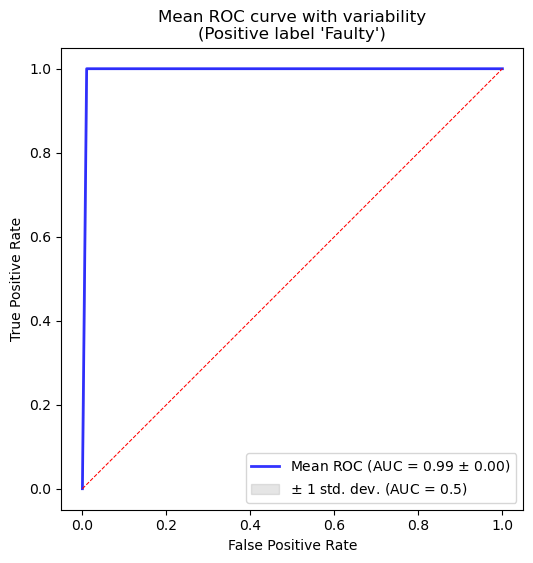

In [ ]:
healthy = dict(
    [
        (k, np.array([x, np.zeros_like(x)]))
        for k, x in repetition_query_healthy_distances.items()
    ]
)
query = dict(
    [(k, np.array([x, np.ones_like(x)])) for k, x in repetition_query_distances.items()]
)

# case_names = list(repetition_query_healthy_distances.keys())

cases = []
for k in repetition_query_distances.keys():
    rpm = int(k.split("_")[1])
    # print(k)
    cases.append(
        {
            "labels": np.concatenate([healthy[rpm][1], query[k][1]]),
            "scores": np.concatenate([healthy[rpm][0], query[k][0]]),
        }
    )

fig, ax = plt.subplots(figsize=(6, 6))
# fig, ax = plt.subplots(2, 1, figsize=(6, 6))

fprs = []
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, case in enumerate(cases[:]):
    # print(case["labels"].shape)
    # print(case["scores"].shape)

    # viz = RocCurveDisplay.from_predictions(
    #     case["labels"],
    #     case["scores"],
    #     name=f"_{case_names[i]}",
    #     alpha=0.3,
    #     lw=1,
    #     # ax=ax,
    #     # plot_chance_level=False,
    #     plot_chance_level=(i == len(cases) - 1),
    # )

    fpr, tpr, _ = roc_curve(case["labels"], case["scores"], drop_intermediate=True)
    roc_auc = roc_auc_score(case["labels"], case["scores"])
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    # interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    # aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev. (AUC = 0.5)",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'Faulty')",
)
ax.axis("square")
ax.legend(
    loc="lower right",
)
sns.lineplot(x=[0, 1], y=[0, 1], color="red", linestyle="dashed", linewidth=0.75, ax=ax)
plt.show()

## More detailed look


In [ ]:
rpm = 1500
severities = ["mild", "severe"]
faults = [1, 2, 3, 4, 5, 6, 7, 8, 9]

repetition_offset = 5  # * Change this to change between repetitions

ensemble_support_groups = []
ensemble_query_healthy_groups = []
ensemble_query_groups = []

for i in range(ensemble_size):
    # ensemble_support_groups.append({})
    # ensemble_query_healthy_groups.append({})
    ensemble_query_groups.append({})

    # SUPPORT #
    support_group = (
        query_data[repetition_offset + i][
            (
                (query_data[repetition_offset + i]["rpm"] == rpm)
                & (query_data[repetition_offset + i]["class"] == 0)
            )
        ]
        .drop(["rpm", "class"], axis=1)
        .to_numpy()
    )

    ensemble_support_groups.append(support_group[: support_group.shape[0] // 2])
    # ensemble_support_groups[i][rpm] = support_group[: support_group.shape[0] // 2]

    # QUERY BASELINE #
    ensemble_query_healthy_groups.append(support_group[support_group.shape[0] // 2 :])
    # ensemble_query_healthy_groups[i][rpm] = support_group[support_group.shape[0] // 2 :]

    for fault in faults:
        # QUERY FAULTS #
        query_group = (
            query_data[repetition_offset + i][
                (query_data[repetition_offset + i]["rpm"] == rpm)
                & (query_data[repetition_offset + i]["class"] == fault)
            ]
            .drop(["rpm", "class"], axis=1)
            .to_numpy()
        )

        ensemble_query_groups[i][f"{fault}"] = query_group

> 1
SUPPORT
Mean:     3.90
Max:      4.31
Min:      3.44

QUERY
Mean:   801.35 |    11.45
Max:    942.88 |    19.22
Min:    591.71 |     6.84

> 2
SUPPORT
Mean:     3.90
Max:      4.31
Min:      3.44

QUERY
Mean:  1566.23 |    11.45
Max:   1914.29 |    19.22
Min:   1357.80 |     6.84

> 3
SUPPORT
Mean:     3.90
Max:      4.31
Min:      3.44

QUERY
Mean:  4116.12 |    11.45
Max:   4790.38 |    19.22
Min:   3668.14 |     6.84

> 4
SUPPORT
Mean:     3.90
Max:      4.31
Min:      3.44

QUERY
Mean:  1130.04 |    11.45
Max:   1549.16 |    19.22
Min:    850.63 |     6.84

> 5
SUPPORT
Mean:     3.90
Max:      4.31
Min:      3.44

QUERY
Mean:  3039.24 |    11.45
Max:   3258.75 |    19.22
Min:   2679.42 |     6.84

> 6
SUPPORT
Mean:     3.90
Max:      4.31
Min:      3.44

QUERY
Mean:  3329.97 |    11.45
Max:   3574.88 |    19.22
Min:   2962.47 |     6.84

> 7
SUPPORT
Mean:     3.90
Max:      4.31
Min:      3.44

QUERY
Mean:  1263.05 |    11.45
Max:   1482.19 |    19.22
Min:   1034.03 |     6.84


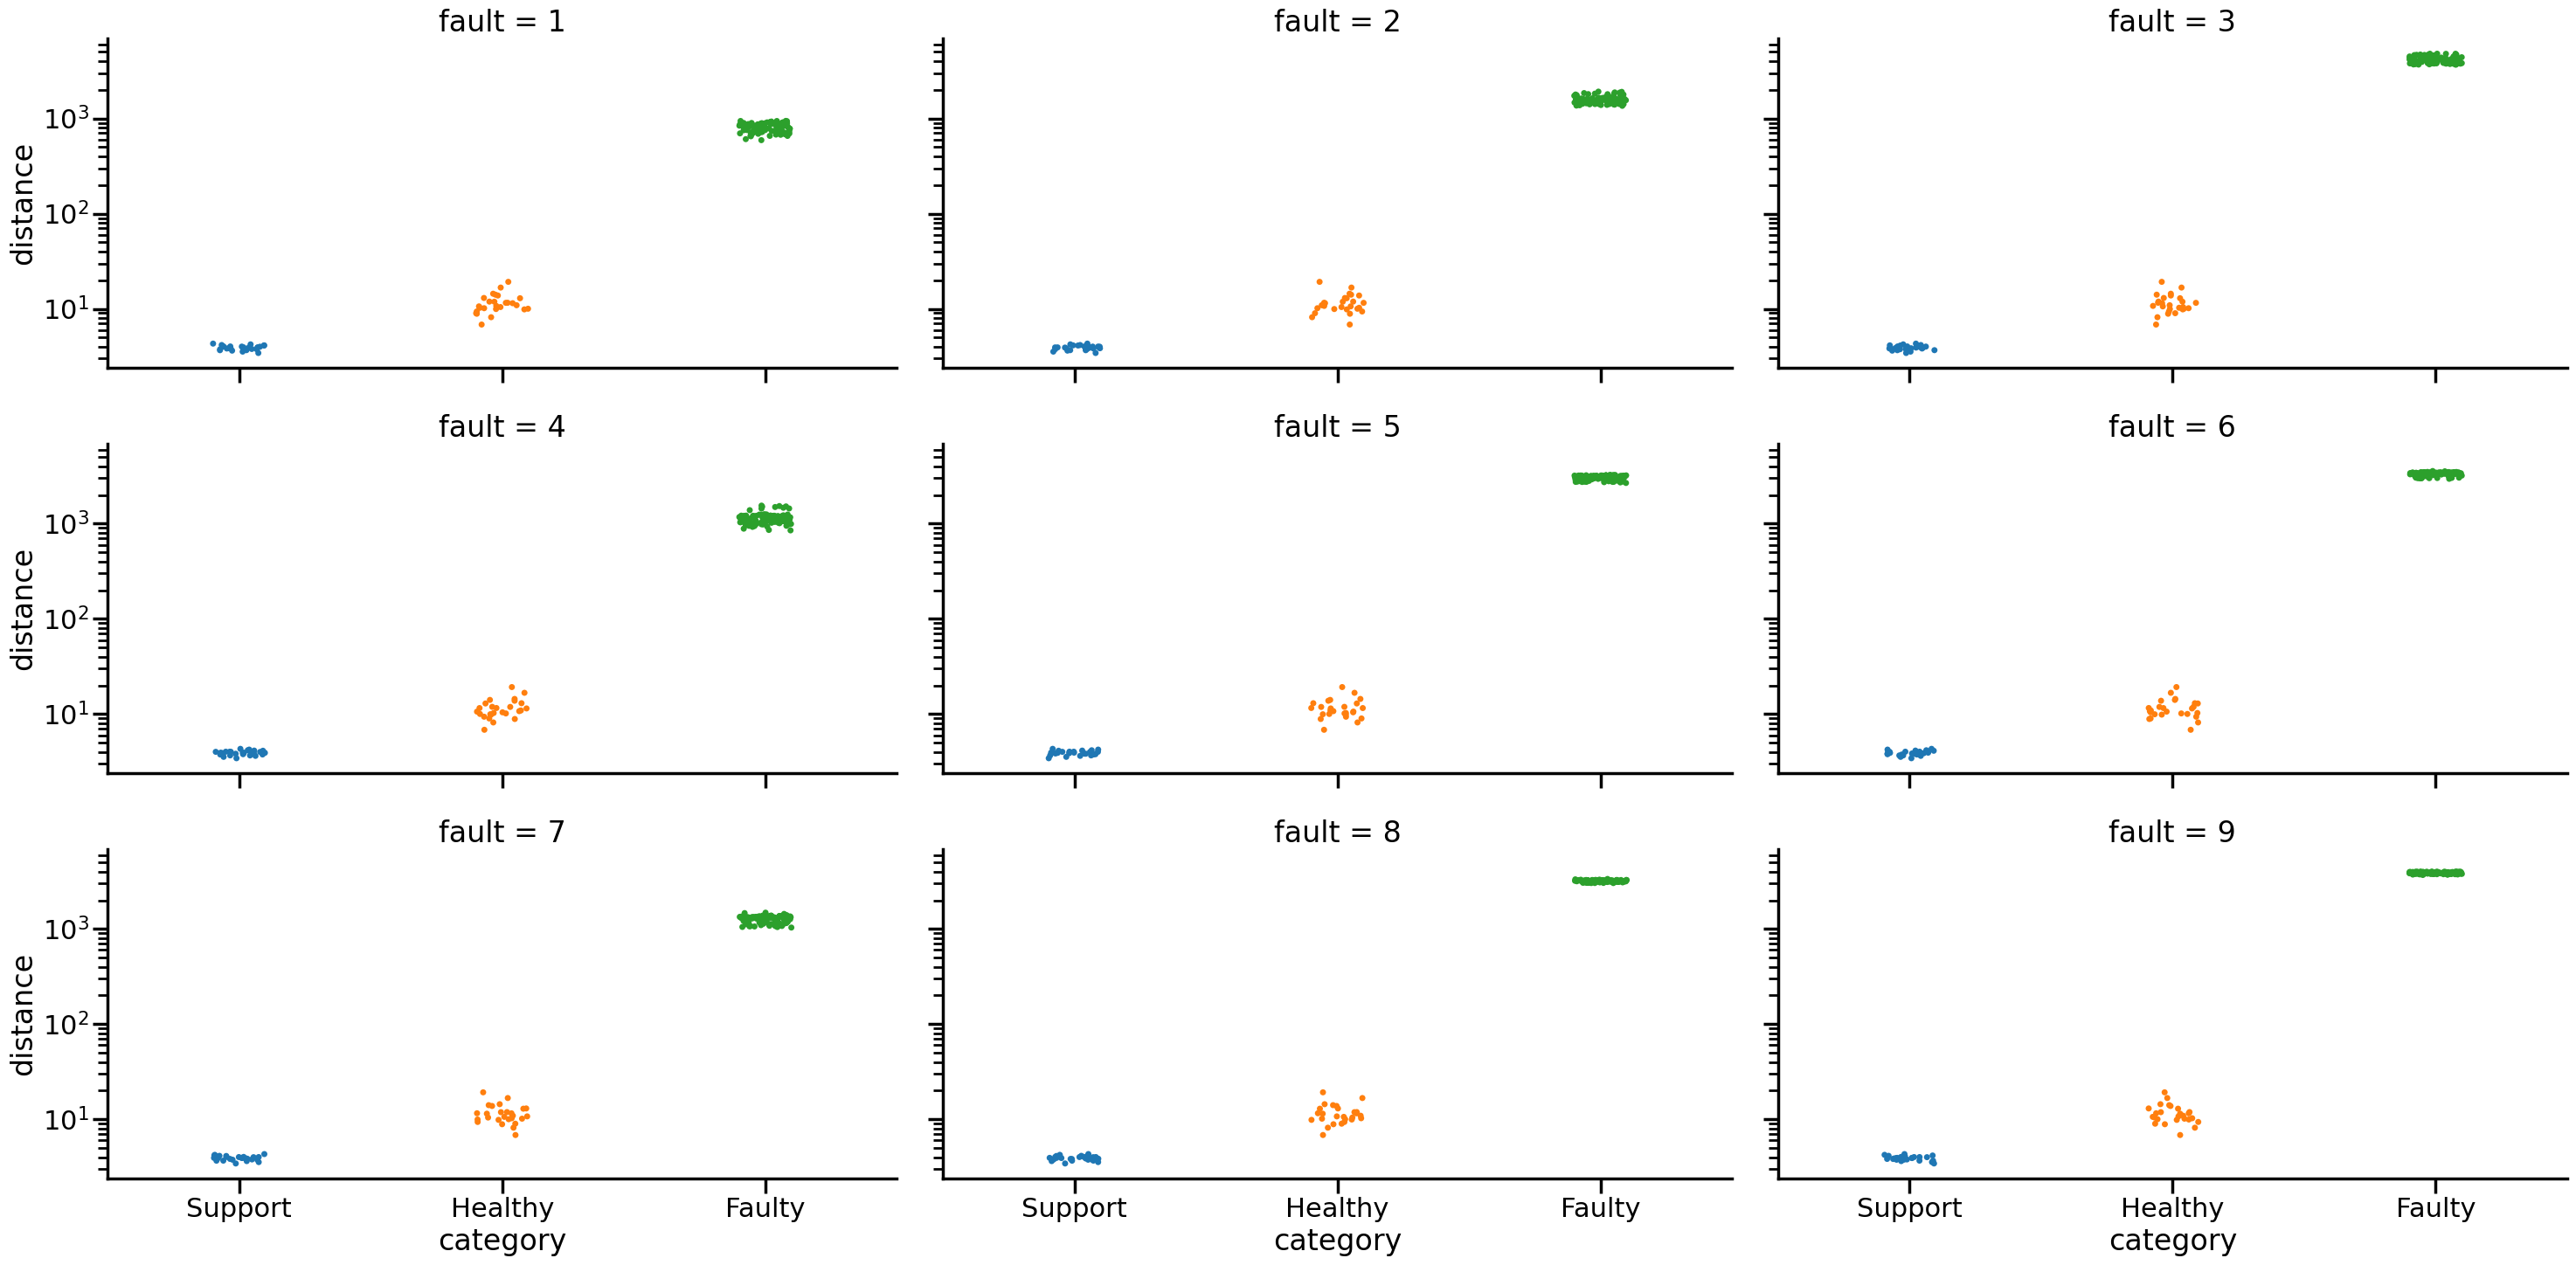

In [ ]:
# distance_metric = "L2"
distance_metric = "mahalanobis"

all_support_distances = {}
all_query_healthy_distances = {}
all_query_distances = {}

for fault in faults:
    print(f"> {fault}")
    print("SUPPORT")

    ensemble_support_distances = []
    prototypes = []
    support_inv_cms = []

    # Ensemble loop
    for i in range(ensemble_size):
        prototype = ensemble_support_groups[i].mean(axis=0)
        prototypes.append(prototype)

        # Calculate distance
        if distance_metric == "L2":
            support_distances = distance(prototype, ensemble_support_groups[i])
        elif distance_metric == "mahalanobis":
            support_inv_cm = np.linalg.pinv(
                np.cov(ensemble_support_groups[i], rowvar=False)
            )
            support_inv_cms.append(support_inv_cm)
            support_distances = distance_mahalanobis(
                prototype,
                ensemble_support_groups[i],
                support_inv_cm,
            )
        else:
            raise Exception("WAT")
        ensemble_support_distances.append(support_distances)

    # Ensemble average
    # Support
    mean_support_distances = np.stack(ensemble_support_distances, axis=-1).mean(axis=-1)
    all_support_distances[f"{fault}"] = mean_support_distances

    print("Mean: {:>8.2f}".format(mean_support_distances.mean()))
    print("Max:  {:>8.2f}".format(mean_support_distances.max()))
    print("Min:  {:>8.2f}".format(mean_support_distances.min()))
    print()

    print("QUERY")

    ensemble_query_healthy_distances = []
    ensemble_query_distances = []

    for i in range(ensemble_size):
        if distance_metric == "L2":
            # Query healthy
            query_healthy_distances = distance(
                prototypes[i],
                ensemble_query_healthy_groups[i],
            )
            # Faults
            query_distances = distance(
                prototypes[i], ensemble_query_groups[i][f"{fault}"]
            )
        elif distance_metric == "mahalanobis":
            # Query healthy
            query_healthy_distances = distance_mahalanobis(
                prototypes[i],
                ensemble_query_healthy_groups[i],
                support_inv_cms[i],
            )
            # Faults
            query_distances = distance_mahalanobis(
                prototypes[i],
                ensemble_query_groups[i][f"{fault}"],
                support_inv_cms[i],
            )
        ensemble_query_healthy_distances.append(query_healthy_distances)
        ensemble_query_distances.append(query_distances)

    # Ensemble averages
    # Query healthy
    mean_query_healthy_distances = np.stack(
        ensemble_query_healthy_distances, axis=-1
    ).mean(axis=-1)
    all_query_healthy_distances[f"{fault}"] = mean_query_healthy_distances

    # Faults
    mean_query_distances = np.stack(ensemble_query_distances, axis=-1).mean(axis=-1)
    all_query_distances[f"{fault}"] = mean_query_distances

    print(
        "Mean: {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.mean(), mean_query_healthy_distances.mean()
        )
    )
    print(
        "Max:  {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.max(), mean_query_healthy_distances.max()
        )
    )
    print(
        "Min:  {:>8.2f} | {:>8.2f}".format(
            mean_query_distances.min(), mean_query_healthy_distances.min()
        )
    )
    print()

# Plotting

df = []
for fault in faults:
    full_fault = f"{fault}"

    tmp_1 = pd.DataFrame(all_support_distances[full_fault], columns=["distance"])
    tmp_1["category"] = "Support"
    tmp_1["fault"] = full_fault
    tmp_2 = pd.DataFrame(all_query_healthy_distances[full_fault], columns=["distance"])
    tmp_2["category"] = "Healthy"
    tmp_2["fault"] = full_fault
    tmp_3 = pd.DataFrame(all_query_distances[full_fault], columns=["distance"])
    tmp_3["category"] = "Faulty"
    tmp_3["fault"] = full_fault

    df.append(tmp_1)
    df.append(tmp_2)
    df.append(tmp_3)

df = pd.concat(df)

with sns.plotting_context("poster"):
    sns.catplot(
        df,
        x="category",
        y="distance",
        hue="category",
        col="fault",
        col_wrap=3,
        log_scale=True,
        height=5,
        aspect=2,
        # palette=sns.color_palette("Paired"),
        legend=False,
    )

---


# Trained w/ ASD


In [ ]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

support_data = []
query_data = []
ensemble_size = 5

for i in range(ensemble_size):
    support_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                # "anomality_detection_arotor_replication",
                # "anomality_detection_arotor_replication_acc3",
                "anomality_detection_arotor_replication_acc3_32",
                # "anomality_detection_arotor_replication_acc3_32_norm",
                f"support_{i}.feather",
            )
        )
    )

    query_data.append(
        pd.read_feather(
            os.path.join(
                data_folder,
                # "anomality_detection_arotor_replication",
                # "anomality_detection_arotor_replication_acc3",
                "anomality_detection_arotor_replication_acc3_32",
                # "anomality_detection_arotor_replication_acc3_32_norm",
                f"query_{i}.feather",
            )
        )
    )

print("ensemble size", len(support_data))
print("support", support_data[0].shape)
print("query", query_data[0].shape)

ensemble size 5
support (3410, 35)
query (30607, 37)


In [ ]:
rpm = 1500
torque = 6
support_GP = [1, 2, 3, 4]
query_GP = ["5", "6", "7", "8", "9"]
# query_GP = ["8"]
severity = "severe"
# installation = [1]
installation = [1, 2]
faults = ["micropitting", "pitting", "wear", "tff"]

ensemble_support_groups = []
ensemble_query_groups = []

for i in range(ensemble_size):
    # SUPPORT #
    support_group = support_data[i][
        (support_data[i]["rpm"] == rpm)
        & (support_data[i]["GP"].isin(support_GP))
        & (support_data[i]["torque"] == torque)
    ].drop(["rpm", "GP", "torque"], axis=1)
    ensemble_support_groups.append(support_group.to_numpy())
    # support_group = support_group.to_numpy()

    # QUERY #
    query_groups = []

    # Baseline
    query_group = query_data[i][
        (query_data[i]["rpm"] == rpm)
        & (query_data[i]["severity"].isin(query_GP))
        & (query_data[i]["torque"] == torque)
        & (query_data[i]["installation"] == 0)  # All baseline in installation 0
        & (query_data[i]["fault"] == "baseline")
    ].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
    query_group = query_group.to_numpy()
    query_groups.append(query_group)

    # Faults
    for fault in faults:
        query_group = query_data[i][
            (query_data[i]["rpm"] == rpm)
            & (query_data[i]["severity"] == severity)
            & (query_data[i]["torque"] == torque)
            & (query_data[i]["installation"].isin(installation))
            & (query_data[i]["fault"] == fault)
        ].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
        query_group = query_group.to_numpy()

        query_groups.append(query_group)

    ensemble_query_groups.append(query_groups)

### Distances


SUPPORT
Mean: 3445780.2
Max: 10203715.0
Min: 238836.25

QUERY
Healthy
Mean: 12949450.0
Max: 39527516.0
Min: 434501.3
Micropitting
Mean: 31539038.0
Max: 71305740.0
Min: 3943340.5
Pitting
Mean: 25442470.0
Max: 49381348.0
Min: 6977620.0
Wear
Mean: 4832364.5
Max: 11125134.0
Min: 406983.22
TFF
Mean: 561991900.0
Max: 999101950.0
Min: 229573680.0


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_7466/2715694310.py:71: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  sns.catplot(


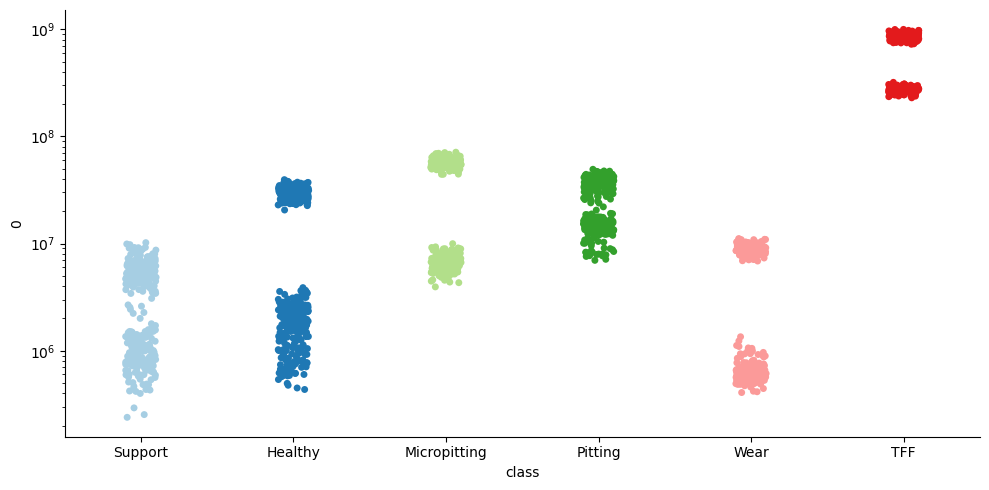

In [ ]:
print("SUPPORT")
ensemble_support_distances = []
prototypes = []
support_inv_cms = []
for i in range(ensemble_size):
    prototype = ensemble_support_groups[i].mean(axis=0)
    prototypes.append(prototype)

    # Mahalanobis
    # support_inv_cm = np.linalg.inv(np.cov(ensemble_support_groups[i], rowvar=False))
    # support_inv_cms.append(support_inv_cm)
    # support_distances = distance_mahalanobis(
    #     prototype, ensemble_support_groups[i], support_inv_cm
    # )
    # L2
    support_distances = distance(prototype, ensemble_support_groups[i])
    ensemble_support_distances.append(support_distances)

# Ensemble average
support_distances = np.stack(ensemble_support_distances, axis=-1).mean(axis=-1)

print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

print("QUERY")
fault_map = ["Healthy", "Micropitting", "Pitting", "Wear", "TFF"]
query_distances = {}
for i in range(len(fault_map)):
    print(fault_map[i])
    ensemble_distances = []
    for j in range(ensemble_size):
        # Mahalanobis
        # ensemble_distances.append(
        #     distance_mahalanobis(
        #         prototypes[j], ensemble_query_groups[j][i], support_inv_cms[j]
        #     )
        # )
        # L2
        ensemble_distances.append(distance(prototypes[j], ensemble_query_groups[j][i]))

    # Ensemble average
    query_distances[fault_map[i]] = np.stack(ensemble_distances, axis=-1).mean(axis=-1)

    print("Mean:", query_distances[fault_map[i]].mean())
    print("Max:", query_distances[fault_map[i]].max())
    print("Min:", query_distances[fault_map[i]].min())

    # Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in fault_map:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    palette=sns.color_palette("Paired"),
    legend=False,
)

In [ ]:
def distance_mahalanobis(prototype, queries, inv_cm):
    return np.array([mahalanobis(x, prototype, inv_cm) for x in queries])


def distance(prototype, queries):
    return np.sum((queries - prototype) ** 2, axis=1)


print("SUPPORT")
ensemble_support_distances = []
prototypes = []
support_inv_cms = []
for i in range(ensemble_size):
    prototype = ensemble_support_groups[i].mean(axis=0)
    prototypes.append(prototype)

    # Mahalanobis
    support_inv_cm = np.linalg.inv(np.cov(ensemble_support_groups[i], rowvar=False))
    support_inv_cms.append(support_inv_cm)
    support_distances = distance_mahalanobis(
        prototype, ensemble_support_groups[i], support_inv_cm
    )
    # L2
    # support_distances = distance(prototype, ensemble_support_groups[i])
    ensemble_support_distances.append(support_distances)

# Ensemble average
support_distances = np.stack(ensemble_support_distances, axis=-1).mean(axis=-1)

print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

print("QUERY")
fault_map = ["Healthy", "Micropitting", "Pitting", "Wear", "TFF"]
query_distances = {}
for i in range(len(fault_map)):
    print(fault_map[i])
    ensemble_distances = []
    for j in range(ensemble_size):
        # Mahalanobis
        ensemble_distances.append(
            distance_mahalanobis(
                prototypes[j], ensemble_query_groups[j][i], support_inv_cms[j]
            )
        )
        # L2
        # ensemble_distances.append(distance(prototypes[j], ensemble_query_groups[j][i]))

    # Ensemble average
    query_distances[fault_map[i]] = np.stack(ensemble_distances, axis=-1).mean(axis=-1)

    print("Mean:", query_distances[fault_map[i]].mean())
    print("Max:", query_distances[fault_map[i]].max())
    print("Min:", query_distances[fault_map[i]].min())

    # Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in fault_map:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    palette=sns.color_palette("Paired"),
    legend=False,
)

SUPPORT


LinAlgError: Singular matrix

SUPPORT
Mean: 3.3392503
Max: 9.149887
Min: 0.70306313

Healthy
Mean: 4.3589177
Max: 9.730363
Min: 0.6773419
Micropitting
Mean: 7.221403
Max: 12.1260195
Min: 3.8277128
Pitting
Mean: 5.4383373
Max: 8.571107
Min: 2.835105
Wear
Mean: 8.636745
Max: 15.101037
Min: 2.8056972
TFF
Mean: 27.841484
Max: 71.712944
Min: 11.674653


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_91810/1059662015.py:32: UserWarning:

The palette list has more values (12) than needed (6), which may not be intended.



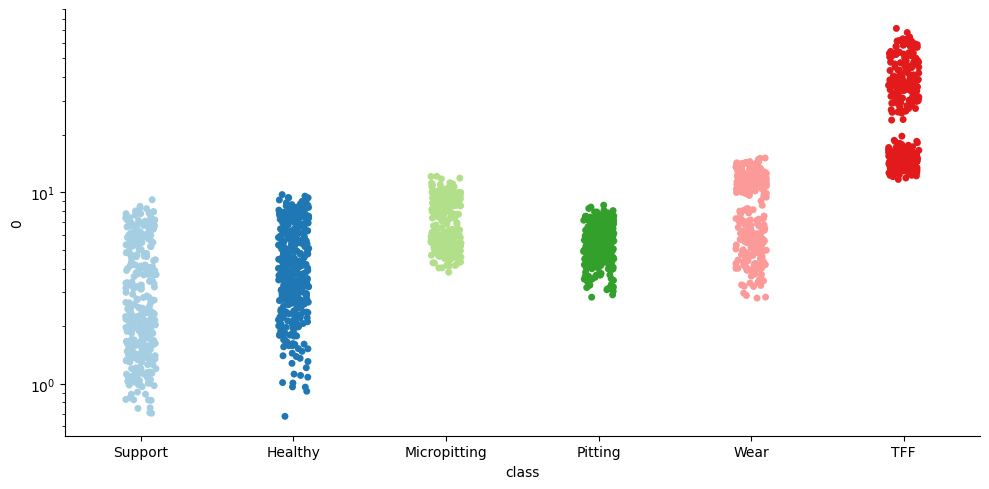

In [ ]:
#! NON-ENSEMBLE IMPLEMENTATION #

prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
fault_map = ["Healthy", "Micropitting", "Pitting", "Wear", "TFF"]
for i in range(5):
    print(fault_map[i])
    query_distances[fault_map[i]] = np.sum((query_groups[i] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault_map[i]].mean())
    print("Max:", query_distances[fault_map[i]].max())
    print("Min:", query_distances[fault_map[i]].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in fault_map:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    palette=sns.color_palette("Paired"),
    legend=False,
)

### 2D TSNE


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_91810/3182773687.py:19: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='x', ylabel='y'>

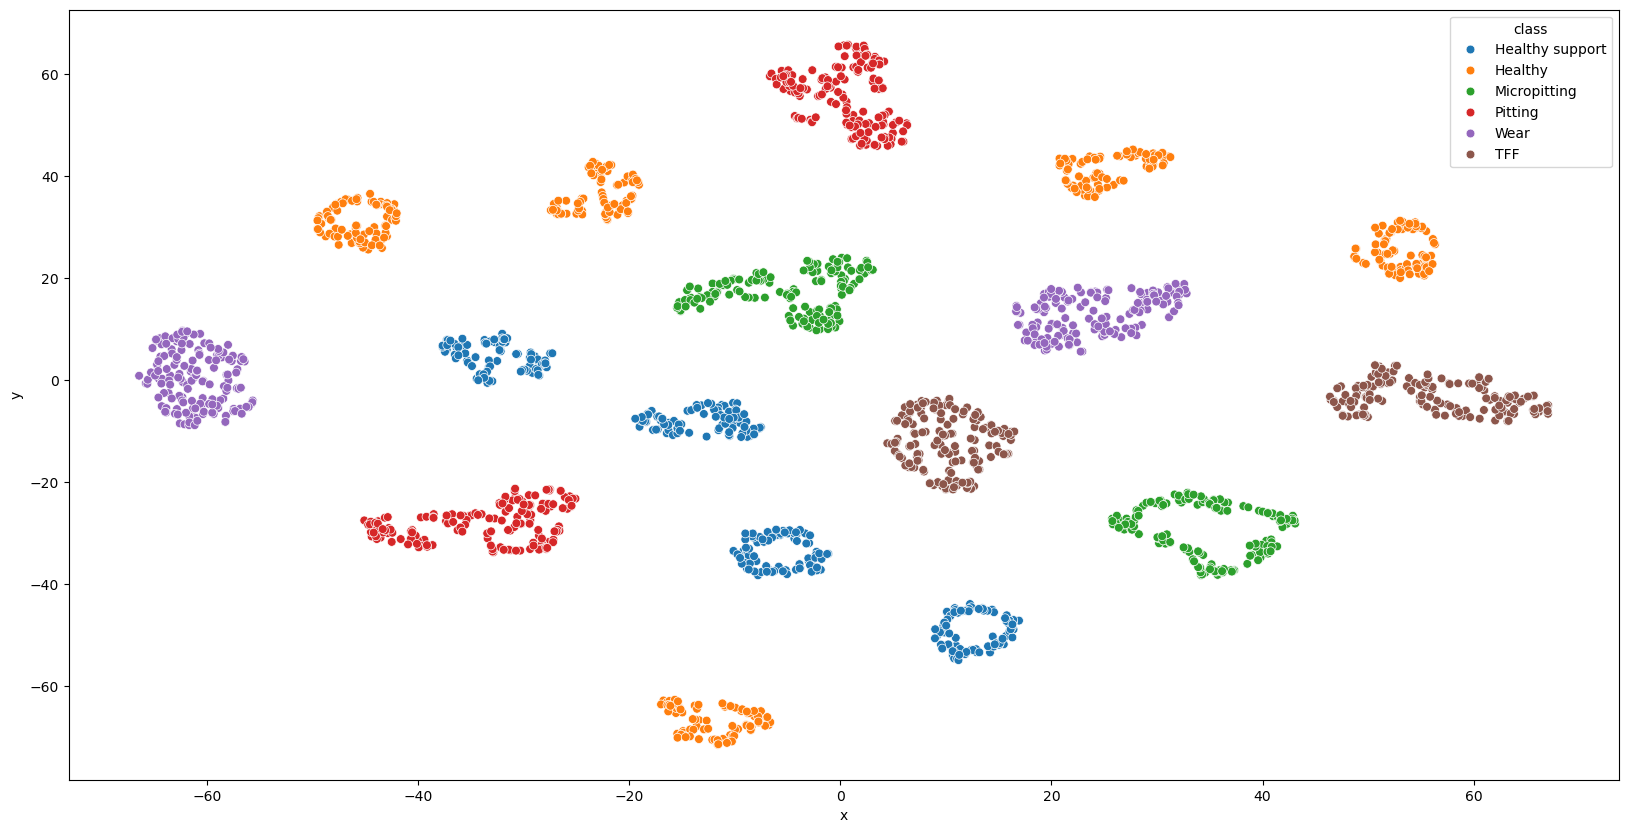

In [ ]:
tsne_embeddings = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *query_groups]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["Healthy support"],
        len(query_groups[0]) * ["Healthy"],
        len(query_groups[1]) * ["Micropitting"],
        len(query_groups[2]) * ["Pitting"],
        len(query_groups[3]) * ["Wear"],
        len(query_groups[4]) * ["TFF"],
    ]
)

plt.figure(figsize=(20, 10))
palette = sns.color_palette()

sns.scatterplot(
    tsne_embeddings,
    x="x",
    y="y",
    s=40,
    hue="class",
    palette=palette,
    alpha=1.0,
    legend=True,
)

### 3D TSNE


In [ ]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *query_groups]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["Healthy support"],
        len(query_groups[0]) * ["Healthy"],
        len(query_groups[1]) * ["Micropitting"],
        len(query_groups[2]) * ["Pitting"],
        len(query_groups[3]) * ["Wear"],
        len(query_groups[4]) * ["TFF"],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings, x="x", y="y", z="z", color="class", width=1200, height=1200
)
fig.show()

### 3D PCA


In [ ]:
pca = PCA(n_components=3)
pca.fit(support_group[:50])

pca_embeddings = pca.transform(np.concatenate([support_group, *query_groups]))

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["Healthy support"],
        len(query_groups[0]) * ["Healthy"],
        len(query_groups[1]) * ["Micropitting"],
        len(query_groups[2]) * ["Pitting"],
        len(query_groups[3]) * ["Wear"],
        len(query_groups[4]) * ["TFF"],
    ]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1200,
    height=1200,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
)
fig.show()

# Trained w/ AGFD


In [ ]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

support_data = pd.read_feather(
    os.path.join(
        data_folder,
        "anomality_detection_arotor_12-12_17-38-52",
        "support_0.feather",
    )
)
query_data = pd.read_feather(
    os.path.join(
        data_folder,
        "anomality_detection_arotor_12-12_17-38-52",
        "query_0.feather",
    )
)

print("support", support_data.shape)
print("query", query_data.shape)

support (208, 18)
query (3952, 18)


In [ ]:
rpm = 1500

# SUPPORT #

support_group = support_data[(support_data["rpm"] == rpm)].drop(
    ["rpm", "class"], axis=1
)
support_group = support_group.to_numpy()

# QUERY #

query_groups = {}

for i in range(10):
    query_group = query_data[
        (query_data["rpm"] == rpm) & (query_data["class"] == i)
    ].drop(["rpm", "class"], axis=1)
    query_groups[i] = query_group.to_numpy()

### 2D TSNE


(52, 16)
(104, 16)


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_71080/2370985312.py:15: UserWarning:


The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.



<Axes: xlabel='x', ylabel='y'>

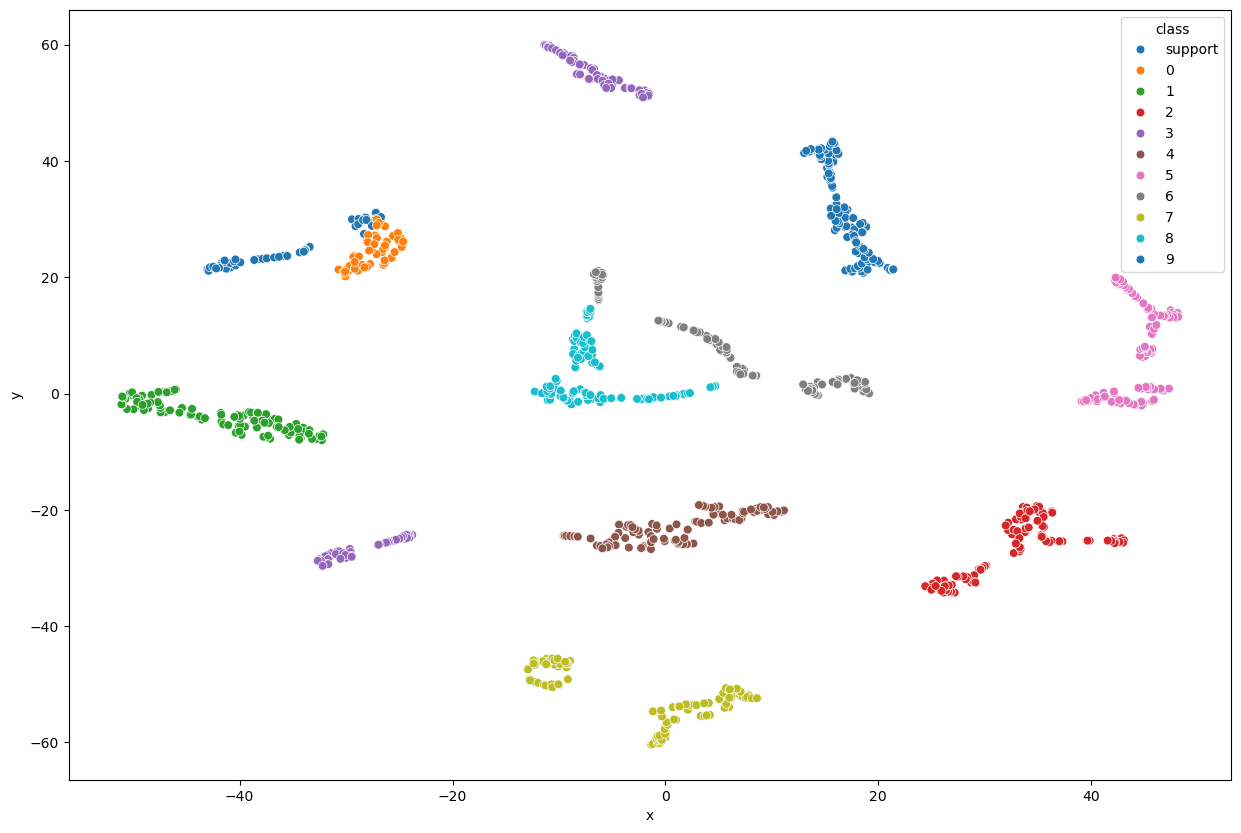

In [ ]:
print(support_group.shape)
print(query_group.shape)

tsne_embeddings = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *[query_groups[i] for i in range(10)]]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)

plt.figure(figsize=(15, 10))
palette = sns.color_palette()

sns.scatterplot(
    tsne_embeddings,
    x="x",
    y="y",
    s=40,
    hue="class",
    palette=palette,
    alpha=1.0,
    legend=True,
)

### 3D TSNE


In [ ]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *[query_groups[i] for i in range(10)]]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        *[len(query_groups[i]) * [i] for i in range(10)],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=1000,
    color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()

### 3D PCA


In [ ]:
pca = PCA(n_components=3)
pca.fit(support_group)

pca_embeddings = pca.transform(
    np.concatenate([support_group, *[query_groups[i] for i in range(10)]])
)

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=600,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
    # color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()

### Distances


SUPPORT
Mean: 16.93671
Max: 42.94537
Min: 1.0246133

0
Mean: 19.827328
Max: 39.675175
Min: 7.8753076
1
Mean: 1704.935
Max: 2164.3118
Min: 1250.8705
2
Mean: 4294.254
Max: 5830.092
Min: 3456.9822
3
Mean: 64093.36
Max: 85749.18
Min: 51463.008
4
Mean: 5297.435
Max: 7478.2627
Min: 3572.6733
5
Mean: 43555.9
Max: 54491.246
Min: 30182.012
6
Mean: 87081.516
Max: 104941.445
Min: 65232.098
7
Mean: 7902.1694
Max: 9748.569
Min: 6217.2466
8
Mean: 81551.71
Max: 93068.94
Min: 74672.695
9
Mean: 198619.6
Max: 217978.33
Min: 175300.52


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_71080/3057055446.py:31: UserWarning:

The palette list has more values (12) than needed (11), which may not be intended.



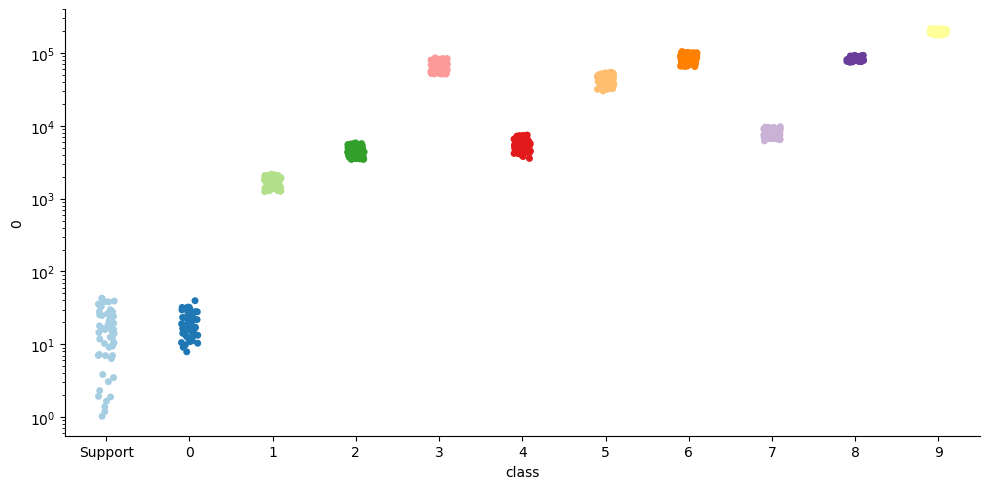

In [ ]:
prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in range(10):
    print(fault)
    query_distances[fault] = np.sum((query_groups[fault] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in range(10):
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    legend=False,
    palette=sns.color_palette("Paired"),
)

---

# OLD


# ARotor replication


In [ ]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

support_data = pd.read_feather(
    # os.path.join(data_folder, "anomality_detection_arotor_replication_10-18_17-34-48", "support_0.feather")
    os.path.join(
        data_folder,
        "anomality_detection_arotor_replication_10-25_12-55-17",
        "support_0.feather",
    )
)
query_data = pd.read_feather(
    # os.path.join(data_folder, "anomality_detection_arotor_replication_10-18_17-34-48", "query_0.feather")
    os.path.join(
        data_folder,
        "anomality_detection_arotor_replication_10-25_12-55-17",
        "query_0.feather",
    )
)

print("support", support_data.shape)
print("query", query_data.shape)

support (3410, 67)
query (30607, 69)


## Figures


In [ ]:
support_group = support_data[
    (support_data["rpm"] == 1500)
    & (support_data["GP"].isin([1, 2, 3, 4]))
    & (support_data["torque"] == 1)
].drop(["rpm", "GP", "torque"], axis=1)
support_group = support_group.to_numpy()

query_group = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group = query_group.to_numpy()

query_group_2 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "wear")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_2 = query_group_2.to_numpy()

query_group_3 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "pitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_3 = query_group_3.to_numpy()

query_group_4 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "micropitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_4 = query_group_4.to_numpy()

query_group_5 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "mild")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_5 = query_group_5.to_numpy()

query_group_6 = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "8")
    & (query_data["torque"] == 1)
    & (query_data["installation"] == 0)
    & (query_data["fault"] == "baseline")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group_6 = query_group_6.to_numpy()

/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_69976/3833122620.py:18: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.



<Axes: xlabel='x', ylabel='y'>

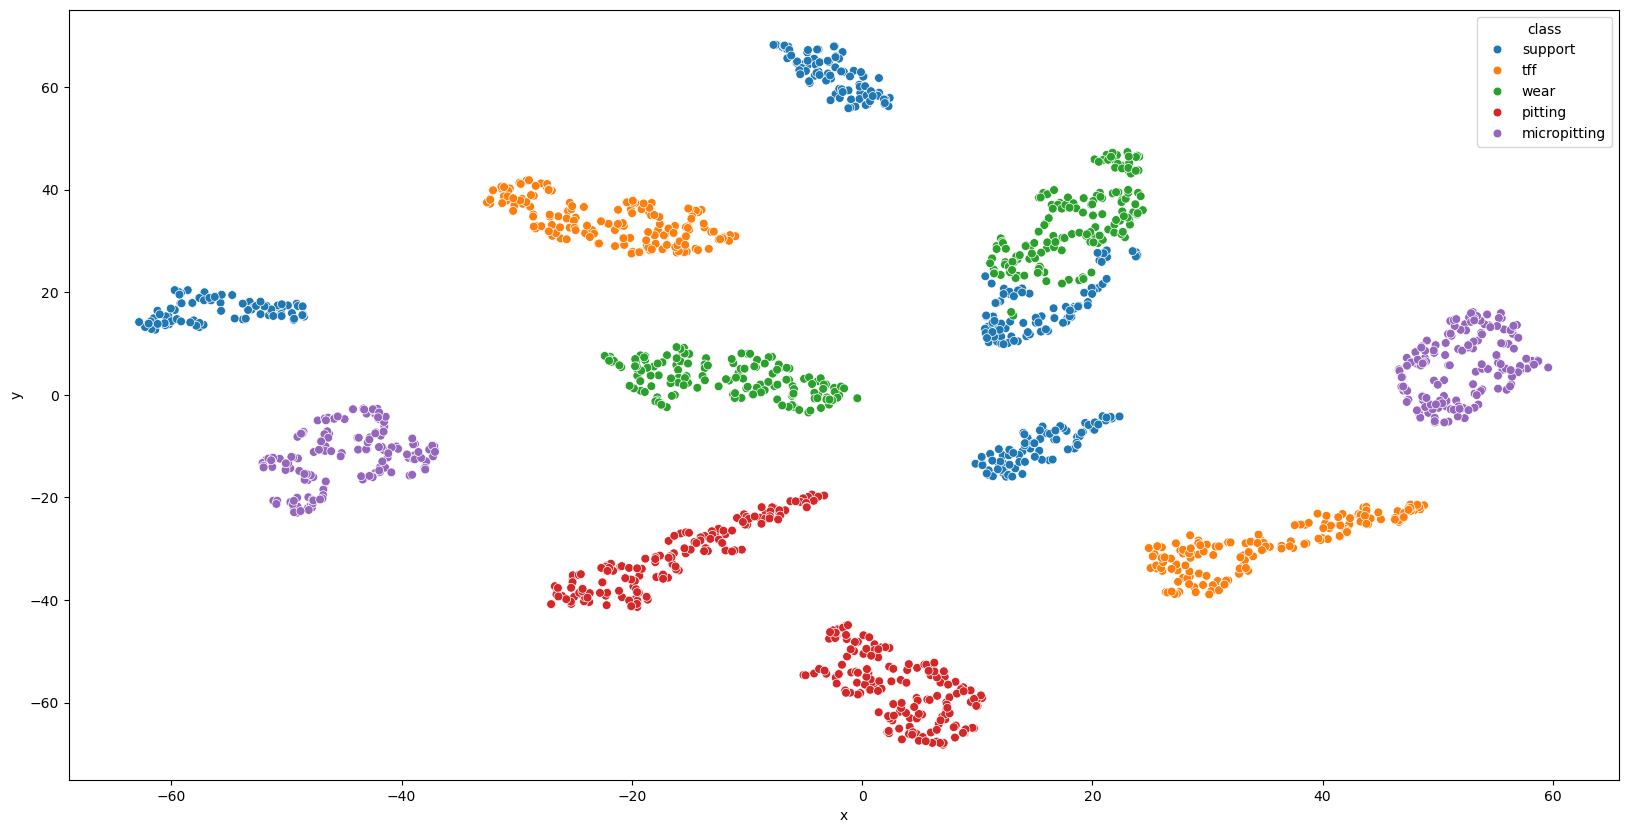

In [ ]:
tsne_embeddings = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=20
).fit_transform(
    np.concatenate(
        [support_group, query_group, query_group_2, query_group_3, query_group_4]
    )
)
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        len(query_group) * ["tff"],
        len(query_group_2) * ["wear"],
        len(query_group_3) * ["pitting"],
        len(query_group_4) * ["micropitting"],
    ]
)

plt.figure(figsize=(20, 10))
palette = sns.color_palette()

sns.scatterplot(
    tsne_embeddings,
    x="x",
    y="y",
    s=40,
    hue="class",
    palette=palette,
    alpha=1.0,
    legend=True,
)

In [ ]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(
    np.concatenate(
        [support_group, query_group, query_group_2, query_group_3, query_group_4]
    )
)
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        len(query_group) * ["tff"],
        len(query_group_2) * ["wear"],
        len(query_group_3) * ["pitting"],
        len(query_group_4) * ["micropitting"],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings, x="x", y="y", z="z", color="class", width=1200, height=1200
)
fig.show()

In [ ]:
pca = PCA(n_components=3)
pca.fit(support_group[:50])

pca_embeddings = pca.transform(
    np.concatenate(
        [
            support_group,
            query_group_6,
            query_group,
            query_group_2,
            query_group_3,
            query_group_4,
            query_group_5,
        ]
    )
)

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        len(query_group_6) * ["healthy"],
        len(query_group) * ["tff"],
        len(query_group_2) * ["wear"],
        len(query_group_3) * ["pitting"],
        len(query_group_4) * ["micropitting"],
        len(query_group_5) * ["mild tff"],
    ]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1200,
    height=1200,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
)
fig.show()

## Distance thresholding


In [ ]:
support_group = support_data[
    (support_data["rpm"] == 1500)
    & (support_data["GP"].isin([1, 2, 3, 4]))
    & (support_data["torque"] == 1)
].drop(["rpm", "GP", "torque"], axis=1)
support_group = support_group.to_numpy()

query_group = {}

query_group_baseline = query_data[
    (query_data["rpm"] == 1500)
    # & (query_data["severity"].isin(["5", "8", "9"]))
    # ! FIXME GPs 6 and 7 problematic why?
    & (query_data["severity"].isin(["5", "6", "7", "8", "9"]))
    & (query_data["torque"] == 1)
    & (query_data["installation"] == 0)
    & (query_data["fault"] == "baseline")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["baseline"] = query_group_baseline.to_numpy()

query_group_tff = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["tff"] = query_group_tff.to_numpy()

query_group_mild_tff = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "mild")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "tff")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["mild_tff"] = query_group_mild_tff.to_numpy()

query_group_wear = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "wear")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["wear"] = query_group_wear.to_numpy()

query_group_pitting = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "pitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["pitting"] = query_group_pitting.to_numpy()

query_group_micropitting = query_data[
    (query_data["rpm"] == 1500)
    & (query_data["severity"] == "severe")
    & (query_data["torque"] == 1)
    & (query_data["installation"].isin([1, 2]))
    & (query_data["fault"] == "micropitting")
].drop(["rpm", "severity", "fault", "installation", "torque"], axis=1)
query_group["micropitting"] = query_group_micropitting.to_numpy()

### Raw distance


SUPPORT
Mean: 284203.4
Max: 794919.9
Min: 64831.215

baseline
Mean: 2686348.2
Max: 9524642.0
Min: 81452.74
mild_tff
Mean: 1466611.5
Max: 2343536.2
Min: 599408.06
tff
Mean: 42701184.0
Max: 135601070.0
Min: 13163798.0
micropitting
Mean: 8532213.0
Max: 18324992.0
Min: 1161437.8
pitting
Mean: 5623113.5
Max: 9232406.0
Min: 1763113.6
wear
Mean: 350861.34
Max: 731612.44
Min: 64104.336


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_69976/2274576752.py:31: UserWarning:

The palette list has more values (12) than needed (7), which may not be intended.



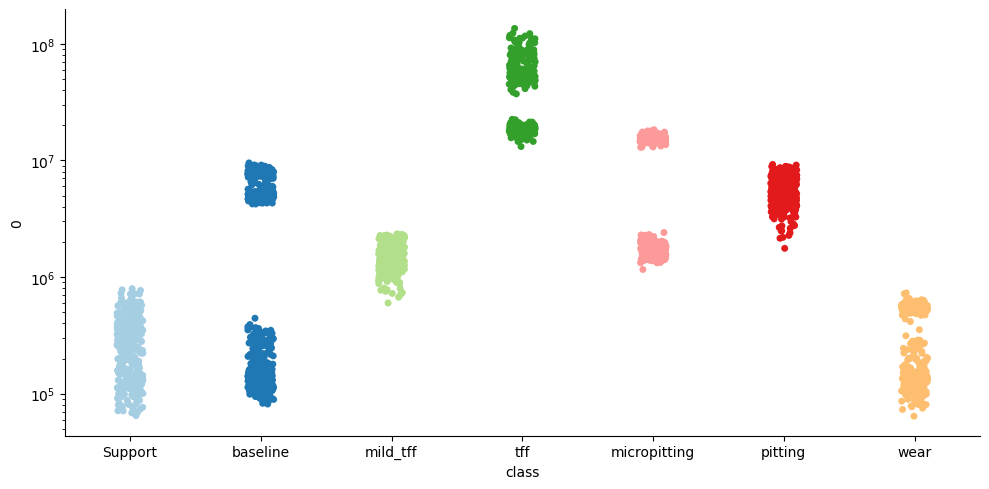

In [ ]:
prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    print(fault)
    query_distances[fault] = np.sum((query_group[fault] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    palette=sns.color_palette("Paired"),
    legend=False,
)

### STD scaled distance


SUPPORT
Mean: 63.853104
Max: 245.57063
Min: 15.81571

baseline
Mean: 513.15875
Max: 1723.5696
Min: 26.33206
mild_tff
Mean: 250.26807
Max: 417.69586
Min: 98.74089
tff
Mean: 21661.05
Max: 37699.156
Min: 12174.85
micropitting
Mean: 1662.2854
Max: 3562.3071
Min: 180.07896
pitting
Mean: 1104.7709
Max: 1902.5264
Min: 314.42163
wear
Mean: 92.59843
Max: 182.37373
Min: 18.066534


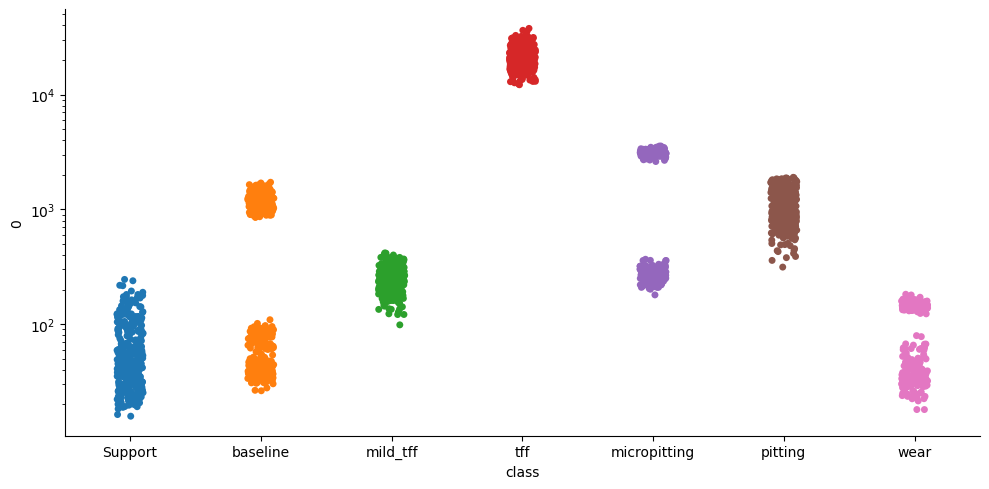

In [ ]:
prototype = support_group.mean(axis=0)
prototype_std = support_group.std(axis=0)

prototype_std += 0.01  # Some stds are 0

print("SUPPORT")
support_distances = np.sum(((support_group - prototype) / prototype_std) ** 2, axis=1)
# support_distances = support_distances / prototype_std
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    print(fault)
    query_distances[fault] = np.sum(
        ((query_group[fault] - prototype) / prototype_std) ** 2, axis=1
    )
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df, x="class", y=0, hue="class", log_scale=True, height=5, aspect=2, legend=False
)

### Distance after PCA


(341, 5)
(5,)
SUPPORT
Mean: 282891.8
Max: 790609.75
Min: 63715.84

baseline
Mean: 2668191.0
Max: 9465446.0
Min: 79221.07

mild_tff
Mean: 1455084.9
Max: 2324417.8
Min: 591030.44

tff
Mean: 41453290.0
Max: 130277970.0
Min: 12678226.0

micropitting
Mean: 8494871.0
Max: 18259750.0
Min: 1153664.5

pitting
Mean: 5602508.0
Max: 9211996.0
Min: 1749229.9

wear
Mean: 343125.97
Max: 719074.6
Min: 62858.652



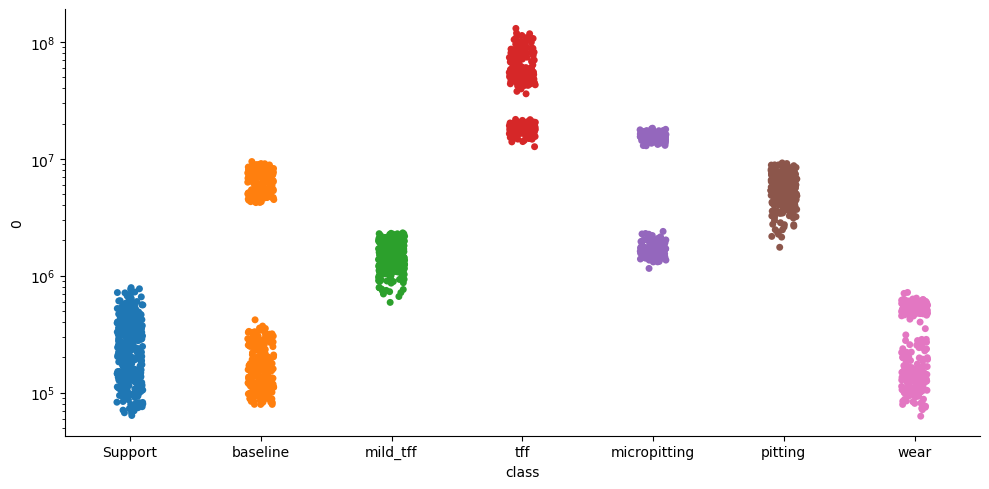

In [ ]:
pca = PCA(n_components=5)
support_group_pca = pca.fit_transform(support_group)
print(support_group_pca.shape)


prototype = support_group_pca.mean(axis=0)
print(prototype.shape)

print("SUPPORT")
support_distances = np.sum((support_group_pca - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    print(fault)
    query_distances[fault] = np.sum(
        (pca.transform(query_group[fault]) - prototype) ** 2, axis=1
    )
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())
    print()

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in ["baseline", "mild_tff", "tff", "micropitting", "pitting", "wear"]:
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df, x="class", y=0, hue="class", log_scale=True, height=5, aspect=2, legend=False
)

# ARotor


In [ ]:
data_folder = os.path.join(
    os.path.abspath(""), os.pardir, os.pardir, "reports", "RAW", "embedding_databases"
)

support_data = pd.read_feather(
    os.path.join(
        data_folder, "anomality_detection_arotor_10-18_17-35-55", "support_0.feather"
    )
)
query_data = pd.read_feather(
    os.path.join(
        data_folder, "anomality_detection_arotor_10-18_17-35-55", "query_0.feather"
    )
)

print("support", support_data.shape)
print("query", query_data.shape)

support (208, 66)
query (3952, 66)


In [ ]:
support_group = support_data[(support_data["rpm"] == 1500)].drop(
    ["rpm", "class"], axis=1
)
support_group = support_group.to_numpy()

query_groups = {}

for i in range(10):
    query_group = query_data[
        (query_data["rpm"] == 1500) & (query_data["class"] == i)
    ].drop(["rpm", "class"], axis=1)
    query_groups[i] = query_group.to_numpy()

(52, 64)
(104, 64)


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_69976/1751696896.py:15: UserWarning:


The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.



<Axes: xlabel='x', ylabel='y'>

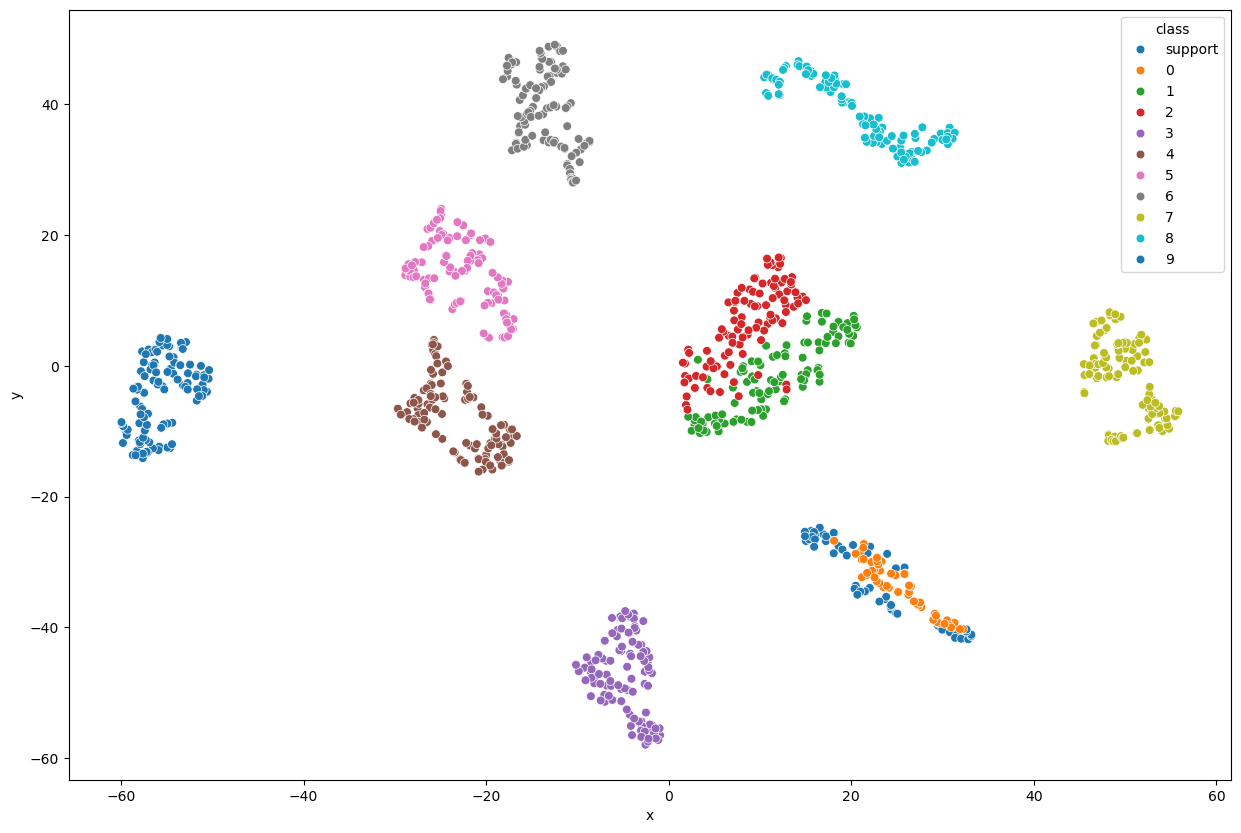

In [ ]:
print(support_group.shape)
print(query_group.shape)

tsne_embeddings = TSNE(
    n_components=2, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *[query_groups[i] for i in range(10)]]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y"])
tsne_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)

plt.figure(figsize=(15, 10))
palette = sns.color_palette()

sns.scatterplot(
    tsne_embeddings,
    x="x",
    y="y",
    s=40,
    hue="class",
    palette=palette,
    alpha=1.0,
    legend=True,
)

In [ ]:
tsne_embeddings = TSNE(
    n_components=3, learning_rate="auto", init="random", perplexity=20
).fit_transform(np.concatenate([support_group, *[query_groups[i] for i in range(10)]]))
tsne_embeddings = pd.DataFrame(tsne_embeddings, columns=["x", "y", "z"])
tsne_embeddings["class"] = np.concatenate(
    [
        len(support_group) * ["support"],
        *[len(query_groups[i]) * [i] for i in range(10)],
    ]
)

fig = px.scatter_3d(
    tsne_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=1000,
    color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()

In [ ]:
pca = PCA(n_components=3)
pca.fit(support_group)

pca_embeddings = pca.transform(
    np.concatenate([support_group, *[query_groups[i] for i in range(10)]])
)

pca_embeddings = pd.DataFrame(pca_embeddings, columns=["x", "y", "z"])
pca_embeddings["class"] = np.concatenate(
    [len(support_group) * ["support"], *[len(query_groups[i]) * [i] for i in range(10)]]
)


fig = px.scatter_3d(
    pca_embeddings,
    x="x",
    y="y",
    z="z",
    color="class",
    width=1000,
    height=600,
    color_discrete_sequence=sns.color_palette("Paired").as_hex(),
    # color_discrete_sequence=px.colors.qualitative.Light24,
)
fig.show()

In [ ]:
str(sns.color_palette().as_hex())

"['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']"

### Distances


In [ ]:
support_group = support_data[(support_data["rpm"] == 1500)].drop(
    ["rpm", "class"], axis=1
)
support_group = support_group.to_numpy()

query_group = {}

for i in range(10):
    query_group_baseline = query_data[
        (query_data["rpm"] == 1500) & (query_data["class"] == i)
    ].drop(["rpm", "class"], axis=1)
    query_group["baseline"] = query_group_baseline.to_numpy()

SUPPORT
Mean: 6542.1953
Max: 30318.348
Min: 863.4813

0
Mean: 3713.5776
Max: 12462.372
Min: 1637.6204
1
Mean: 4100191.5
Max: 5851580.5
Min: 3012762.5
2
Mean: 4396277.0
Max: 6185351.5
Min: 3020712.0
3
Mean: 1794723.2
Max: 2658541.0
Min: 1046323.3
4
Mean: 184759.08
Max: 486035.88
Min: 98558.4
5
Mean: 470167.78
Max: 906059.9
Min: 184549.25
6
Mean: 928152.94
Max: 1499536.9
Min: 396398.88
7
Mean: 241784.47
Max: 411656.22
Min: 87098.234
8
Mean: 532484.8
Max: 818234.75
Min: 352948.75
9
Mean: 1229076.9
Max: 1843879.2
Min: 853211.1


/var/folders/cx/1v2hhggj48s5vpt1wv2m167h0000gp/T/ipykernel_56158/3284075337.py:31: UserWarning:

The palette list has more values (12) than needed (11), which may not be intended.



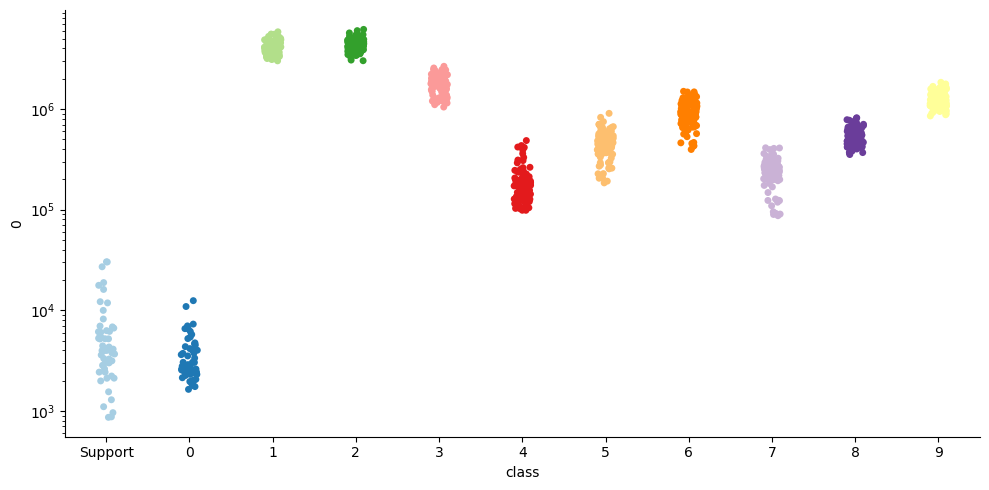

In [ ]:
prototype = support_group.mean(axis=0)

print("SUPPORT")
support_distances = np.sum((support_group - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in range(10):
    print(fault)
    query_distances[fault] = np.sum((query_groups[fault] - prototype) ** 2, axis=1)
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in range(10):
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df,
    x="class",
    y=0,
    hue="class",
    log_scale=True,
    height=5,
    aspect=2,
    legend=False,
    palette=sns.color_palette("Paired"),
)

(52, 5)
(5,)
SUPPORT
Mean: 6171.154
Max: 30053.492
Min: 557.91754

0
Mean: 2737.9983
Max: 11904.995
Min: 675.12946

1
Mean: 3810128.2
Max: 5371965.0
Min: 2813731.0

2
Mean: 4028095.5
Max: 5539995.0
Min: 2785049.0

3
Mean: 1663222.6
Max: 2454545.0
Min: 979221.3

4
Mean: 168045.5
Max: 458705.03
Min: 84806.29

5
Mean: 425348.7
Max: 806707.44
Min: 166935.22

6
Mean: 771405.9
Max: 1308005.4
Min: 326110.62

7
Mean: 210900.72
Max: 371079.72
Min: 76442.47

8
Mean: 351590.8
Max: 626976.1
Min: 205615.33

9
Mean: 816633.75
Max: 1276034.9
Min: 562547.8



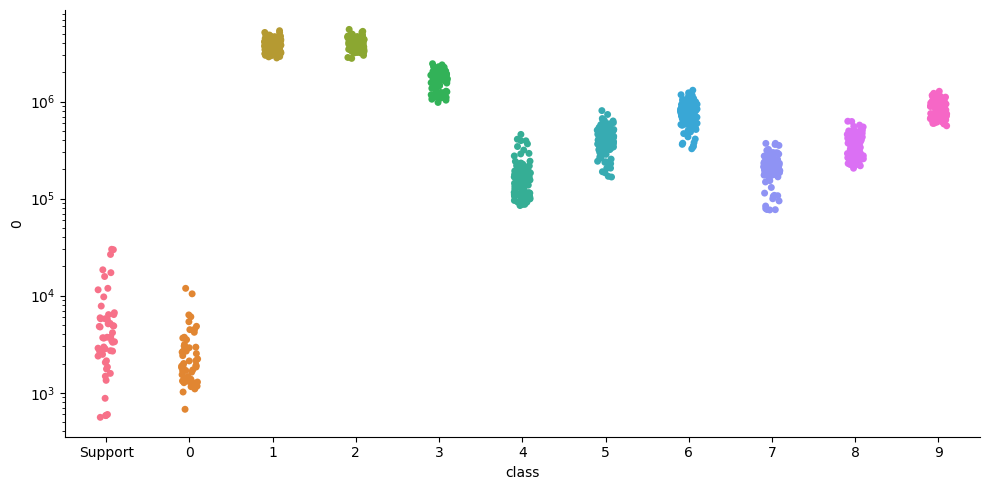

In [ ]:
pca = PCA(n_components=5)
support_group_pca = pca.fit_transform(support_group)
print(support_group_pca.shape)


prototype = support_group_pca.mean(axis=0)
print(prototype.shape)

print("SUPPORT")
support_distances = np.sum((support_group_pca - prototype) ** 2, axis=1)
print("Mean:", support_distances.mean())
print("Max:", support_distances.max())
print("Min:", support_distances.min())
print()

query_distances = {}
for fault in range(10):
    print(fault)
    query_distances[fault] = np.sum(
        (pca.transform(query_groups[fault]) - prototype) ** 2, axis=1
    )
    print("Mean:", query_distances[fault].mean())
    print("Max:", query_distances[fault].max())
    print("Min:", query_distances[fault].min())
    print()

# Plotting

support_df = pd.DataFrame(support_distances)
support_df["class"] = "Support"

query_dfs = []
for fault in range(10):
    query_df = pd.DataFrame(query_distances[fault])
    query_df["class"] = fault
    query_dfs.append(query_df)

df = pd.concat([support_df, *query_dfs])

sns.catplot(
    df, x="class", y=0, hue="class", log_scale=True, height=5, aspect=2, legend=False
)